In [1]:
import fitz  # PyMuPDF
import pandas as pd
import numpy as np
import re
import os
from PIL import Image
import io
import matplotlib.pyplot as plt

In [2]:
pdf_file = '/Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/CIRUGIA.pdf'

In [3]:
def extract_questions(pdf_path):
    doc = fitz.open(pdf_path)
    questions_data = []  # List to store questions

    # Updated regular expression: handle questions with or without a '?'
    #question_pattern = re.compile(r"(\d+)\.\s(.*?)(?:\?)?\s*(?=A\.)", re.DOTALL)
    question_pattern = re.compile(r"(\d+)\.\s(.*?\??)\s*(?=A\.)", re.DOTALL)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        
        # Find all questions in the text using findall()
        questions = question_pattern.findall(text)
        
        # Append all the questions to the questions_data list
        for _, question in questions:
            questions_data.append(question.strip())  # Store the cleaned question text

    # Convert extracted questions to DataFrame
    questions_df = pd.DataFrame(questions_data, columns=["question"])
    return questions_df

In [4]:
def extract_answers(pdf_path):
    doc = fitz.open(pdf_path)
    answers_data = []  # List to store answers for each question

    # Regular expression for extracting answers
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)

    for page in doc:
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines for structured parsing

        current_answers = []  # List to store answers for a given question
        for line in lines:
            answer_match = answer_pattern.match(line)
            if answer_match:
                opt, ans_text = answer_match.groups()
                current_answers.append(ans_text.strip())

            # After four options are found, store them as one row in answers_data
            if len(current_answers) == 5:
                answers_data.append(current_answers)
                current_answers = []  # Reset for next question

    # Convert extracted answers to DataFrame with four columns
    answers_df = pd.DataFrame(answers_data, columns = ["option_A", "option_B", "option_C", "option_D", "option_E"])
    return answers_df

In [5]:
def get_largest_rectangle(rects):
    """Return the largest rectangle from a list of rectangles."""
    if not rects:
        return None
    
    # Calculate area for each rectangle and store with index
    areas = [(abs((rect.br.x - rect.tl.x) * (rect.br.y - rect.tl.y)), idx) 
             for idx, rect in enumerate(rects)]
    
    # Sort by area (first element of tuple)
    areas.sort(key=lambda x: x[0], reverse=True)
    
    # Return the rectangle with largest area
    return rects[areas[0][1]]

def extract_correct_answers(pdf_path):
    doc = fitz.open(pdf_path)
    correct_answers = []
    missing_questions = []  # Track questions that were skipped
    
    # Flexible regex for answer choices (handles missing spaces like "A." and "A. ")
    answer_pattern = re.compile(r"^(A|B|C|D|E)\.\s(.+)", re.MULTILINE)
    
    for page_num, page in enumerate(doc, start=1):
        text = page.get_text("text")  # Extract full page text
        lines = text.split("\n")  # Split into lines
        
        # Extract valid answer positions using regex
        answer_positions = {key: [] for key in ["A", "B", "C", "D", "E"]}
        
        for line in lines:
            match = answer_pattern.match(line)
            if match:
                answer_letter, answer_text = match.groups()
                
                # Try different search variations to find the best match
                search_texts = [
                    match.group(0),  # Original matched text
                    match.group(0).strip(),  # Stripped version
                    answer_letter + '.' + answer_text,  # Without space after period
                    answer_letter.upper() + '. ' + answer_text,  # Different case
                ]
                
                rects = None
                used_search_text = ""
                
                # Find the first successful search
                for search_text in search_texts:
                    rects = page.search_for(search_text)
                    if rects:
                        used_search_text = search_text
                        break
                
                if rects:
                    # Select the largest rectangle
                    largest_rect = get_largest_rectangle(rects)
                    if largest_rect:
                        answer_positions[answer_letter].append(largest_rect)
        
        # Find the maximum number of questions on the page
        num_questions = max(len(answer_positions["A"]), len(answer_positions["B"]), len(answer_positions["C"]),
                          len(answer_positions["D"]), len(answer_positions["E"]))
        
        # Debugging: Show how many answers were found
        print(f"\nPage {page_num}: Found {num_questions} questions")
        
        for idx in range(num_questions):
            best_answer = None
            best_yellow_pixels = 0  # Track the highest number of yellow pixels
            has_all_options = True  # Flag to check if we have all 4 options
            
            for answer_letter in ["A", "B", "C", "D", "E"]:
                rects = answer_positions[answer_letter]
                if idx >= len(rects):
                    has_all_options = False  # Missing one or more options
                    continue
                
                rect = rects[idx]
                
                # Debugging: Print detected answer positions
                print(f"Page {page_num}, Q{idx+1} - {answer_letter}: Detected box: "
                      f"x0={rect.x0:.1f}, y0={rect.y0:.1f}, x1={rect.x1:.1f}, y1={rect.y1:.1f}")
                
                # Expand bounding box only to the right
                expanded_rect = fitz.Rect(rect.x0, rect.y0, rect.x1 + 50, rect.y1)
                
                # Extract pixels from the expanded region
                pixmap = page.get_pixmap(clip=expanded_rect)
                img = np.frombuffer(pixmap.samples, dtype=np.uint8).reshape(pixmap.h, pixmap.w, pixmap.n)
                
                # Count yellow pixels (pixels with high red and green, low blue)
                yellow_mask = (
                    (img[:, :, 0] > 200) &  # High red
                    (img[:, :, 1] > 200) &  # High green
                    (img[:, :, 2] < 150)    # Low blue
                )
                yellow_pixels = np.sum(yellow_mask)
                
                # Count total non-white pixels
                nonwhite_mask = ~np.all(img > 250, axis=2)
                total_pixels = np.sum(nonwhite_mask)
                
                # Debug information
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow pixels: {yellow_pixels}")
                print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Total non-white pixels: {total_pixels}")
                
                if total_pixels > 0:
                    yellow_percentage = (yellow_pixels / total_pixels) * 100
                    print(f"Page {page_num}, Q{idx+1}, {answer_letter}: Yellow percentage: {yellow_percentage:.1f}%")
                
                # Display the box in the notebook
                plt.figure(figsize=(8, 4))
                plt.imshow(img)
                plt.gca().add_patch(plt.Rectangle((0, 0), expanded_rect.width, expanded_rect.height,
                                                fill=False, color='red', linewidth=2))
                plt.title(f'Page {page_num}, Q{idx+1}, Answer {answer_letter}\nYellow pixels: {yellow_pixels}')
                plt.axis('off')
                plt.show()
                
                # Store the best answer based on the highest number of yellow pixels
                if yellow_pixels > best_yellow_pixels:
                    best_yellow_pixels = yellow_pixels
                    best_answer = answer_letter
            
            # If missing options, log missing questions
            if not has_all_options:
                missing_questions.append(f"Page {page_num}, Q{idx+1}")
            
            if best_answer:
                correct_answers.append(best_answer)
                print(f"\nPage {page_num}, Q{idx+1} - Selected Answer: {best_answer} (based on yellow pixel count)")
                print("====================================================================================================")
                print("\n")
                print("\n")
            else:
                correct_answers.append("DK")
    
    # Debugging: Print missing questions
    if missing_questions:
        print("\n⚠️ The following questions were skipped due to missing options:")
        for q in missing_questions:
            print(q)
    
    return pd.DataFrame(correct_answers, columns=["correct_answer"])


Page 1: Found 9 questions
Page 1, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=160.7, y1=121.6
Page 1, Q1, A: Yellow pixels: 0
Page 1, Q1, A: Total non-white pixels: 386
Page 1, Q1, A: Yellow percentage: 0.0%


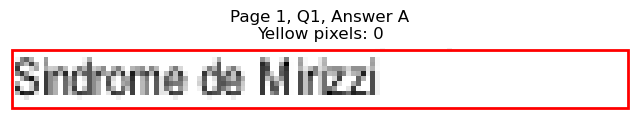

Page 1, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=168.2, y1=133.6
Page 1, Q1, B: Yellow pixels: 0
Page 1, Q1, B: Total non-white pixels: 464
Page 1, Q1, B: Yellow percentage: 0.0%


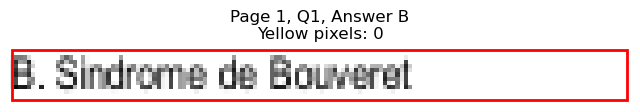

Page 1, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=117.3, y1=145.6
Page 1, Q1, C: Yellow pixels: 354
Page 1, Q1, C: Total non-white pixels: 572
Page 1, Q1, C: Yellow percentage: 61.9%


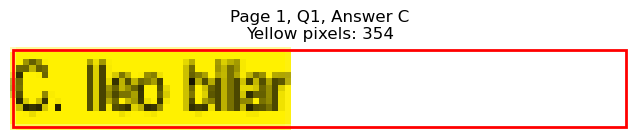

Page 1, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=398.9, y1=121.6
Page 1, Q1, D: Yellow pixels: 0
Page 1, Q1, D: Total non-white pixels: 544
Page 1, Q1, D: Yellow percentage: 0.0%


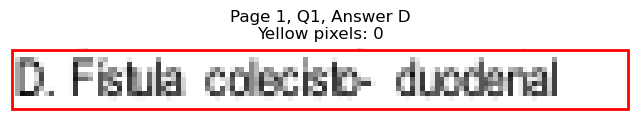

Page 1, Q1 - E: Detected box: x0=361.9, y0=121.5, x1=432.7, y1=133.6
Page 1, Q1, E: Yellow pixels: 0
Page 1, Q1, E: Total non-white pixels: 347
Page 1, Q1, E: Yellow percentage: 0.0%


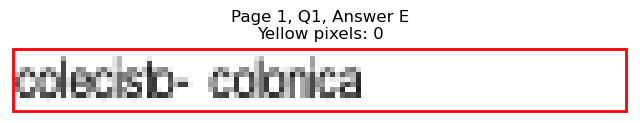


Page 1, Q1 - Selected Answer: C (based on yellow pixel count)




Page 1, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=205.1, y1=193.6
Page 1, Q2, A: Yellow pixels: 963
Page 1, Q2, A: Total non-white pixels: 1573
Page 1, Q2, A: Yellow percentage: 61.2%


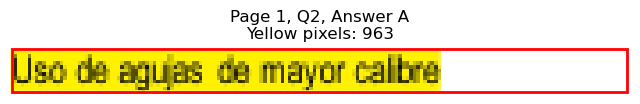

Page 1, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=204.2, y1=205.6
Page 1, Q2, B: Yellow pixels: 120
Page 1, Q2, B: Total non-white pixels: 760
Page 1, Q2, B: Yellow percentage: 15.8%


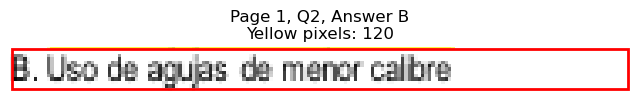

Page 1, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=143.5, y1=217.7
Page 1, Q2, C: Yellow pixels: 0
Page 1, Q2, C: Total non-white pixels: 339
Page 1, Q2, C: Yellow percentage: 0.0%


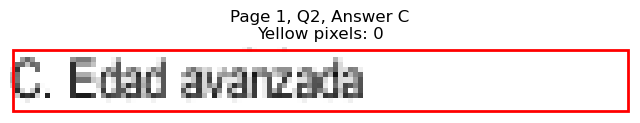

Page 1, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=395.8, y1=193.6
Page 1, Q2, D: Yellow pixels: 0
Page 1, Q2, D: Total non-white pixels: 356
Page 1, Q2, D: Yellow percentage: 0.0%


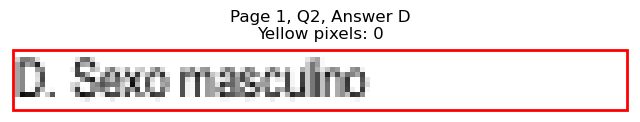

Page 1, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=486.5, y1=205.6
Page 1, Q2, E: Yellow pixels: 0
Page 1, Q2, E: Total non-white pixels: 780
Page 1, Q2, E: Yellow percentage: 0.0%


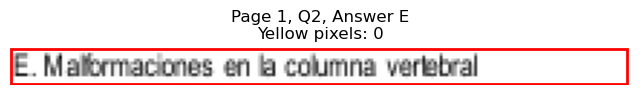


Page 1, Q2 - Selected Answer: A (based on yellow pixel count)




Page 1, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=174.2, y1=253.7
Page 1, Q3, A: Yellow pixels: 0
Page 1, Q3, A: Total non-white pixels: 461
Page 1, Q3, A: Yellow percentage: 0.0%


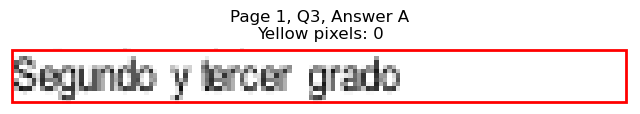

Page 1, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=173.5, y1=265.7
Page 1, Q3, B: Yellow pixels: 0
Page 1, Q3, B: Total non-white pixels: 499
Page 1, Q3, B: Yellow percentage: 0.0%


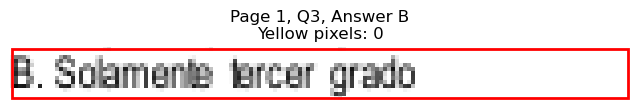

Page 1, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=175.8, y1=277.7
Page 1, Q3, C: Yellow pixels: 0
Page 1, Q3, C: Total non-white pixels: 502
Page 1, Q3, C: Yellow percentage: 0.0%


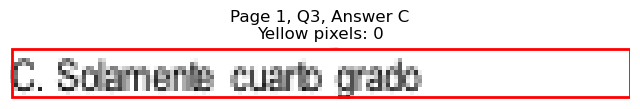

Page 1, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=427.4, y1=253.7
Page 1, Q3, D: Yellow pixels: 828
Page 1, Q3, D: Total non-white pixels: 1352
Page 1, Q3, D: Yellow percentage: 61.2%


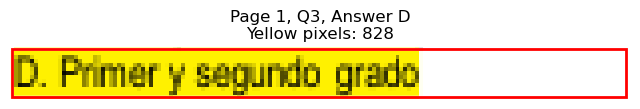

Page 1, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=401.0, y1=265.7
Page 1, Q3, E: Yellow pixels: 102
Page 1, Q3, E: Total non-white pixels: 468
Page 1, Q3, E: Yellow percentage: 21.8%


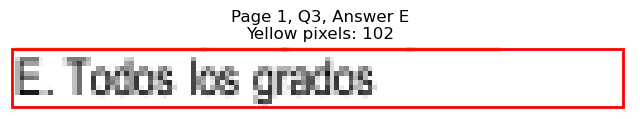


Page 1, Q3 - Selected Answer: D (based on yellow pixel count)




Page 1, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=113.5, y1=314.5
Page 1, Q4, A: Yellow pixels: 0
Page 1, Q4, A: Total non-white pixels: 146
Page 1, Q4, A: Yellow percentage: 0.0%


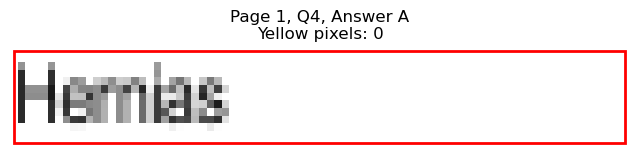

Page 1, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=145.0, y1=326.5
Page 1, Q4, B: Yellow pixels: 0
Page 1, Q4, B: Total non-white pixels: 370
Page 1, Q4, B: Yellow percentage: 0.0%


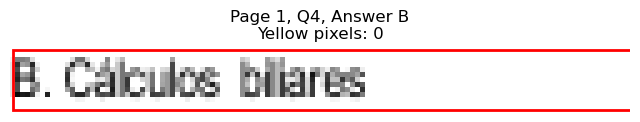

Page 1, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=151.1, y1=338.5
Page 1, Q4, C: Yellow pixels: 0
Page 1, Q4, C: Total non-white pixels: 364
Page 1, Q4, C: Yellow percentage: 0.0%


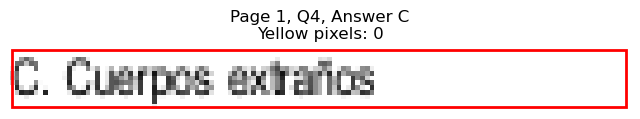

Page 1, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=370.3, y1=314.5
Page 1, Q4, D: Yellow pixels: 0
Page 1, Q4, D: Total non-white pixels: 205
Page 1, Q4, D: Yellow percentage: 0.0%


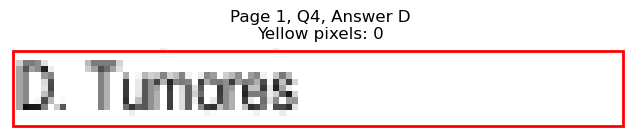

Page 1, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=414.7, y1=326.5
Page 1, Q4, E: Yellow pixels: 780
Page 1, Q4, E: Total non-white pixels: 1183
Page 1, Q4, E: Yellow percentage: 65.9%


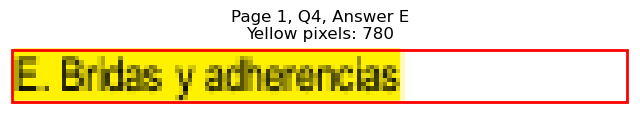


Page 1, Q4 - Selected Answer: E (based on yellow pixel count)




Page 1, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=130.0, y1=398.6
Page 1, Q5, A: Yellow pixels: 0
Page 1, Q5, A: Total non-white pixels: 428
Page 1, Q5, A: Yellow percentage: 0.0%


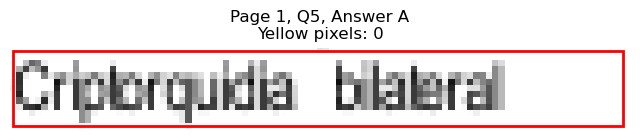

Page 1, Q5 - B: Detected box: x0=119.3, y0=398.5, x1=183.2, y1=410.6
Page 1, Q5, B: Yellow pixels: 0
Page 1, Q5, B: Total non-white pixels: 346
Page 1, Q5, B: Yellow percentage: 0.0%


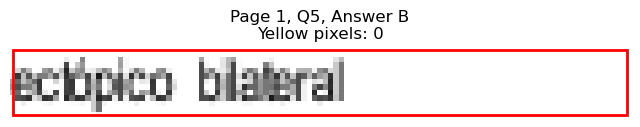

Page 1, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=154.7, y1=422.6
Page 1, Q5, C: Yellow pixels: 0
Page 1, Q5, C: Total non-white pixels: 637
Page 1, Q5, C: Yellow percentage: 0.0%


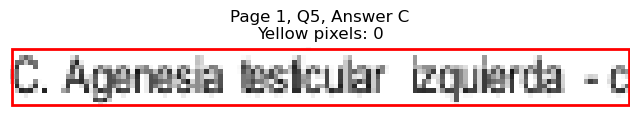

Page 1, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=381.5, y1=398.6
Page 1, Q5, D: Yellow pixels: 868
Page 1, Q5, D: Total non-white pixels: 1430
Page 1, Q5, D: Yellow percentage: 60.7%


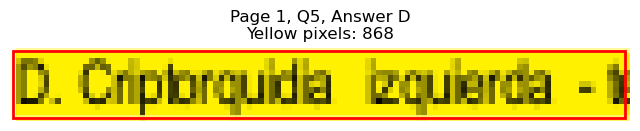

Page 1, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=405.5, y1=422.6
Page 1, Q5, E: Yellow pixels: 30
Page 1, Q5, E: Total non-white pixels: 690
Page 1, Q5, E: Yellow percentage: 4.3%


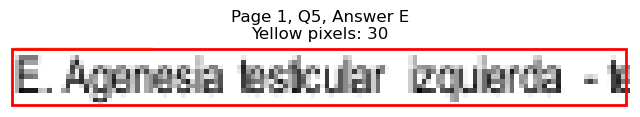


Page 1, Q5 - Selected Answer: D (based on yellow pixel count)




Page 1, Q6 - A: Detected box: x0=82.6, y0=458.6, x1=133.1, y1=470.6
Page 1, Q6, A: Yellow pixels: 372
Page 1, Q6, A: Total non-white pixels: 637
Page 1, Q6, A: Yellow percentage: 58.4%


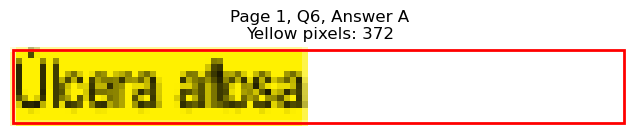

Page 1, Q6 - B: Detected box: x0=71.3, y0=470.6, x1=192.2, y1=482.6
Page 1, Q6, B: Yellow pixels: 48
Page 1, Q6, B: Total non-white pixels: 650
Page 1, Q6, B: Yellow percentage: 7.4%


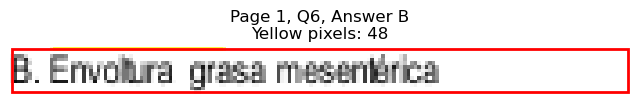

Page 1, Q6 - C: Detected box: x0=71.3, y0=483.4, x1=168.2, y1=495.4
Page 1, Q6, C: Yellow pixels: 0
Page 1, Q6, C: Total non-white pixels: 446
Page 1, Q6, C: Yellow percentage: 0.0%


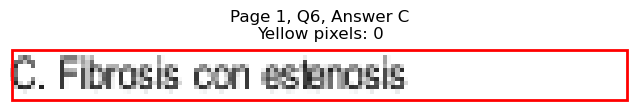

Page 1, Q6 - D: Detected box: x0=322.9, y0=458.6, x1=430.3, y1=470.6
Page 1, Q6, D: Yellow pixels: 0
Page 1, Q6, D: Total non-white pixels: 764
Page 1, Q6, D: Yellow percentage: 0.0%


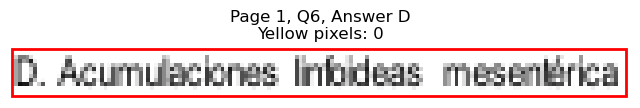

Page 1, Q6 - E: Detected box: x0=322.9, y0=470.6, x1=469.2, y1=482.6
Page 1, Q6, E: Yellow pixels: 0
Page 1, Q6, E: Total non-white pixels: 724
Page 1, Q6, E: Yellow percentage: 0.0%


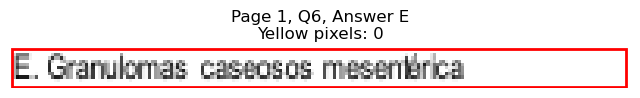


Page 1, Q6 - Selected Answer: A (based on yellow pixel count)




Page 1, Q7 - A: Detected box: x0=82.6, y0=555.4, x1=139.8, y1=567.5
Page 1, Q7, A: Yellow pixels: 479
Page 1, Q7, A: Total non-white pixels: 730
Page 1, Q7, A: Yellow percentage: 65.6%


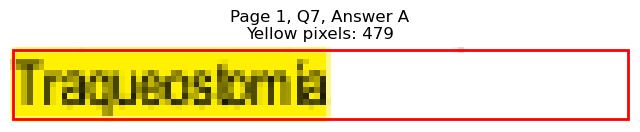

Page 1, Q7 - B: Detected box: x0=71.3, y0=567.5, x1=132.2, y1=579.5
Page 1, Q7, B: Yellow pixels: 54
Page 1, Q7, B: Total non-white pixels: 332
Page 1, Q7, B: Yellow percentage: 16.3%


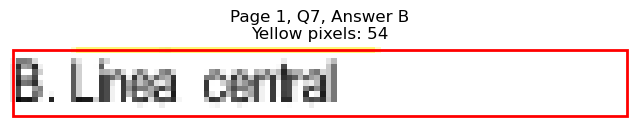

Page 1, Q7 - C: Detected box: x0=71.3, y0=579.4, x1=130.0, y1=591.5
Page 1, Q7, C: Yellow pixels: 0
Page 1, Q7, C: Total non-white pixels: 262
Page 1, Q7, C: Yellow percentage: 0.0%


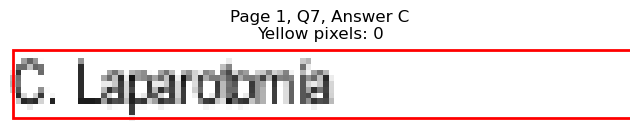

Page 1, Q7 - D: Detected box: x0=322.9, y0=555.4, x1=386.0, y1=567.5
Page 1, Q7, D: Yellow pixels: 0
Page 1, Q7, D: Total non-white pixels: 316
Page 1, Q7, D: Yellow percentage: 0.0%


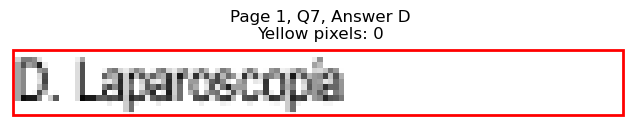

Page 1, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=382.3, y1=579.5
Page 1, Q7, E: Yellow pixels: 0
Page 1, Q7, E: Total non-white pixels: 292
Page 1, Q7, E: Yellow percentage: 0.0%


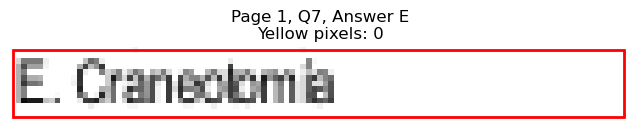


Page 1, Q7 - Selected Answer: A (based on yellow pixel count)




Page 1, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=127.0, y1=639.6
Page 1, Q8, A: Yellow pixels: 0
Page 1, Q8, A: Total non-white pixels: 231
Page 1, Q8, A: Yellow percentage: 0.0%


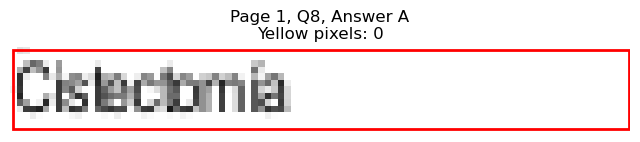

Page 1, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=126.2, y1=651.6
Page 1, Q8, B: Yellow pixels: 0
Page 1, Q8, B: Total non-white pixels: 469
Page 1, Q8, B: Yellow percentage: 0.0%


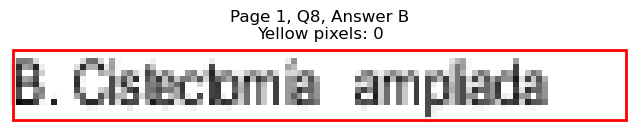

Page 1, Q8 - C: Detected box: x0=121.6, y0=651.5, x1=176.5, y1=663.6
Page 1, Q8, C: Yellow pixels: 0
Page 1, Q8, C: Total non-white pixels: 506
Page 1, Q8, C: Yellow percentage: 0.0%


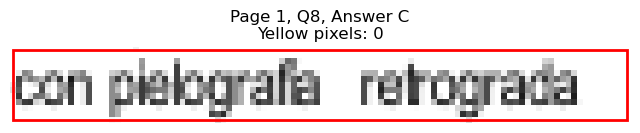

Page 1, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=388.3, y1=639.6
Page 1, Q8, D: Yellow pixels: 1050
Page 1, Q8, D: Total non-white pixels: 1521
Page 1, Q8, D: Yellow percentage: 69.0%


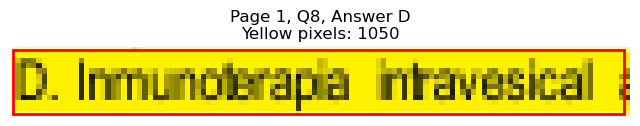

Page 1, Q8 - E: Detected box: x0=371.6, y0=639.5, x1=426.5, y1=651.6
Page 1, Q8, E: Yellow pixels: 103
Page 1, Q8, E: Total non-white pixels: 386
Page 1, Q8, E: Yellow percentage: 26.7%


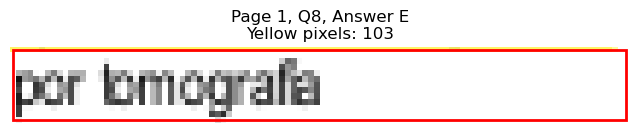


Page 1, Q8 - Selected Answer: D (based on yellow pixel count)




Page 1, Q9 - A: Detected box: x0=71.3, y0=700.3, x1=79.7, y1=712.3
Page 1, Q9, A: Yellow pixels: 0
Page 1, Q9, A: Total non-white pixels: 51
Page 1, Q9, A: Yellow percentage: 0.0%


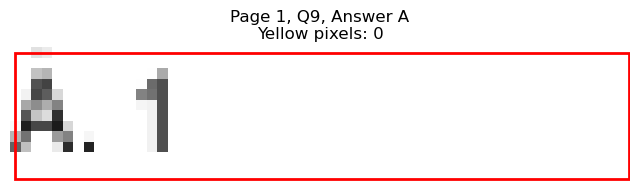

Page 1, Q9 - B: Detected box: x0=71.3, y0=712.3, x1=95.5, y1=724.4
Page 1, Q9, B: Yellow pixels: 0
Page 1, Q9, B: Total non-white pixels: 100
Page 1, Q9, B: Yellow percentage: 0.0%


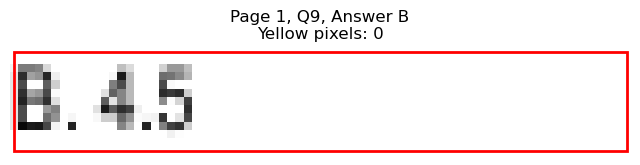

Page 1, Q9 - C: Detected box: x0=71.3, y0=724.3, x1=89.5, y1=736.4
Page 1, Q9, C: Yellow pixels: 143
Page 1, Q9, C: Total non-white pixels: 221
Page 1, Q9, C: Yellow percentage: 64.7%


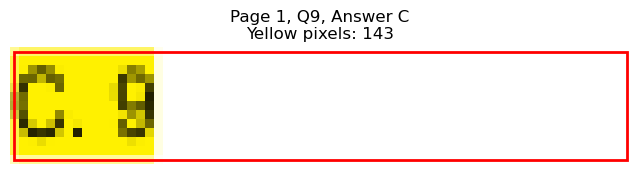

Page 1, Q9 - D: Detected box: x0=322.9, y0=700.3, x1=345.5, y1=712.3
Page 1, Q9, D: Yellow pixels: 0
Page 1, Q9, D: Total non-white pixels: 90
Page 1, Q9, D: Yellow percentage: 0.0%


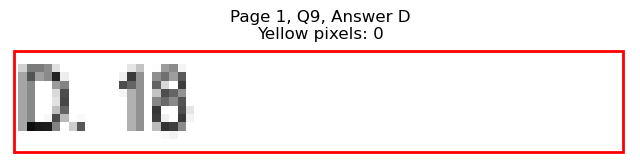

Page 1, Q9 - E: Detected box: x0=322.9, y0=712.3, x1=347.8, y1=724.4
Page 1, Q9, E: Yellow pixels: 0
Page 1, Q9, E: Total non-white pixels: 91
Page 1, Q9, E: Yellow percentage: 0.0%


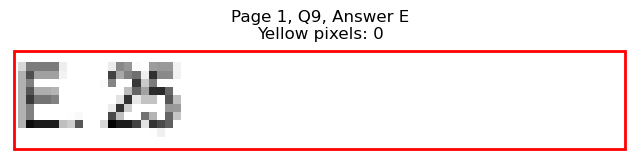


Page 1, Q9 - Selected Answer: C (based on yellow pixel count)





Page 2: Found 9 questions
Page 2, Q1 - A: Detected box: x0=129.8, y0=109.5, x1=192.3, y1=121.6
Page 2, Q1, A: Yellow pixels: 0
Page 2, Q1, A: Total non-white pixels: 318
Page 2, Q1, A: Yellow percentage: 0.0%


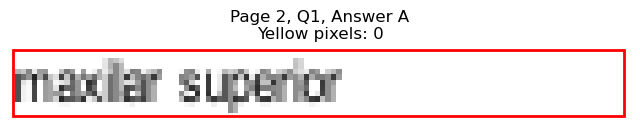

Page 2, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=248.7, y1=133.6
Page 2, Q1, B: Yellow pixels: 1566
Page 2, Q1, B: Total non-white pixels: 2288
Page 2, Q1, B: Yellow percentage: 68.4%


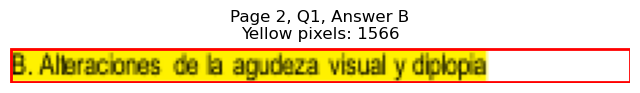

Page 2, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=185.5, y1=145.6
Page 2, Q1, C: Yellow pixels: 165
Page 2, Q1, C: Total non-white pixels: 710
Page 2, Q1, C: Yellow percentage: 23.2%


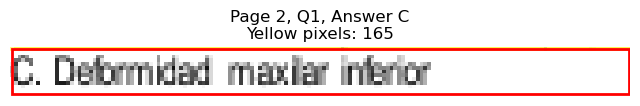

Page 2, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=458.0, y1=121.6
Page 2, Q1, D: Yellow pixels: 0
Page 2, Q1, D: Total non-white pixels: 667
Page 2, Q1, D: Yellow percentage: 0.0%


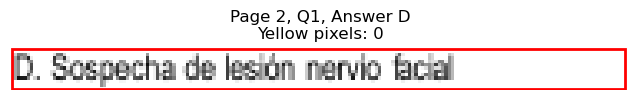

Page 2, Q1 - E: Detected box: x0=406.9, y0=121.5, x1=467.8, y1=133.6
Page 2, Q1, E: Yellow pixels: 0
Page 2, Q1, E: Total non-white pixels: 305
Page 2, Q1, E: Yellow percentage: 0.0%


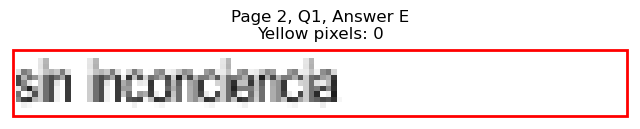


Page 2, Q1 - Selected Answer: B (based on yellow pixel count)




Page 2, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=145.0, y1=181.6
Page 2, Q2, A: Yellow pixels: 0
Page 2, Q2, A: Total non-white pixels: 310
Page 2, Q2, A: Yellow percentage: 0.0%


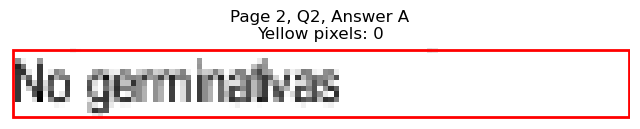

Page 2, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=121.7, y1=193.6
Page 2, Q2, B: Yellow pixels: 0
Page 2, Q2, B: Total non-white pixels: 244
Page 2, Q2, B: Yellow percentage: 0.0%


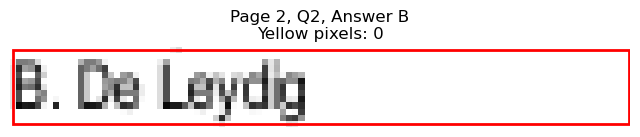

Page 2, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=121.0, y1=205.6
Page 2, Q2, C: Yellow pixels: 0
Page 2, Q2, C: Total non-white pixels: 221
Page 2, Q2, C: Yellow percentage: 0.0%


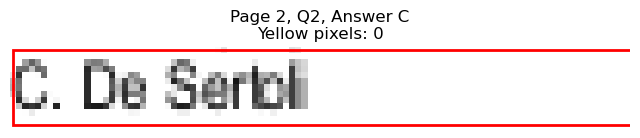

Page 2, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=385.4, y1=181.6
Page 2, Q2, D: Yellow pixels: 475
Page 2, Q2, D: Total non-white pixels: 793
Page 2, Q2, D: Yellow percentage: 59.9%


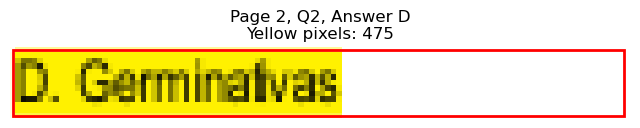

Page 2, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=360.5, y1=193.6
Page 2, Q2, E: Yellow pixels: 60
Page 2, Q2, E: Total non-white pixels: 226
Page 2, Q2, E: Yellow percentage: 26.5%


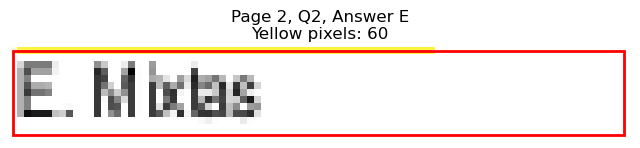


Page 2, Q2 - Selected Answer: D (based on yellow pixel count)




Page 2, Q3 - A: Detected box: x0=82.6, y0=229.6, x1=127.0, y1=241.7
Page 2, Q3, A: Yellow pixels: 0
Page 2, Q3, A: Total non-white pixels: 236
Page 2, Q3, A: Yellow percentage: 0.0%


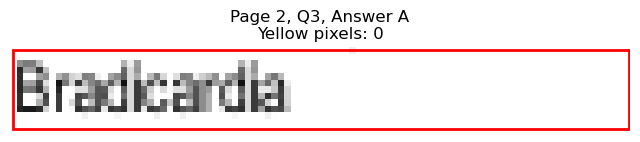

Page 2, Q3 - B: Detected box: x0=71.3, y0=241.6, x1=127.7, y1=253.7
Page 2, Q3, B: Yellow pixels: 0
Page 2, Q3, B: Total non-white pixels: 285
Page 2, Q3, B: Yellow percentage: 0.0%


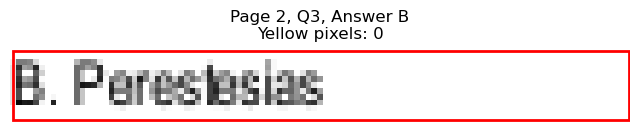

Page 2, Q3 - C: Detected box: x0=71.3, y0=253.6, x1=127.0, y1=265.7
Page 2, Q3, C: Yellow pixels: 415
Page 2, Q3, C: Total non-white pixels: 702
Page 2, Q3, C: Yellow percentage: 59.1%


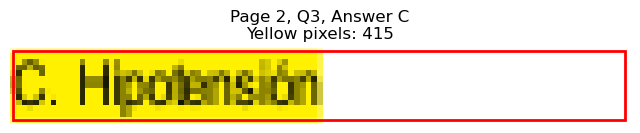

Page 2, Q3 - D: Detected box: x0=322.9, y0=229.6, x1=362.0, y1=241.7
Page 2, Q3, D: Yellow pixels: 0
Page 2, Q3, D: Total non-white pixels: 191
Page 2, Q3, D: Yellow percentage: 0.0%


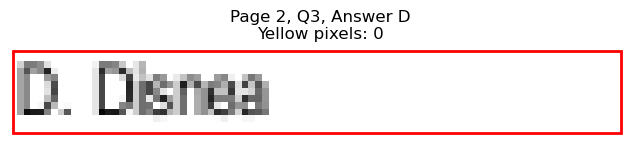

Page 2, Q3 - E: Detected box: x0=322.9, y0=241.6, x1=368.8, y1=253.7
Page 2, Q3, E: Yellow pixels: 0
Page 2, Q3, E: Total non-white pixels: 222
Page 2, Q3, E: Yellow percentage: 0.0%


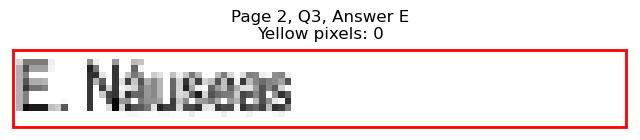


Page 2, Q3 - Selected Answer: C (based on yellow pixel count)




Page 2, Q4 - A: Detected box: x0=71.3, y0=338.5, x1=79.7, y1=350.5
Page 2, Q4, A: Yellow pixels: 0
Page 2, Q4, A: Total non-white pixels: 50
Page 2, Q4, A: Yellow percentage: 0.0%


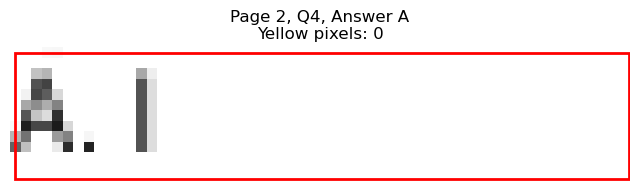

Page 2, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=91.0, y1=362.5
Page 2, Q4, B: Yellow pixels: 0
Page 2, Q4, B: Total non-white pixels: 82
Page 2, Q4, B: Yellow percentage: 0.0%


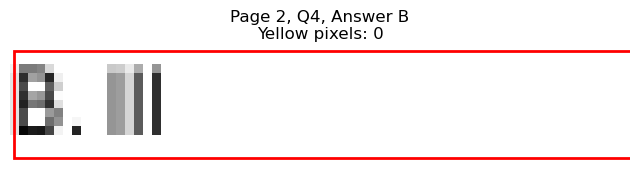

Page 2, Q4 - C: Detected box: x0=71.3, y0=362.5, x1=89.5, y1=374.6
Page 2, Q4, C: Yellow pixels: 157
Page 2, Q4, C: Total non-white pixels: 221
Page 2, Q4, C: Yellow percentage: 71.0%


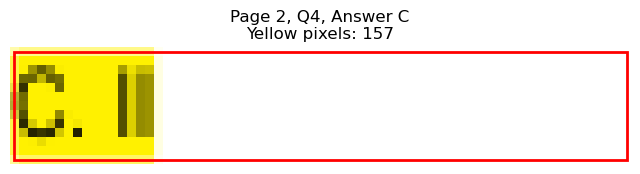

Page 2, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=344.0, y1=350.5
Page 2, Q4, D: Yellow pixels: 0
Page 2, Q4, D: Total non-white pixels: 75
Page 2, Q4, D: Yellow percentage: 0.0%


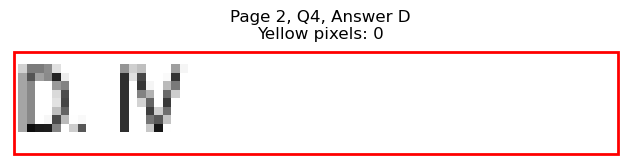

Page 2, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=341.0, y1=362.5
Page 2, Q4, E: Yellow pixels: 0
Page 2, Q4, E: Total non-white pixels: 64
Page 2, Q4, E: Yellow percentage: 0.0%


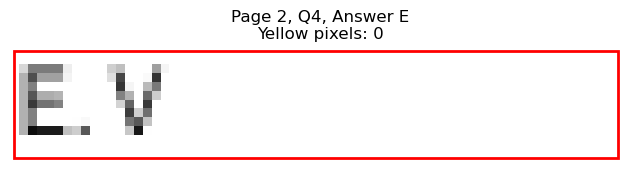


Page 2, Q4 - Selected Answer: C (based on yellow pixel count)




Page 2, Q5 - A: Detected box: x0=82.6, y0=410.5, x1=130.8, y1=422.6
Page 2, Q5, A: Yellow pixels: 0
Page 2, Q5, A: Total non-white pixels: 500
Page 2, Q5, A: Yellow percentage: 0.0%


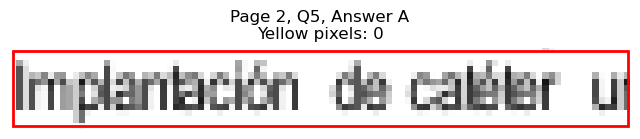

Page 2, Q5 - B: Detected box: x0=128.3, y0=422.5, x1=236.5, y1=434.6
Page 2, Q5, B: Yellow pixels: 0
Page 2, Q5, B: Total non-white pixels: 540
Page 2, Q5, B: Yellow percentage: 0.0%


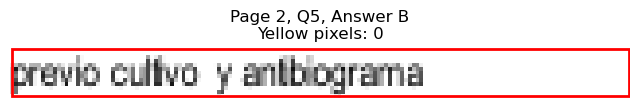

Page 2, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=135.2, y1=446.6
Page 2, Q5, C: Yellow pixels: 0
Page 2, Q5, C: Total non-white pixels: 575
Page 2, Q5, C: Yellow percentage: 0.0%


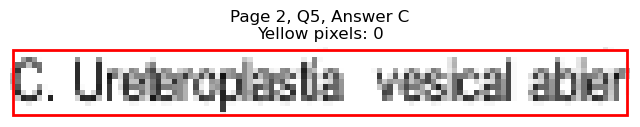

Page 2, Q5 - D: Detected box: x0=395.7, y0=410.5, x1=468.7, y1=422.6
Page 2, Q5, D: Yellow pixels: 566
Page 2, Q5, D: Total non-white pixels: 936
Page 2, Q5, D: Yellow percentage: 60.5%


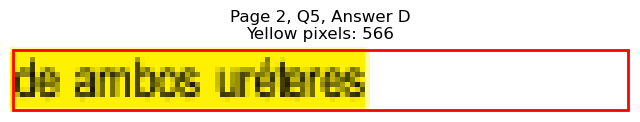

Page 2, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=401.0, y1=434.6
Page 2, Q5, E: Yellow pixels: 129
Page 2, Q5, E: Total non-white pixels: 779
Page 2, Q5, E: Yellow percentage: 16.6%


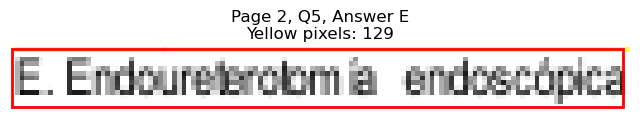


Page 2, Q5 - Selected Answer: D (based on yellow pixel count)




Page 2, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=151.7, y1=482.6
Page 2, Q6, A: Yellow pixels: 0
Page 2, Q6, A: Total non-white pixels: 353
Page 2, Q6, A: Yellow percentage: 0.0%


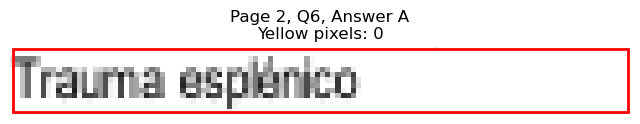

Page 2, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=154.0, y1=495.4
Page 2, Q6, B: Yellow pixels: 0
Page 2, Q6, B: Total non-white pixels: 417
Page 2, Q6, B: Yellow percentage: 0.0%


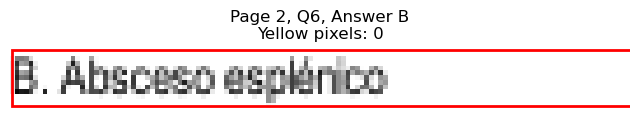

Page 2, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=179.5, y1=507.4
Page 2, Q6, C: Yellow pixels: 0
Page 2, Q6, C: Total non-white pixels: 662
Page 2, Q6, C: Yellow percentage: 0.0%


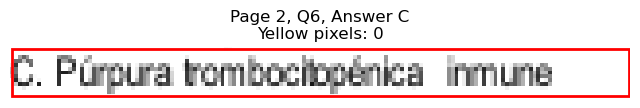

Page 2, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=398.0, y1=482.6
Page 2, Q6, D: Yellow pixels: 0
Page 2, Q6, D: Total non-white pixels: 383
Page 2, Q6, D: Yellow percentage: 0.0%


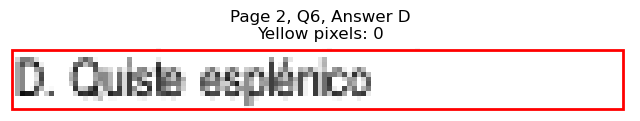

Page 2, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=457.5, y1=495.4
Page 2, Q6, E: Yellow pixels: 1143
Page 2, Q6, E: Total non-white pixels: 1742
Page 2, Q6, E: Yellow percentage: 65.6%


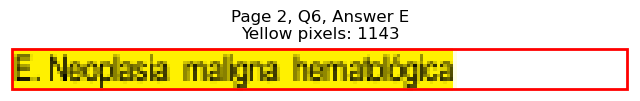


Page 2, Q6 - Selected Answer: E (based on yellow pixel count)




Page 2, Q7 - A: Detected box: x0=82.6, y0=531.4, x1=184.0, y1=543.5
Page 2, Q7, A: Yellow pixels: 0
Page 2, Q7, A: Total non-white pixels: 497
Page 2, Q7, A: Yellow percentage: 0.0%


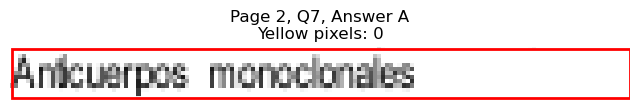

Page 2, Q7 - B: Detected box: x0=71.3, y0=543.4, x1=118.0, y1=555.5
Page 2, Q7, B: Yellow pixels: 646
Page 2, Q7, B: Total non-white pixels: 962
Page 2, Q7, B: Yellow percentage: 67.2%


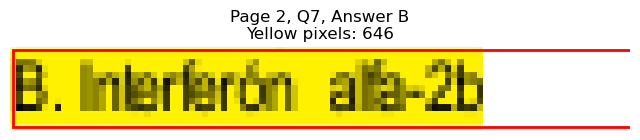

Page 2, Q7 - C: Detected box: x0=71.3, y0=555.4, x1=136.0, y1=567.5
Page 2, Q7, C: Yellow pixels: 73
Page 2, Q7, C: Total non-white pixels: 391
Page 2, Q7, C: Yellow percentage: 18.7%


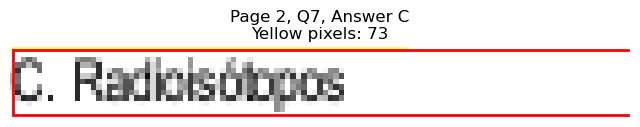

Page 2, Q7 - D: Detected box: x0=322.9, y0=531.4, x1=379.3, y1=543.5
Page 2, Q7, D: Yellow pixels: 0
Page 2, Q7, D: Total non-white pixels: 406
Page 2, Q7, D: Yellow percentage: 0.0%


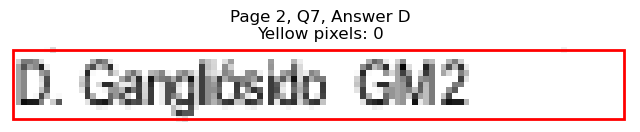

Page 2, Q7 - E: Detected box: x0=322.9, y0=543.4, x1=418.3, y1=555.5
Page 2, Q7, E: Yellow pixels: 0
Page 2, Q7, E: Total non-white pixels: 615
Page 2, Q7, E: Yellow percentage: 0.0%


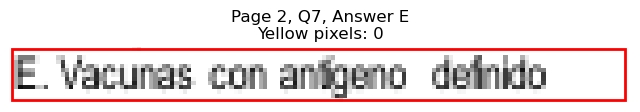


Page 2, Q7 - Selected Answer: B (based on yellow pixel count)




Page 2, Q8 - A: Detected box: x0=82.6, y0=627.5, x1=152.5, y1=639.6
Page 2, Q8, A: Yellow pixels: 0
Page 2, Q8, A: Total non-white pixels: 362
Page 2, Q8, A: Yellow percentage: 0.0%


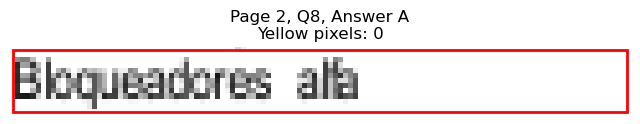

Page 2, Q8 - B: Detected box: x0=71.3, y0=639.5, x1=138.2, y1=651.6
Page 2, Q8, B: Yellow pixels: 1019
Page 2, Q8, B: Total non-white pixels: 1508
Page 2, Q8, B: Yellow percentage: 67.6%


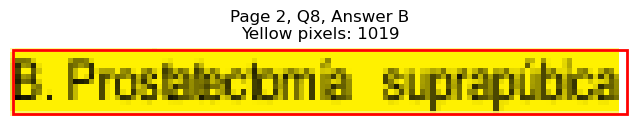

Page 2, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=177.2, y1=663.6
Page 2, Q8, C: Yellow pixels: 116
Page 2, Q8, C: Total non-white pixels: 629
Page 2, Q8, C: Yellow percentage: 18.4%


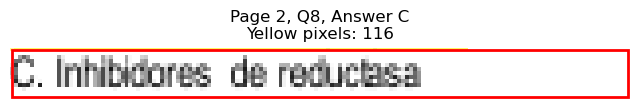

Page 2, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=419.0, y1=639.6
Page 2, Q8, D: Yellow pixels: 0
Page 2, Q8, D: Total non-white pixels: 498
Page 2, Q8, D: Yellow percentage: 0.0%


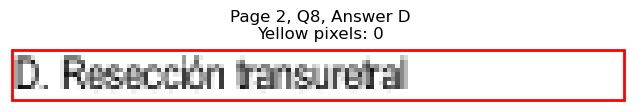

Page 2, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=383.1, y1=651.6
Page 2, Q8, E: Yellow pixels: 0
Page 2, Q8, E: Total non-white pixels: 469
Page 2, Q8, E: Yellow percentage: 0.0%


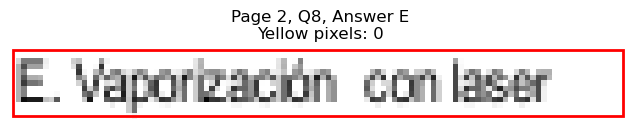


Page 2, Q8 - Selected Answer: B (based on yellow pixel count)




Page 2, Q9 - A: Detected box: x0=130.6, y0=712.3, x1=291.2, y1=724.4
Page 2, Q9, A: Yellow pixels: 0
Page 2, Q9, A: Total non-white pixels: 870
Page 2, Q9, A: Yellow percentage: 0.0%


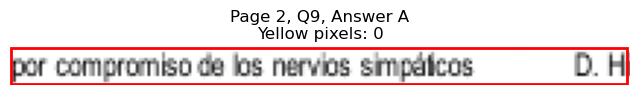

Page 2, Q9 - B: Detected box: x0=159.8, y0=724.3, x1=256.8, y1=736.4
Page 2, Q9, B: Yellow pixels: 0
Page 2, Q9, B: Total non-white pixels: 502
Page 2, Q9, B: Yellow percentage: 0.0%


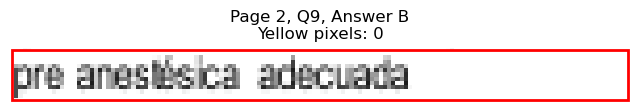

Page 2, Q9 - C: Detected box: x0=71.3, y0=736.4, x1=262.7, y1=748.4
Page 2, Q9, C: Yellow pixels: 1854
Page 2, Q9, C: Total non-white pixels: 2678
Page 2, Q9, C: Yellow percentage: 69.2%


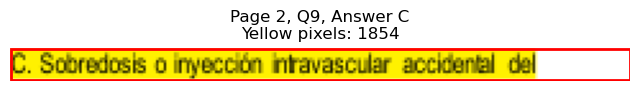

Page 2, Q9 - D: Detected box: x0=384.4, y0=712.3, x1=476.7, y1=724.4
Page 2, Q9, D: Yellow pixels: 0
Page 2, Q9, D: Total non-white pixels: 441
Page 2, Q9, D: Yellow percentage: 0.0%


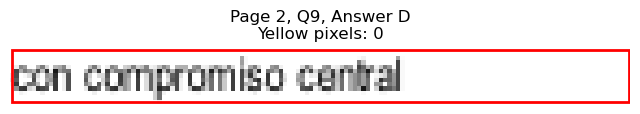

Page 2, Q9 - E: Detected box: x0=381.4, y0=724.3, x1=534.5, y1=736.4
Page 2, Q9, E: Yellow pixels: 0
Page 2, Q9, E: Total non-white pixels: 715
Page 2, Q9, E: Yellow percentage: 0.0%


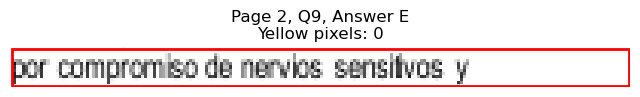


Page 2, Q9 - Selected Answer: C (based on yellow pixel count)





Page 3: Found 10 questions
Page 3, Q1 - A: Detected box: x0=82.6, y0=121.5, x1=166.7, y1=133.6
Page 3, Q1, A: Yellow pixels: 0
Page 3, Q1, A: Total non-white pixels: 431
Page 3, Q1, A: Yellow percentage: 0.0%


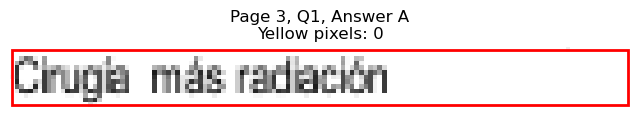

Page 3, Q1 - B: Detected box: x0=71.3, y0=133.5, x1=173.6, y1=145.6
Page 3, Q1, B: Yellow pixels: 781
Page 3, Q1, B: Total non-white pixels: 1313
Page 3, Q1, B: Yellow percentage: 59.5%


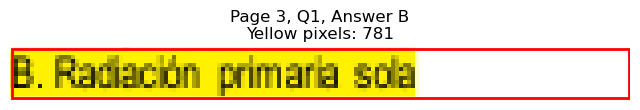

Page 3, Q1 - C: Detected box: x0=71.3, y0=145.6, x1=135.2, y1=157.6
Page 3, Q1, C: Yellow pixels: 100
Page 3, Q1, C: Total non-white pixels: 687
Page 3, Q1, C: Yellow percentage: 14.6%


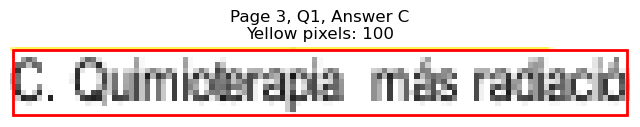

Page 3, Q1 - D: Detected box: x0=322.9, y0=121.5, x1=400.3, y1=133.6
Page 3, Q1, D: Yellow pixels: 0
Page 3, Q1, D: Total non-white pixels: 379
Page 3, Q1, D: Yellow percentage: 0.0%


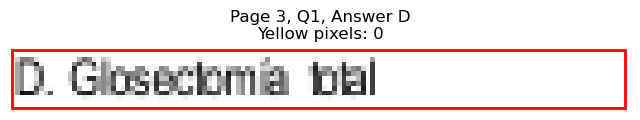

Page 3, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=386.8, y1=145.6
Page 3, Q1, E: Yellow pixels: 0
Page 3, Q1, E: Total non-white pixels: 305
Page 3, Q1, E: Yellow percentage: 0.0%


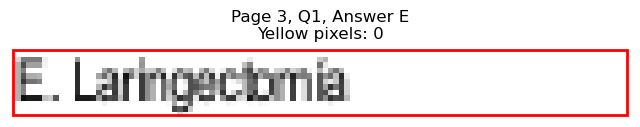


Page 3, Q1 - Selected Answer: B (based on yellow pixel count)




Page 3, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=122.5, y1=193.6
Page 3, Q2, A: Yellow pixels: 0
Page 3, Q2, A: Total non-white pixels: 201
Page 3, Q2, A: Yellow percentage: 0.0%


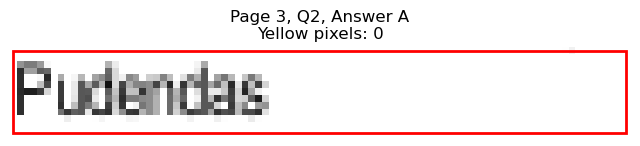

Page 3, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=114.2, y1=205.6
Page 3, Q2, B: Yellow pixels: 0
Page 3, Q2, B: Total non-white pixels: 209
Page 3, Q2, B: Yellow percentage: 0.0%


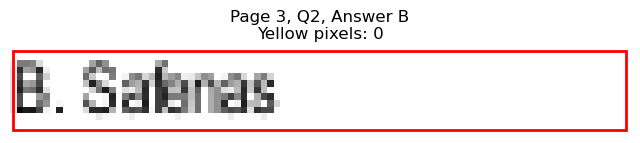

Page 3, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=136.1, y1=217.7
Page 3, Q2, C: Yellow pixels: 497
Page 3, Q2, C: Total non-white pixels: 819
Page 3, Q2, C: Yellow percentage: 60.7%


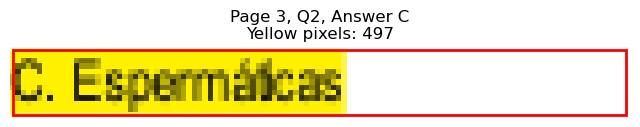

Page 3, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=381.5, y1=193.6
Page 3, Q2, D: Yellow pixels: 0
Page 3, Q2, D: Total non-white pixels: 313
Page 3, Q2, D: Yellow percentage: 0.0%


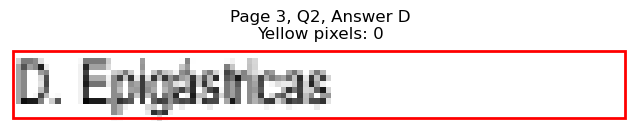

Page 3, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=377.8, y1=205.6
Page 3, Q2, E: Yellow pixels: 0
Page 3, Q2, E: Total non-white pixels: 281
Page 3, Q2, E: Yellow percentage: 0.0%


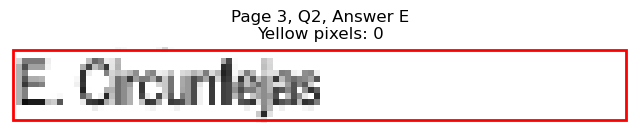


Page 3, Q2 - Selected Answer: C (based on yellow pixel count)




Page 3, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=94.0, y1=253.7
Page 3, Q3, A: Yellow pixels: 0
Page 3, Q3, A: Total non-white pixels: 47
Page 3, Q3, A: Yellow percentage: 0.0%


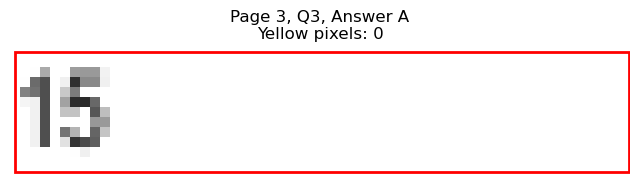

Page 3, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=93.2, y1=265.7
Page 3, Q3, B: Yellow pixels: 0
Page 3, Q3, B: Total non-white pixels: 100
Page 3, Q3, B: Yellow percentage: 0.0%


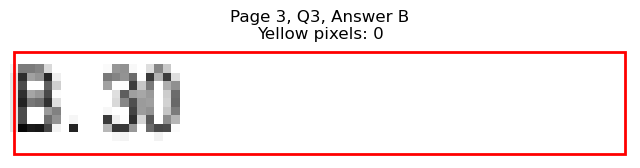

Page 3, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=98.5, y1=277.7
Page 3, Q3, C: Yellow pixels: 0
Page 3, Q3, C: Total non-white pixels: 98
Page 3, Q3, C: Yellow percentage: 0.0%


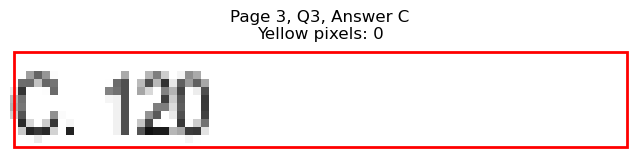

Page 3, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=345.6, y1=253.7
Page 3, Q3, D: Yellow pixels: 165
Page 3, Q3, D: Total non-white pixels: 286
Page 3, Q3, D: Yellow percentage: 57.7%


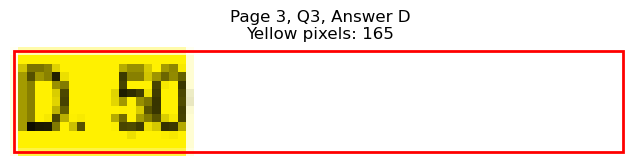

Page 3, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=349.3, y1=265.7
Page 3, Q3, E: Yellow pixels: 20
Page 3, Q3, E: Total non-white pixels: 134
Page 3, Q3, E: Yellow percentage: 14.9%


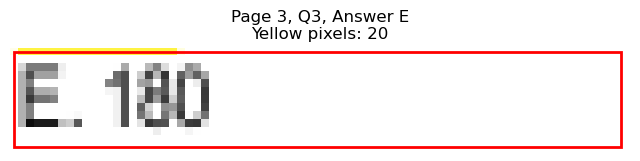


Page 3, Q3 - Selected Answer: D (based on yellow pixel count)




Page 3, Q4 - A: Detected box: x0=82.6, y0=302.5, x1=115.7, y1=314.5
Page 3, Q4, A: Yellow pixels: 0
Page 3, Q4, A: Total non-white pixels: 174
Page 3, Q4, A: Yellow percentage: 0.0%


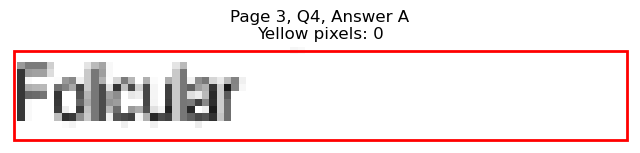

Page 3, Q4 - B: Detected box: x0=71.3, y0=314.5, x1=153.2, y1=326.5
Page 3, Q4, B: Yellow pixels: 0
Page 3, Q4, B: Total non-white pixels: 412
Page 3, Q4, B: Yellow percentage: 0.0%


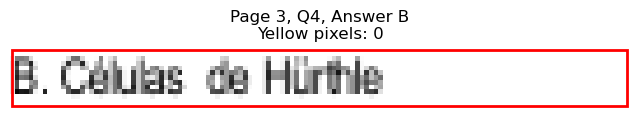

Page 3, Q4 - C: Detected box: x0=71.3, y0=326.5, x1=115.7, y1=338.5
Page 3, Q4, C: Yellow pixels: 0
Page 3, Q4, C: Total non-white pixels: 196
Page 3, Q4, C: Yellow percentage: 0.0%


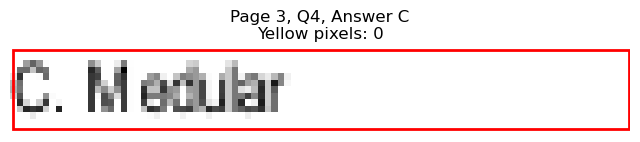

Page 3, Q4 - D: Detected box: x0=322.9, y0=302.5, x1=362.1, y1=314.5
Page 3, Q4, D: Yellow pixels: 327
Page 3, Q4, D: Total non-white pixels: 496
Page 3, Q4, D: Yellow percentage: 65.9%


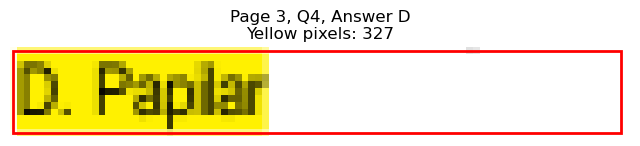

Page 3, Q4 - E: Detected box: x0=322.9, y0=314.5, x1=376.3, y1=326.5
Page 3, Q4, E: Yellow pixels: 36
Page 3, Q4, E: Total non-white pixels: 305
Page 3, Q4, E: Yellow percentage: 11.8%


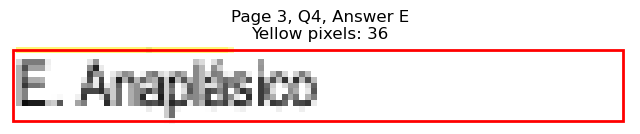


Page 3, Q4 - Selected Answer: D (based on yellow pixel count)




Page 3, Q5 - A: Detected box: x0=82.6, y0=362.5, x1=122.5, y1=374.6
Page 3, Q5, A: Yellow pixels: 0
Page 3, Q5, A: Total non-white pixels: 222
Page 3, Q5, A: Yellow percentage: 0.0%


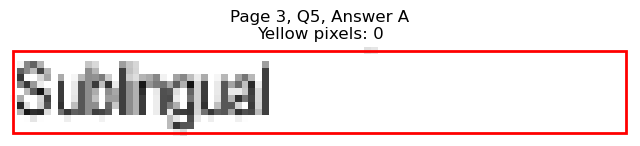

Page 3, Q5 - B: Detected box: x0=71.3, y0=374.5, x1=126.2, y1=386.6
Page 3, Q5, B: Yellow pixels: 0
Page 3, Q5, B: Total non-white pixels: 283
Page 3, Q5, B: Yellow percentage: 0.0%


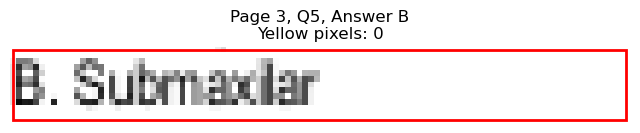

Page 3, Q5 - C: Detected box: x0=71.3, y0=386.5, x1=115.0, y1=398.6
Page 3, Q5, C: Yellow pixels: 340
Page 3, Q5, C: Total non-white pixels: 546
Page 3, Q5, C: Yellow percentage: 62.3%


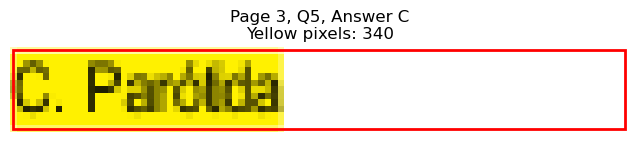

Page 3, Q5 - D: Detected box: x0=322.9, y0=362.5, x1=365.0, y1=374.6
Page 3, Q5, D: Yellow pixels: 0
Page 3, Q5, D: Total non-white pixels: 203
Page 3, Q5, D: Yellow percentage: 0.0%


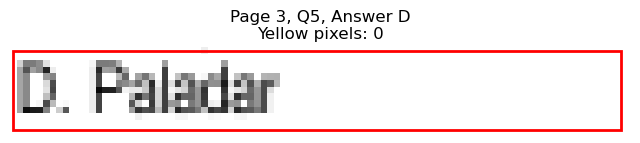

Page 3, Q5 - E: Detected box: x0=322.9, y0=374.5, x1=449.8, y1=386.6
Page 3, Q5, E: Yellow pixels: 0
Page 3, Q5, E: Total non-white pixels: 628
Page 3, Q5, E: Yellow percentage: 0.0%


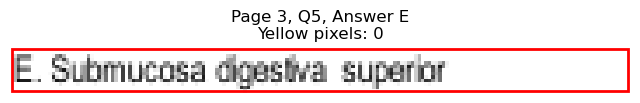


Page 3, Q5 - Selected Answer: C (based on yellow pixel count)




Page 3, Q6 - A: Detected box: x0=82.6, y0=422.5, x1=157.8, y1=434.6
Page 3, Q6, A: Yellow pixels: 0
Page 3, Q6, A: Total non-white pixels: 635
Page 3, Q6, A: Yellow percentage: 0.0%


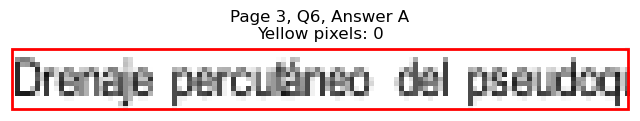

Page 3, Q6 - B: Detected box: x0=71.3, y0=434.6, x1=150.2, y1=446.6
Page 3, Q6, B: Yellow pixels: 0
Page 3, Q6, B: Total non-white pixels: 593
Page 3, Q6, B: Yellow percentage: 0.0%


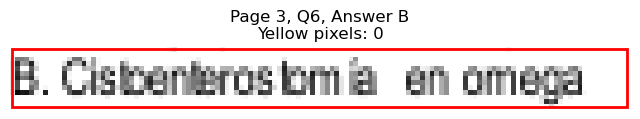

Page 3, Q6 - C: Detected box: x0=71.3, y0=446.6, x1=159.2, y1=458.6
Page 3, Q6, C: Yellow pixels: 0
Page 3, Q6, C: Total non-white pixels: 443
Page 3, Q6, C: Yellow percentage: 0.0%


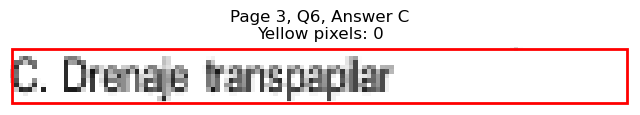

Page 3, Q6 - D: Detected box: x0=373.9, y0=422.5, x1=520.5, y1=434.6
Page 3, Q6, D: Yellow pixels: 0
Page 3, Q6, D: Total non-white pixels: 741
Page 3, Q6, D: Yellow percentage: 0.0%


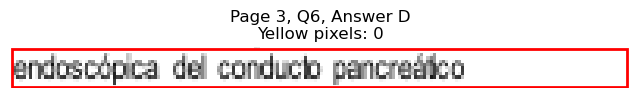

Page 3, Q6 - E: Detected box: x0=383.0, y0=434.6, x1=476.2, y1=446.6
Page 3, Q6, E: Yellow pixels: 768
Page 3, Q6, E: Total non-white pixels: 1198
Page 3, Q6, E: Yellow percentage: 64.1%


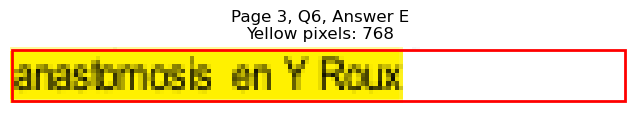


Page 3, Q6 - Selected Answer: E (based on yellow pixel count)




Page 3, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=125.5, y1=519.4
Page 3, Q7, A: Yellow pixels: 326
Page 3, Q7, A: Total non-white pixels: 546
Page 3, Q7, A: Yellow percentage: 59.7%


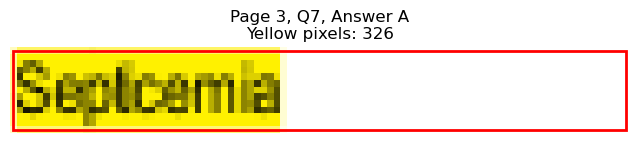

Page 3, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=126.2, y1=531.4
Page 3, Q7, B: Yellow pixels: 40
Page 3, Q7, B: Total non-white pixels: 322
Page 3, Q7, B: Yellow percentage: 12.4%


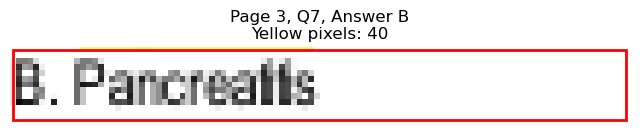

Page 3, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=189.2, y1=543.5
Page 3, Q7, C: Yellow pixels: 0
Page 3, Q7, C: Total non-white pixels: 553
Page 3, Q7, C: Yellow percentage: 0.0%


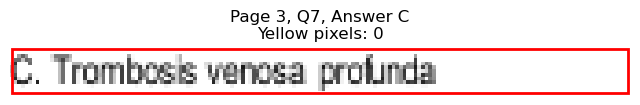

Page 3, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=380.0, y1=519.4
Page 3, Q7, D: Yellow pixels: 0
Page 3, Q7, D: Total non-white pixels: 287
Page 3, Q7, D: Yellow percentage: 0.0%


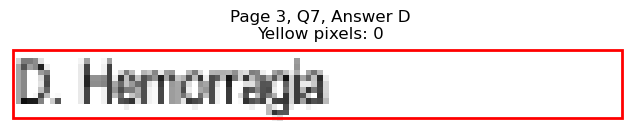

Page 3, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=433.3, y1=531.4
Page 3, Q7, E: Yellow pixels: 0
Page 3, Q7, E: Total non-white pixels: 584
Page 3, Q7, E: Yellow percentage: 0.0%


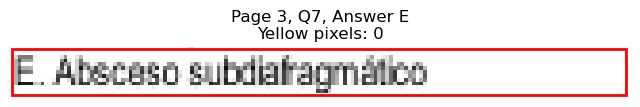


Page 3, Q7 - Selected Answer: A (based on yellow pixel count)




Page 3, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=103.7, y1=579.5
Page 3, Q8, A: Yellow pixels: 0
Page 3, Q8, A: Total non-white pixels: 69
Page 3, Q8, A: Yellow percentage: 0.0%


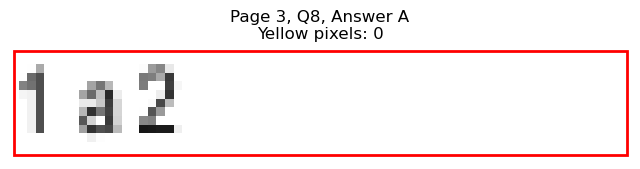

Page 3, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=103.0, y1=591.5
Page 3, Q8, B: Yellow pixels: 0
Page 3, Q8, B: Total non-white pixels: 125
Page 3, Q8, B: Yellow percentage: 0.0%


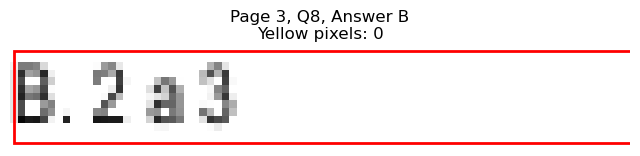

Page 3, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=98.5, y1=603.5
Page 3, Q8, C: Yellow pixels: 0
Page 3, Q8, C: Total non-white pixels: 105
Page 3, Q8, C: Yellow percentage: 0.0%


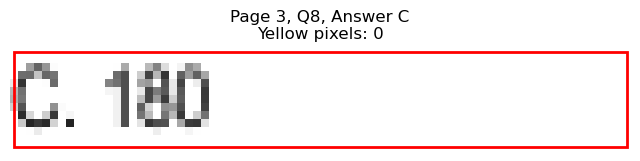

Page 3, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=359.8, y1=579.5
Page 3, Q8, D: Yellow pixels: 344
Page 3, Q8, D: Total non-white pixels: 468
Page 3, Q8, D: Yellow percentage: 73.5%


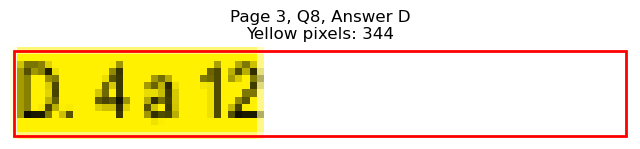

Page 3, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=349.3, y1=591.5
Page 3, Q8, E: Yellow pixels: 34
Page 3, Q8, E: Total non-white pixels: 155
Page 3, Q8, E: Yellow percentage: 21.9%


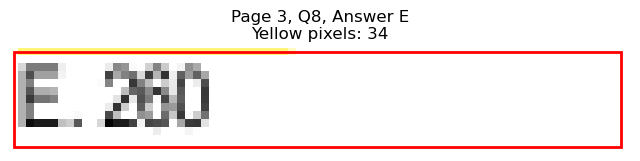


Page 3, Q8 - Selected Answer: D (based on yellow pixel count)




Page 3, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=106.0, y1=639.6
Page 3, Q9, A: Yellow pixels: 0
Page 3, Q9, A: Total non-white pixels: 119
Page 3, Q9, A: Yellow percentage: 0.0%


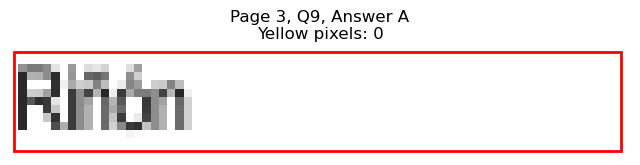

Page 3, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=112.7, y1=651.6
Page 3, Q9, B: Yellow pixels: 0
Page 3, Q9, B: Total non-white pixels: 193
Page 3, Q9, B: Yellow percentage: 0.0%


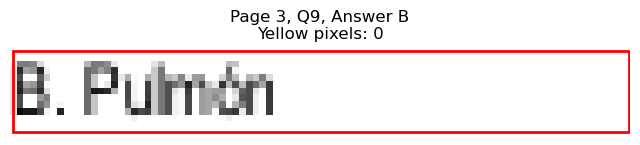

Page 3, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=113.5, y1=663.6
Page 3, Q9, C: Yellow pixels: 0
Page 3, Q9, C: Total non-white pixels: 172
Page 3, Q9, C: Yellow percentage: 0.0%


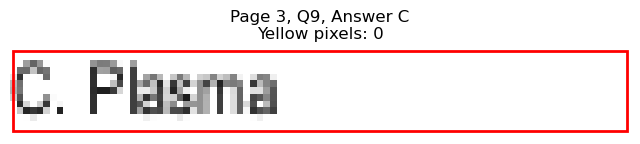

Page 3, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=365.8, y1=639.6
Page 3, Q9, D: Yellow pixels: 0
Page 3, Q9, D: Total non-white pixels: 204
Page 3, Q9, D: Yellow percentage: 0.0%


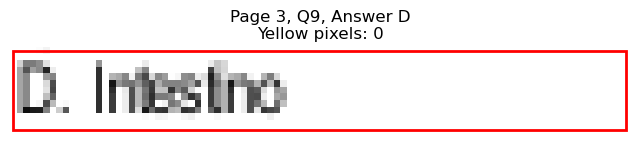

Page 3, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=361.3, y1=651.6
Page 3, Q9, E: Yellow pixels: 320
Page 3, Q9, E: Total non-white pixels: 481
Page 3, Q9, E: Yellow percentage: 66.5%


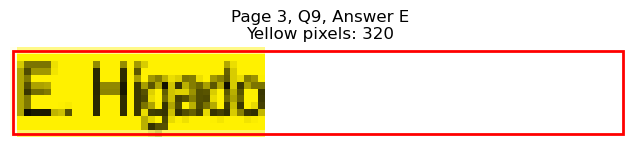


Page 3, Q9 - Selected Answer: E (based on yellow pixel count)




Page 3, Q10 - A: Detected box: x0=82.6, y0=688.3, x1=110.5, y1=700.3
Page 3, Q10, A: Yellow pixels: 0
Page 3, Q10, A: Total non-white pixels: 143
Page 3, Q10, A: Yellow percentage: 0.0%


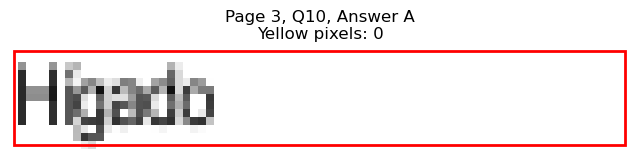

Page 3, Q10 - B: Detected box: x0=71.3, y0=700.3, x1=111.3, y1=712.3
Page 3, Q10, B: Yellow pixels: 301
Page 3, Q10, B: Total non-white pixels: 494
Page 3, Q10, B: Yellow percentage: 60.9%


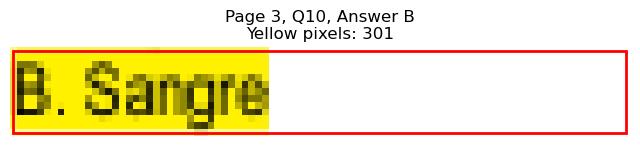

Page 3, Q10 - C: Detected box: x0=71.3, y0=712.3, x1=106.0, y1=724.4
Page 3, Q10, C: Yellow pixels: 2
Page 3, Q10, C: Total non-white pixels: 187
Page 3, Q10, C: Yellow percentage: 1.1%


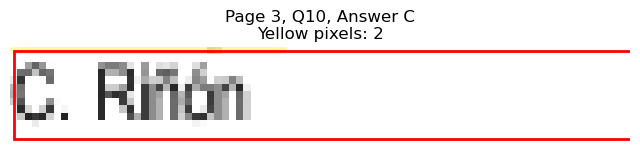

Page 3, Q10 - D: Detected box: x0=322.9, y0=688.3, x1=374.0, y1=700.3
Page 3, Q10, D: Yellow pixels: 0
Page 3, Q10, D: Total non-white pixels: 235
Page 3, Q10, D: Yellow percentage: 0.0%


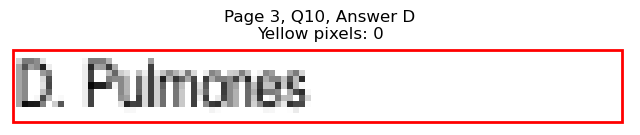

Page 3, Q10 - E: Detected box: x0=322.9, y0=700.3, x1=365.0, y1=712.3
Page 3, Q10, E: Yellow pixels: 0
Page 3, Q10, E: Total non-white pixels: 206
Page 3, Q10, E: Yellow percentage: 0.0%


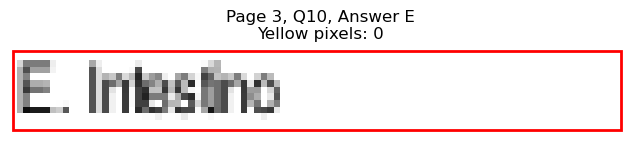


Page 3, Q10 - Selected Answer: B (based on yellow pixel count)





Page 4: Found 10 questions
Page 4, Q1 - A: Detected box: x0=145.6, y0=109.5, x1=251.5, y1=121.6
Page 4, Q1, A: Yellow pixels: 0
Page 4, Q1, A: Total non-white pixels: 501
Page 4, Q1, A: Yellow percentage: 0.0%


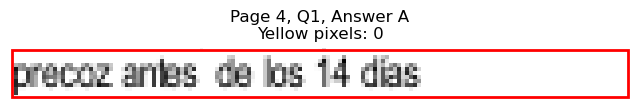

Page 4, Q1 - B: Detected box: x0=129.9, y0=121.5, x1=208.7, y1=133.6
Page 4, Q1, B: Yellow pixels: 0
Page 4, Q1, B: Total non-white pixels: 388
Page 4, Q1, B: Yellow percentage: 0.0%


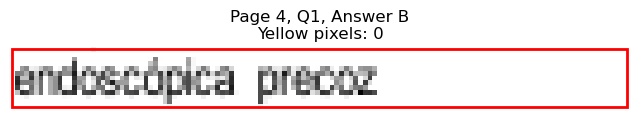

Page 4, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=216.2, y1=145.6
Page 4, Q1, C: Yellow pixels: 0
Page 4, Q1, C: Total non-white pixels: 683
Page 4, Q1, C: Yellow percentage: 0.0%


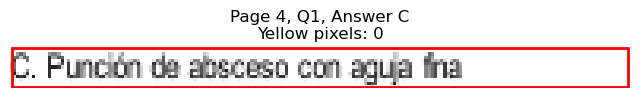

Page 4, Q1 - D: Detected box: x0=421.1, y0=109.5, x1=502.3, y1=121.6
Page 4, Q1, D: Yellow pixels: 701
Page 4, Q1, D: Total non-white pixels: 1040
Page 4, Q1, D: Yellow percentage: 67.4%


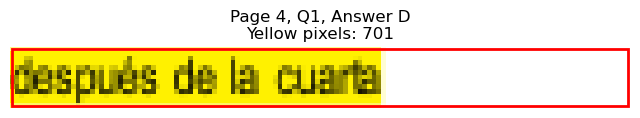

Page 4, Q1 - E: Detected box: x0=322.9, y0=133.5, x1=408.5, y1=145.6
Page 4, Q1, E: Yellow pixels: 30
Page 4, Q1, E: Total non-white pixels: 694
Page 4, Q1, E: Yellow percentage: 4.3%


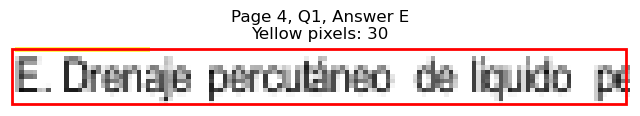


Page 4, Q1 - Selected Answer: D (based on yellow pixel count)




Page 4, Q2 - A: Detected box: x0=183.8, y0=169.6, x1=263.0, y1=181.6
Page 4, Q2, A: Yellow pixels: 0
Page 4, Q2, A: Total non-white pixels: 388
Page 4, Q2, A: Yellow percentage: 0.0%


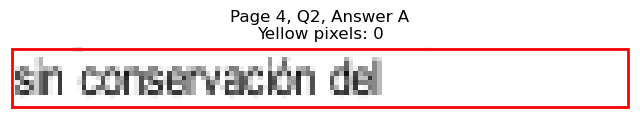

Page 4, Q2 - B: Detected box: x0=183.0, y0=193.6, x1=265.7, y1=205.6
Page 4, Q2, B: Yellow pixels: 672
Page 4, Q2, B: Total non-white pixels: 1053
Page 4, Q2, B: Yellow percentage: 63.8%


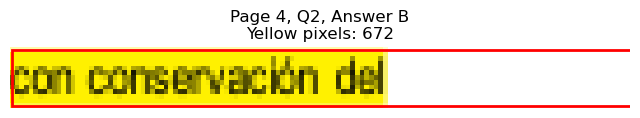

Page 4, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=196.0, y1=229.7
Page 4, Q2, C: Yellow pixels: 44
Page 4, Q2, C: Total non-white pixels: 633
Page 4, Q2, C: Yellow percentage: 7.0%


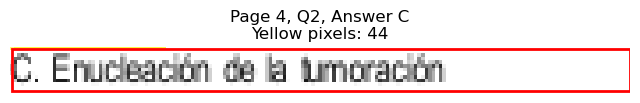

Page 4, Q2 - D: Detected box: x0=412.9, y0=169.6, x1=519.8, y1=181.6
Page 4, Q2, D: Yellow pixels: 0
Page 4, Q2, D: Total non-white pixels: 503
Page 4, Q2, D: Yellow percentage: 0.0%


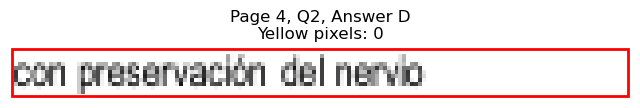

Page 4, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=389.8, y1=205.6
Page 4, Q2, E: Yellow pixels: 0
Page 4, Q2, E: Total non-white pixels: 552
Page 4, Q2, E: Yellow percentage: 0.0%


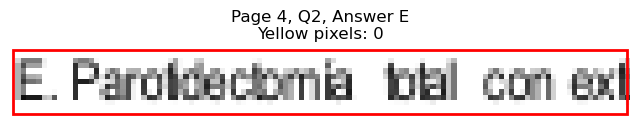


Page 4, Q2 - Selected Answer: B (based on yellow pixel count)




Page 4, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=131.5, y1=265.7
Page 4, Q3, A: Yellow pixels: 0
Page 4, Q3, A: Total non-white pixels: 236
Page 4, Q3, A: Yellow percentage: 0.0%


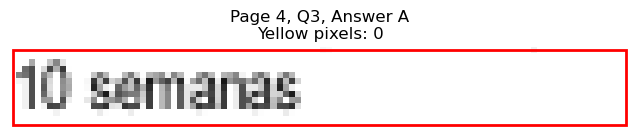

Page 4, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=117.2, y1=277.7
Page 4, Q3, B: Yellow pixels: 0
Page 4, Q3, B: Total non-white pixels: 215
Page 4, Q3, B: Yellow percentage: 0.0%


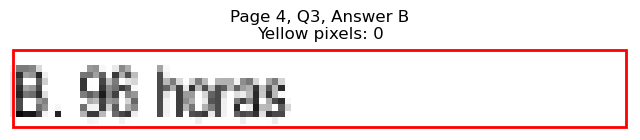

Page 4, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=118.0, y1=289.7
Page 4, Q3, C: Yellow pixels: 392
Page 4, Q3, C: Total non-white pixels: 585
Page 4, Q3, C: Yellow percentage: 67.0%


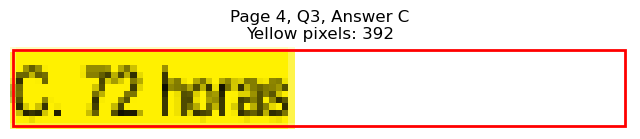

Page 4, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=374.0, y1=265.7
Page 4, Q3, D: Yellow pixels: 0
Page 4, Q3, D: Total non-white pixels: 225
Page 4, Q3, D: Yellow percentage: 0.0%


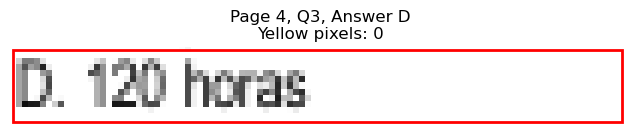

Page 4, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=377.8, y1=277.7
Page 4, Q3, E: Yellow pixels: 0
Page 4, Q3, E: Total non-white pixels: 257
Page 4, Q3, E: Yellow percentage: 0.0%


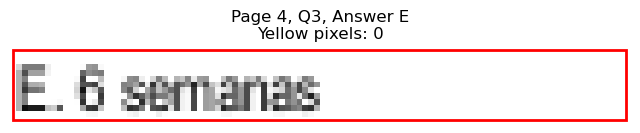


Page 4, Q3 - Selected Answer: C (based on yellow pixel count)




Page 4, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=133.8, y1=338.5
Page 4, Q4, A: Yellow pixels: 0
Page 4, Q4, A: Total non-white pixels: 282
Page 4, Q4, A: Yellow percentage: 0.0%


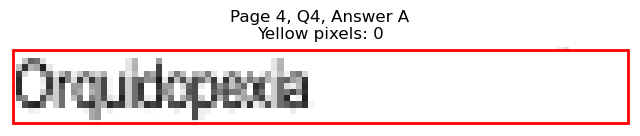

Page 4, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=137.6, y1=350.5
Page 4, Q4, B: Yellow pixels: 581
Page 4, Q4, B: Total non-white pixels: 845
Page 4, Q4, B: Yellow percentage: 68.8%


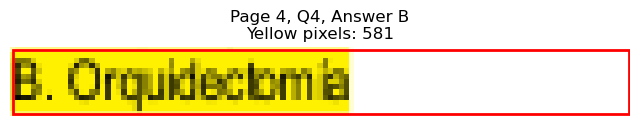

Page 4, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=159.2, y1=362.5
Page 4, Q4, C: Yellow pixels: 64
Page 4, Q4, C: Total non-white pixels: 487
Page 4, Q4, C: Yellow percentage: 13.1%


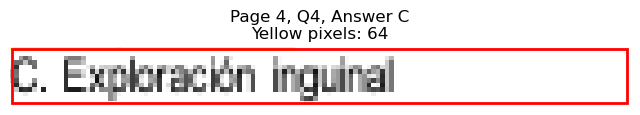

Page 4, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=407.8, y1=338.5
Page 4, Q4, D: Yellow pixels: 0
Page 4, Q4, D: Total non-white pixels: 436
Page 4, Q4, D: Yellow percentage: 0.0%


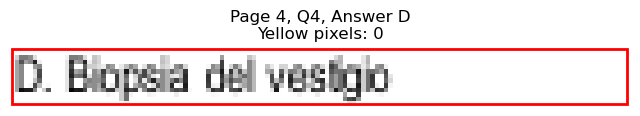

Page 4, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=385.3, y1=350.5
Page 4, Q4, E: Yellow pixels: 0
Page 4, Q4, E: Total non-white pixels: 299
Page 4, Q4, E: Yellow percentage: 0.0%


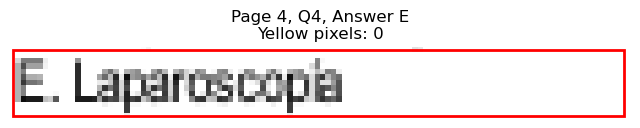


Page 4, Q4 - Selected Answer: B (based on yellow pixel count)




Page 4, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=139.0, y1=398.6
Page 4, Q5, A: Yellow pixels: 0
Page 4, Q5, A: Total non-white pixels: 285
Page 4, Q5, A: Yellow percentage: 0.0%


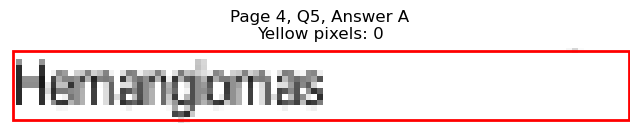

Page 4, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=124.7, y1=410.6
Page 4, Q5, B: Yellow pixels: 0
Page 4, Q5, B: Total non-white pixels: 257
Page 4, Q5, B: Yellow percentage: 0.0%


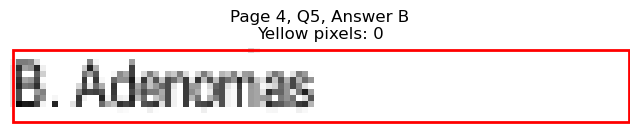

Page 4, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=112.8, y1=422.6
Page 4, Q5, C: Yellow pixels: 312
Page 4, Q5, C: Total non-white pixels: 520
Page 4, Q5, C: Yellow percentage: 60.0%


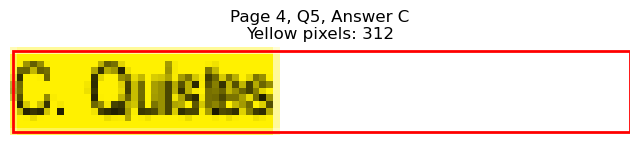

Page 4, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=429.7, y1=398.6
Page 4, Q5, D: Yellow pixels: 0
Page 4, Q5, D: Total non-white pixels: 543
Page 4, Q5, D: Yellow percentage: 0.0%


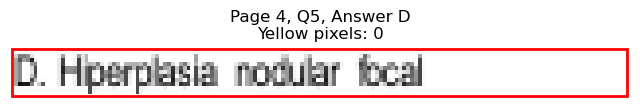

Page 4, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=383.7, y1=410.6
Page 4, Q5, E: Yellow pixels: 0
Page 4, Q5, E: Total non-white pixels: 293
Page 4, Q5, E: Yellow percentage: 0.0%


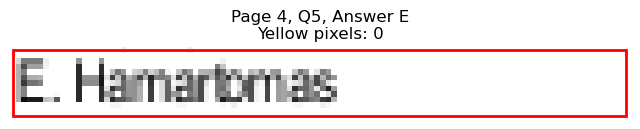


Page 4, Q5 - Selected Answer: C (based on yellow pixel count)




Page 4, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=141.2, y1=458.6
Page 4, Q6, A: Yellow pixels: 0
Page 4, Q6, A: Total non-white pixels: 278
Page 4, Q6, A: Yellow percentage: 0.0%


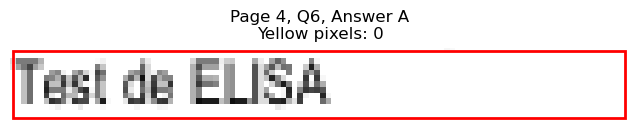

Page 4, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=160.7, y1=470.6
Page 4, Q6, B: Yellow pixels: 0
Page 4, Q6, B: Total non-white pixels: 462
Page 4, Q6, B: Yellow percentage: 0.0%


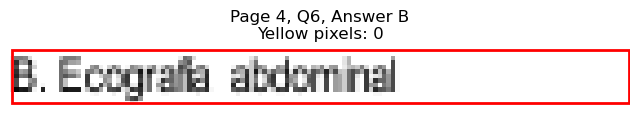

Page 4, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=139.0, y1=482.6
Page 4, Q6, C: Yellow pixels: 0
Page 4, Q6, C: Total non-white pixels: 305
Page 4, Q6, C: Yellow percentage: 0.0%


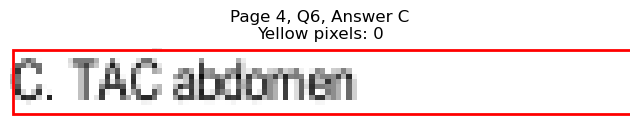

Page 4, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=421.3, y1=458.6
Page 4, Q6, D: Yellow pixels: 0
Page 4, Q6, D: Total non-white pixels: 512
Page 4, Q6, D: Yellow percentage: 0.0%


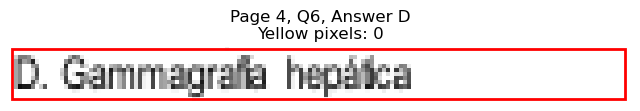

Page 4, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=431.9, y1=470.6
Page 4, Q6, E: Yellow pixels: 835
Page 4, Q6, E: Total non-white pixels: 1404
Page 4, Q6, E: Yellow percentage: 59.5%


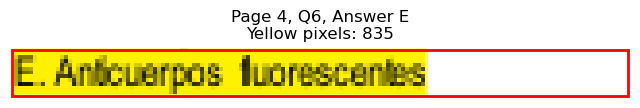


Page 4, Q6 - Selected Answer: E (based on yellow pixel count)




Page 4, Q7 - A: Detected box: x0=82.6, y0=507.4, x1=182.5, y1=519.4
Page 4, Q7, A: Yellow pixels: 0
Page 4, Q7, A: Total non-white pixels: 484
Page 4, Q7, A: Yellow percentage: 0.0%


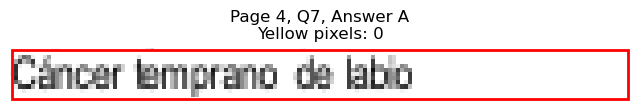

Page 4, Q7 - B: Detected box: x0=71.3, y0=519.4, x1=196.7, y1=531.4
Page 4, Q7, B: Yellow pixels: 0
Page 4, Q7, B: Total non-white pixels: 632
Page 4, Q7, B: Yellow percentage: 0.0%


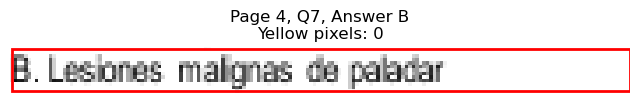

Page 4, Q7 - C: Detected box: x0=71.3, y0=531.4, x1=214.0, y1=543.5
Page 4, Q7, C: Yellow pixels: 0
Page 4, Q7, C: Total non-white pixels: 702
Page 4, Q7, C: Yellow percentage: 0.0%


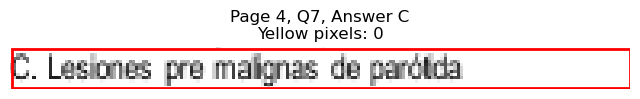

Page 4, Q7 - D: Detected box: x0=322.9, y0=507.4, x1=426.5, y1=519.4
Page 4, Q7, D: Yellow pixels: 0
Page 4, Q7, D: Total non-white pixels: 505
Page 4, Q7, D: Yellow percentage: 0.0%


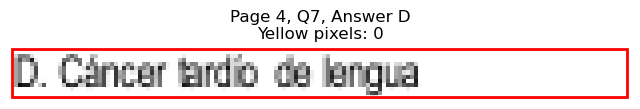

Page 4, Q7 - E: Detected box: x0=322.9, y0=519.4, x1=440.9, y1=531.4
Page 4, Q7, E: Yellow pixels: 1031
Page 4, Q7, E: Total non-white pixels: 1521
Page 4, Q7, E: Yellow percentage: 67.8%


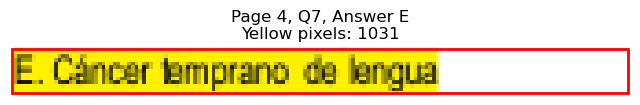


Page 4, Q7 - Selected Answer: E (based on yellow pixel count)




Page 4, Q8 - A: Detected box: x0=82.6, y0=579.4, x1=196.0, y1=591.5
Page 4, Q8, A: Yellow pixels: 0
Page 4, Q8, A: Total non-white pixels: 573
Page 4, Q8, A: Yellow percentage: 0.0%


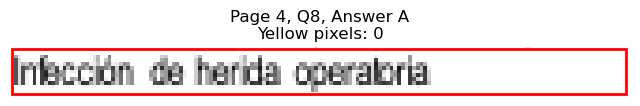

Page 4, Q8 - B: Detected box: x0=71.3, y0=591.5, x1=109.0, y1=603.5
Page 4, Q8, B: Yellow pixels: 0
Page 4, Q8, B: Total non-white pixels: 195
Page 4, Q8, B: Yellow percentage: 0.0%


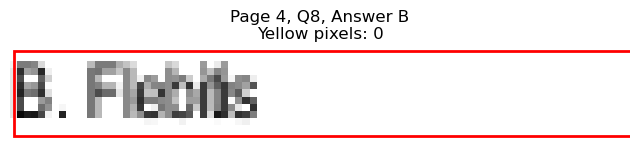

Page 4, Q8 - C: Detected box: x0=71.3, y0=603.5, x1=172.9, y1=615.5
Page 4, Q8, C: Yellow pixels: 890
Page 4, Q8, C: Total non-white pixels: 1300
Page 4, Q8, C: Yellow percentage: 68.5%


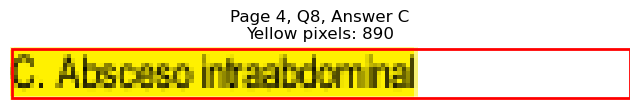

Page 4, Q8 - D: Detected box: x0=322.9, y0=579.4, x1=371.8, y1=591.5
Page 4, Q8, D: Yellow pixels: 0
Page 4, Q8, D: Total non-white pixels: 260
Page 4, Q8, D: Yellow percentage: 0.0%


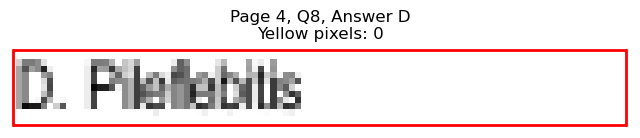

Page 4, Q8 - E: Detected box: x0=322.9, y0=591.5, x1=392.8, y1=603.5
Page 4, Q8, E: Yellow pixels: 0
Page 4, Q8, E: Total non-white pixels: 346
Page 4, Q8, E: Yellow percentage: 0.0%


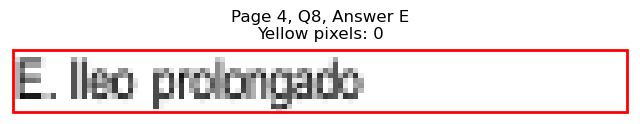


Page 4, Q8 - Selected Answer: C (based on yellow pixel count)




Page 4, Q9 - A: Detected box: x0=82.6, y0=639.5, x1=193.7, y1=651.6
Page 4, Q9, A: Yellow pixels: 0
Page 4, Q9, A: Total non-white pixels: 556
Page 4, Q9, A: Yellow percentage: 0.0%


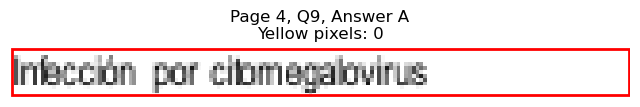

Page 4, Q9 - B: Detected box: x0=71.3, y0=651.5, x1=188.5, y1=663.6
Page 4, Q9, B: Yellow pixels: 0
Page 4, Q9, B: Total non-white pixels: 574
Page 4, Q9, B: Yellow percentage: 0.0%


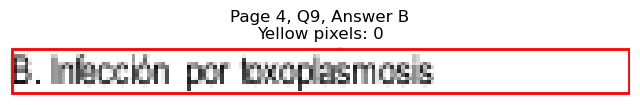

Page 4, Q9 - C: Detected box: x0=71.3, y0=663.5, x1=152.5, y1=675.6
Page 4, Q9, C: Yellow pixels: 0
Page 4, Q9, C: Total non-white pixels: 416
Page 4, Q9, C: Yellow percentage: 0.0%


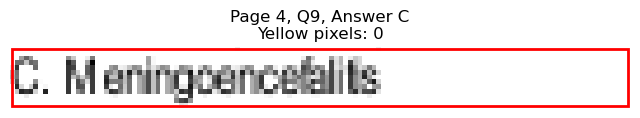

Page 4, Q9 - D: Detected box: x0=322.9, y0=639.5, x1=419.0, y1=651.6
Page 4, Q9, D: Yellow pixels: 0
Page 4, Q9, D: Total non-white pixels: 484
Page 4, Q9, D: Yellow percentage: 0.0%


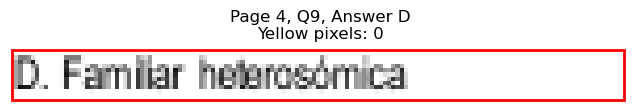

Page 4, Q9 - E: Detected box: x0=322.9, y0=651.5, x1=410.9, y1=663.6
Page 4, Q9, E: Yellow pixels: 772
Page 4, Q9, E: Total non-white pixels: 1131
Page 4, Q9, E: Yellow percentage: 68.3%


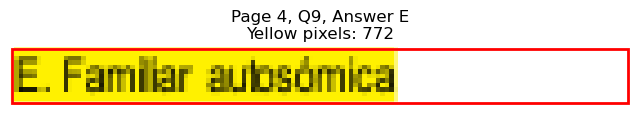


Page 4, Q9 - Selected Answer: E (based on yellow pixel count)




Page 4, Q10 - A: Detected box: x0=117.8, y0=700.3, x1=178.7, y1=712.3
Page 4, Q10, A: Yellow pixels: 0
Page 4, Q10, A: Total non-white pixels: 543
Page 4, Q10, A: Yellow percentage: 0.0%


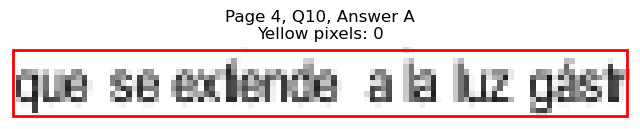

Page 4, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=268.2, y1=724.4
Page 4, Q10, B: Yellow pixels: 1576
Page 4, Q10, B: Total non-white pixels: 2535
Page 4, Q10, B: Yellow percentage: 62.2%


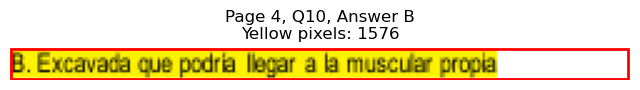

Page 4, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=292.0, y1=736.4
Page 4, Q10, C: Yellow pixels: 6
Page 4, Q10, C: Total non-white pixels: 1217
Page 4, Q10, C: Yellow percentage: 0.5%


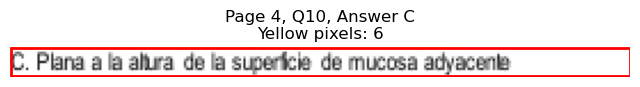

Page 4, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=424.3, y1=712.3
Page 4, Q10, D: Yellow pixels: 0
Page 4, Q10, D: Total non-white pixels: 748
Page 4, Q10, D: Yellow percentage: 0.0%


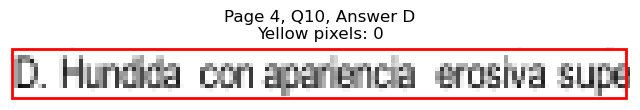

Page 4, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=554.3, y1=724.4
Page 4, Q10, E: Yellow pixels: 0
Page 4, Q10, E: Total non-white pixels: 1058
Page 4, Q10, E: Yellow percentage: 0.0%


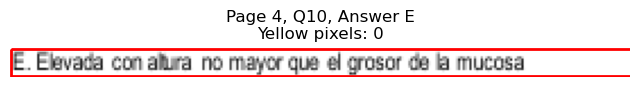


Page 4, Q10 - Selected Answer: B (based on yellow pixel count)





Page 5: Found 10 questions
Page 5, Q1 - A: Detected box: x0=129.1, y0=109.5, x1=223.0, y1=121.6
Page 5, Q1, A: Yellow pixels: 0
Page 5, Q1, A: Total non-white pixels: 460
Page 5, Q1, A: Yellow percentage: 0.0%


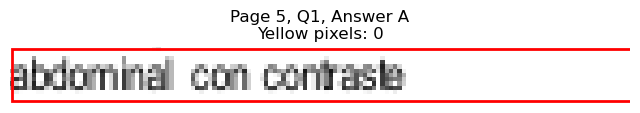

Page 5, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=160.7, y1=133.6
Page 5, Q1, B: Yellow pixels: 0
Page 5, Q1, B: Total non-white pixels: 464
Page 5, Q1, B: Yellow percentage: 0.0%


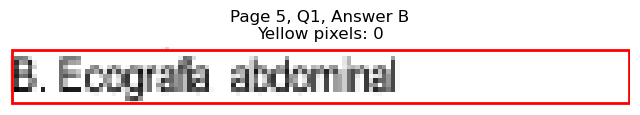

Page 5, Q1 - C: Detected box: x0=129.1, y0=133.5, x1=220.2, y1=145.6
Page 5, Q1, C: Yellow pixels: 703
Page 5, Q1, C: Total non-white pixels: 1157
Page 5, Q1, C: Yellow percentage: 60.8%


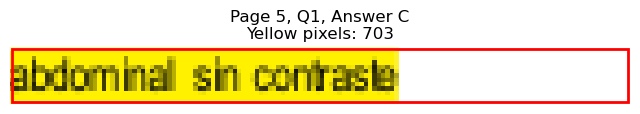

Page 5, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=377.0, y1=121.6
Page 5, Q1, D: Yellow pixels: 0
Page 5, Q1, D: Total non-white pixels: 530
Page 5, Q1, D: Yellow percentage: 0.0%


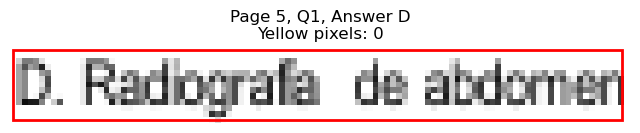

Page 5, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=373.3, y1=133.6
Page 5, Q1, E: Yellow pixels: 0
Page 5, Q1, E: Total non-white pixels: 261
Page 5, Q1, E: Yellow percentage: 0.0%


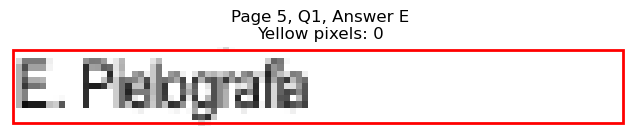


Page 5, Q1 - Selected Answer: C (based on yellow pixel count)




Page 5, Q2 - A: Detected box: x0=82.6, y0=169.6, x1=94.0, y1=181.6
Page 5, Q2, A: Yellow pixels: 0
Page 5, Q2, A: Total non-white pixels: 61
Page 5, Q2, A: Yellow percentage: 0.0%


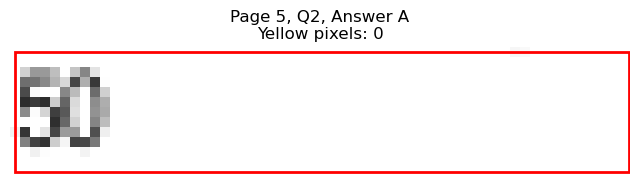

Page 5, Q2 - B: Detected box: x0=71.3, y0=181.6, x1=97.7, y1=193.6
Page 5, Q2, B: Yellow pixels: 0
Page 5, Q2, B: Total non-white pixels: 112
Page 5, Q2, B: Yellow percentage: 0.0%


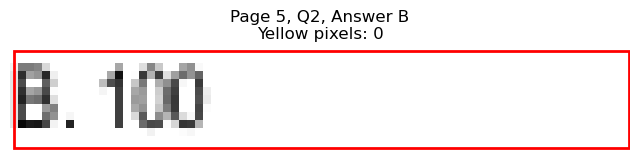

Page 5, Q2 - C: Detected box: x0=71.3, y0=193.6, x1=98.5, y1=205.6
Page 5, Q2, C: Yellow pixels: 0
Page 5, Q2, C: Total non-white pixels: 110
Page 5, Q2, C: Yellow percentage: 0.0%


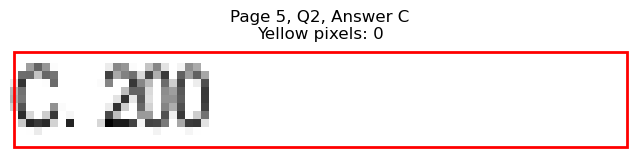

Page 5, Q2 - D: Detected box: x0=322.9, y0=169.6, x1=350.0, y1=181.6
Page 5, Q2, D: Yellow pixels: 0
Page 5, Q2, D: Total non-white pixels: 128
Page 5, Q2, D: Yellow percentage: 0.0%


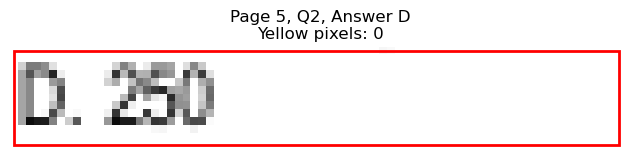

Page 5, Q2 - E: Detected box: x0=322.9, y0=181.6, x1=349.3, y1=193.6
Page 5, Q2, E: Yellow pixels: 199
Page 5, Q2, E: Total non-white pixels: 325
Page 5, Q2, E: Yellow percentage: 61.2%


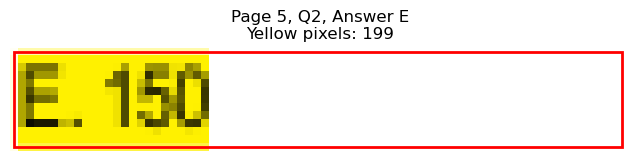


Page 5, Q2 - Selected Answer: E (based on yellow pixel count)




Page 5, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=91.0, y1=253.7
Page 5, Q3, A: Yellow pixels: 0
Page 5, Q3, A: Total non-white pixels: 29
Page 5, Q3, A: Yellow percentage: 0.0%


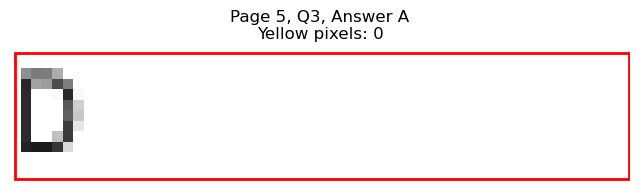

Page 5, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=90.2, y1=265.7
Page 5, Q3, B: Yellow pixels: 153
Page 5, Q3, B: Total non-white pixels: 221
Page 5, Q3, B: Yellow percentage: 69.2%


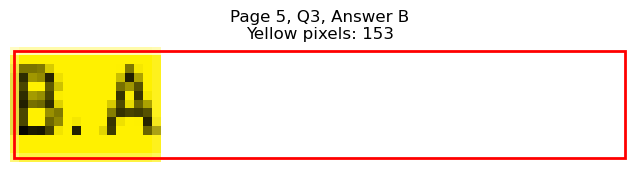

Page 5, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=91.0, y1=277.7
Page 5, Q3, C: Yellow pixels: 17
Page 5, Q3, C: Total non-white pixels: 75
Page 5, Q3, C: Yellow percentage: 22.7%


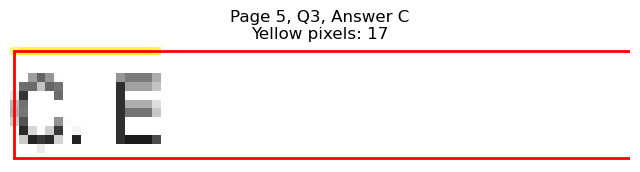

Page 5, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=342.5, y1=253.7
Page 5, Q3, D: Yellow pixels: 0
Page 5, Q3, D: Total non-white pixels: 80
Page 5, Q3, D: Yellow percentage: 0.0%


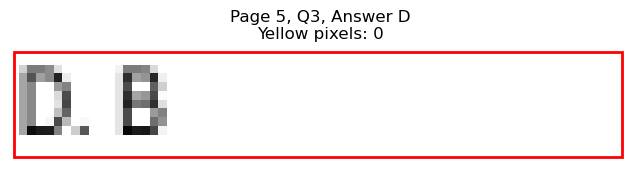

Page 5, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=341.8, y1=265.7
Page 5, Q3, E: Yellow pixels: 0
Page 5, Q3, E: Total non-white pixels: 68
Page 5, Q3, E: Yellow percentage: 0.0%


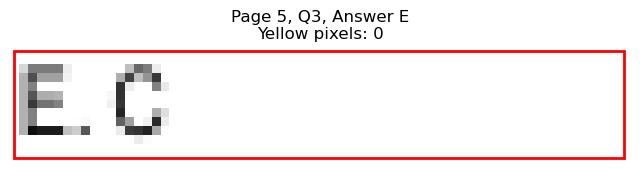


Page 5, Q3 - Selected Answer: B (based on yellow pixel count)




Page 5, Q4 - A: Detected box: x0=135.1, y0=314.5, x1=185.5, y1=326.5
Page 5, Q4, A: Yellow pixels: 0
Page 5, Q4, A: Total non-white pixels: 244
Page 5, Q4, A: Yellow percentage: 0.0%


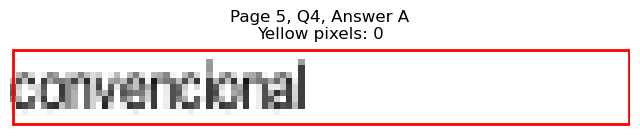

Page 5, Q4 - B: Detected box: x0=71.3, y0=326.5, x1=133.8, y1=338.5
Page 5, Q4, B: Yellow pixels: 553
Page 5, Q4, B: Total non-white pixels: 793
Page 5, Q4, B: Yellow percentage: 69.7%


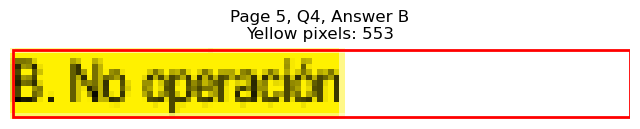

Page 5, Q4 - C: Detected box: x0=71.3, y0=338.5, x1=131.5, y1=350.5
Page 5, Q4, C: Yellow pixels: 60
Page 5, Q4, C: Total non-white pixels: 612
Page 5, Q4, C: Yellow percentage: 9.8%


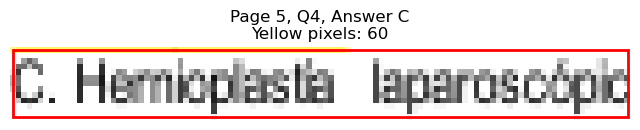

Page 5, Q4 - D: Detected box: x0=322.9, y0=314.5, x1=406.3, y1=326.5
Page 5, Q4, D: Yellow pixels: 0
Page 5, Q4, D: Total non-white pixels: 399
Page 5, Q4, D: Yellow percentage: 0.0%


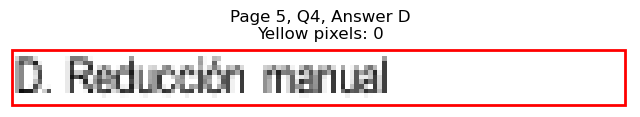

Page 5, Q4 - E: Detected box: x0=322.9, y0=326.5, x1=444.5, y1=338.5
Page 5, Q4, E: Yellow pixels: 0
Page 5, Q4, E: Total non-white pixels: 603
Page 5, Q4, E: Yellow percentage: 0.0%


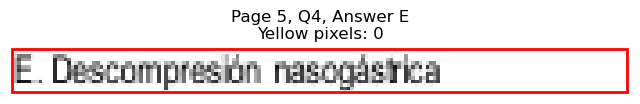


Page 5, Q4 - Selected Answer: B (based on yellow pixel count)




Page 5, Q5 - A: Detected box: x0=82.6, y0=374.5, x1=156.2, y1=386.6
Page 5, Q5, A: Yellow pixels: 0
Page 5, Q5, A: Total non-white pixels: 354
Page 5, Q5, A: Yellow percentage: 0.0%


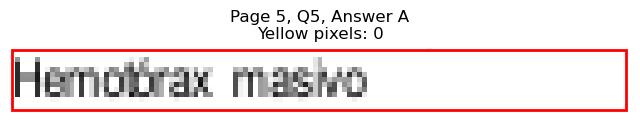

Page 5, Q5 - B: Detected box: x0=71.3, y0=386.5, x1=232.0, y1=398.6
Page 5, Q5, B: Yellow pixels: 1589
Page 5, Q5, B: Total non-white pixels: 2652
Page 5, Q5, B: Yellow percentage: 59.9%


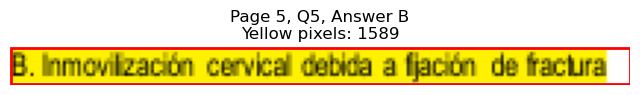

Page 5, Q5 - C: Detected box: x0=71.3, y0=398.5, x1=160.7, y1=410.6
Page 5, Q5, C: Yellow pixels: 140
Page 5, Q5, C: Total non-white pixels: 543
Page 5, Q5, C: Yellow percentage: 25.8%


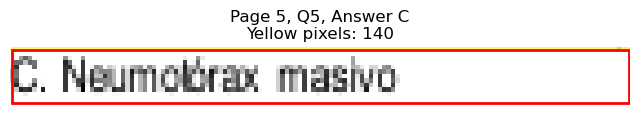

Page 5, Q5 - D: Detected box: x0=322.9, y0=374.5, x1=521.1, y1=386.6
Page 5, Q5, D: Yellow pixels: 0
Page 5, Q5, D: Total non-white pixels: 926
Page 5, Q5, D: Yellow percentage: 0.0%


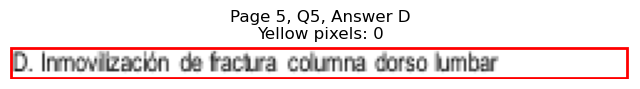

Page 5, Q5 - E: Detected box: x0=322.9, y0=386.5, x1=409.3, y1=398.6
Page 5, Q5, E: Yellow pixels: 0
Page 5, Q5, E: Total non-white pixels: 682
Page 5, Q5, E: Yellow percentage: 0.0%


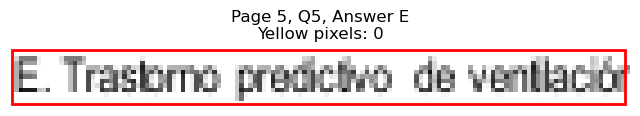


Page 5, Q5 - Selected Answer: B (based on yellow pixel count)




Page 5, Q6 - A: Detected box: x0=82.6, y0=434.6, x1=150.3, y1=446.6
Page 5, Q6, A: Yellow pixels: 0
Page 5, Q6, A: Total non-white pixels: 372
Page 5, Q6, A: Yellow percentage: 0.0%


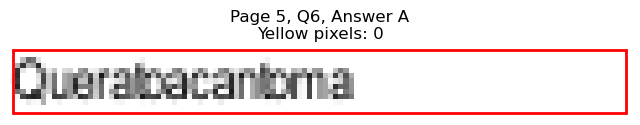

Page 5, Q6 - B: Detected box: x0=71.3, y0=446.6, x1=165.9, y1=458.6
Page 5, Q6, B: Yellow pixels: 0
Page 5, Q6, B: Total non-white pixels: 453
Page 5, Q6, B: Yellow percentage: 0.0%


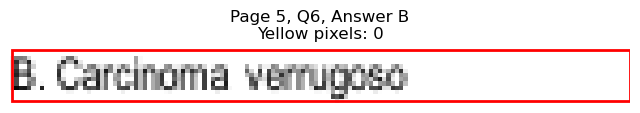

Page 5, Q6 - C: Detected box: x0=71.3, y0=458.6, x1=176.6, y1=470.6
Page 5, Q6, C: Yellow pixels: 816
Page 5, Q6, C: Total non-white pixels: 1352
Page 5, Q6, C: Yellow percentage: 60.4%


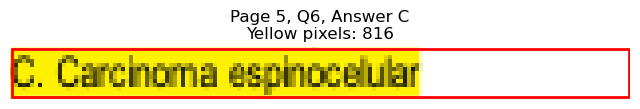

Page 5, Q6 - D: Detected box: x0=322.9, y0=434.6, x1=407.0, y1=446.6
Page 5, Q6, D: Yellow pixels: 0
Page 5, Q6, D: Total non-white pixels: 424
Page 5, Q6, D: Yellow percentage: 0.0%


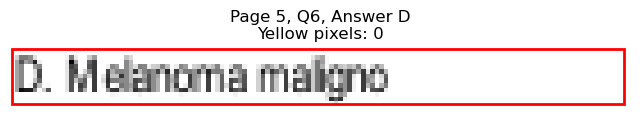

Page 5, Q6 - E: Detected box: x0=322.9, y0=446.6, x1=422.0, y1=458.6
Page 5, Q6, E: Yellow pixels: 0
Page 5, Q6, E: Total non-white pixels: 481
Page 5, Q6, E: Yellow percentage: 0.0%


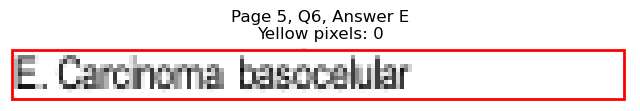


Page 5, Q6 - Selected Answer: C (based on yellow pixel count)




Page 5, Q7 - A: Detected box: x0=82.6, y0=495.4, x1=196.7, y1=507.4
Page 5, Q7, A: Yellow pixels: 0
Page 5, Q7, A: Total non-white pixels: 594
Page 5, Q7, A: Yellow percentage: 0.0%


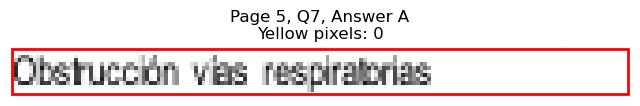

Page 5, Q7 - B: Detected box: x0=71.3, y0=507.4, x1=164.5, y1=519.4
Page 5, Q7, B: Yellow pixels: 0
Page 5, Q7, B: Total non-white pixels: 447
Page 5, Q7, B: Yellow percentage: 0.0%


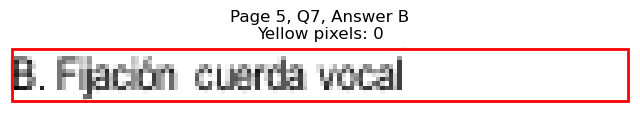

Page 5, Q7 - C: Detected box: x0=71.3, y0=519.4, x1=121.0, y1=531.4
Page 5, Q7, C: Yellow pixels: 428
Page 5, Q7, C: Total non-white pixels: 624
Page 5, Q7, C: Yellow percentage: 68.6%


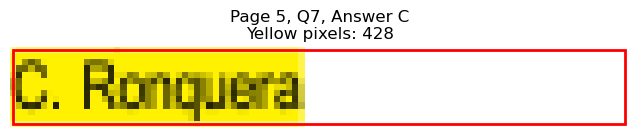

Page 5, Q7 - D: Detected box: x0=322.9, y0=495.4, x1=365.0, y1=507.4
Page 5, Q7, D: Yellow pixels: 0
Page 5, Q7, D: Total non-white pixels: 211
Page 5, Q7, D: Yellow percentage: 0.0%


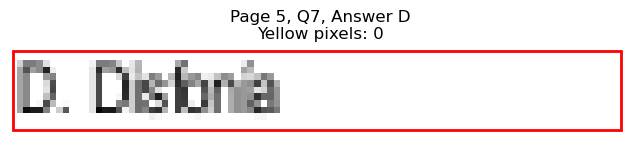

Page 5, Q7 - E: Detected box: x0=322.9, y0=507.4, x1=364.3, y1=519.4
Page 5, Q7, E: Yellow pixels: 0
Page 5, Q7, E: Total non-white pixels: 212
Page 5, Q7, E: Yellow percentage: 0.0%


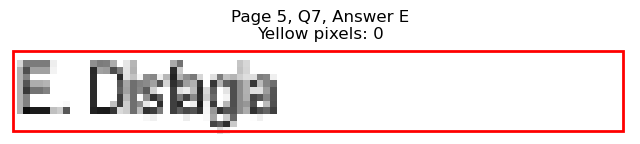


Page 5, Q7 - Selected Answer: C (based on yellow pixel count)




Page 5, Q8 - A: Detected box: x0=82.6, y0=567.5, x1=124.8, y1=579.5
Page 5, Q8, A: Yellow pixels: 349
Page 5, Q8, A: Total non-white pixels: 535
Page 5, Q8, A: Yellow percentage: 65.2%


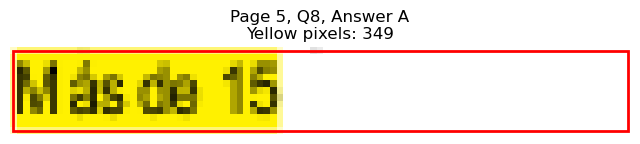

Page 5, Q8 - B: Detected box: x0=71.3, y0=579.4, x1=119.5, y1=591.5
Page 5, Q8, B: Yellow pixels: 39
Page 5, Q8, B: Total non-white pixels: 268
Page 5, Q8, B: Yellow percentage: 14.6%


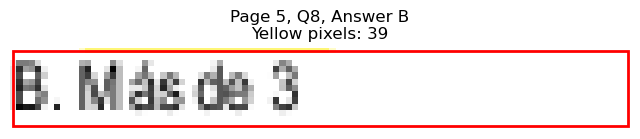

Page 5, Q8 - C: Detected box: x0=71.3, y0=591.5, x1=129.2, y1=603.5
Page 5, Q8, C: Yellow pixels: 0
Page 5, Q8, C: Total non-white pixels: 238
Page 5, Q8, C: Yellow percentage: 0.0%


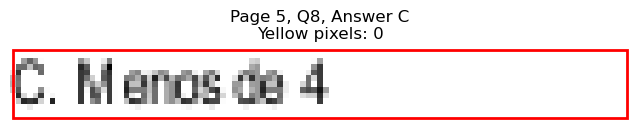

Page 5, Q8 - D: Detected box: x0=322.9, y0=567.5, x1=345.5, y1=579.5
Page 5, Q8, D: Yellow pixels: 0
Page 5, Q8, D: Total non-white pixels: 86
Page 5, Q8, D: Yellow percentage: 0.0%


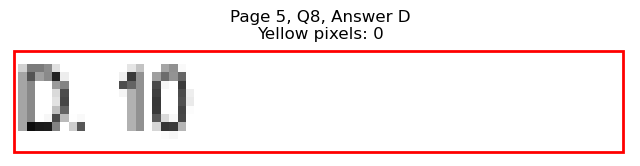

Page 5, Q8 - E: Detected box: x0=322.9, y0=579.4, x1=385.3, y1=591.5
Page 5, Q8, E: Yellow pixels: 0
Page 5, Q8, E: Total non-white pixels: 272
Page 5, Q8, E: Yellow percentage: 0.0%


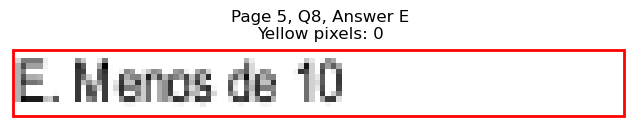


Page 5, Q8 - Selected Answer: A (based on yellow pixel count)




Page 5, Q9 - A: Detected box: x0=82.6, y0=627.5, x1=196.0, y1=639.6
Page 5, Q9, A: Yellow pixels: 0
Page 5, Q9, A: Total non-white pixels: 575
Page 5, Q9, A: Yellow percentage: 0.0%


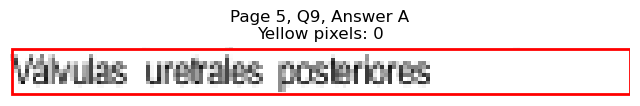

Page 5, Q9 - B: Detected box: x0=71.3, y0=639.5, x1=165.2, y1=651.6
Page 5, Q9, B: Yellow pixels: 0
Page 5, Q9, B: Total non-white pixels: 469
Page 5, Q9, B: Yellow percentage: 0.0%


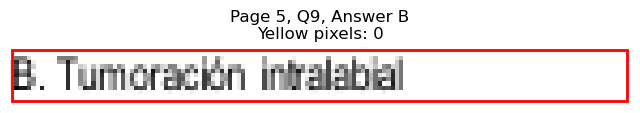

Page 5, Q9 - C: Detected box: x0=71.3, y0=651.5, x1=125.5, y1=663.6
Page 5, Q9, C: Yellow pixels: 452
Page 5, Q9, C: Total non-white pixels: 689
Page 5, Q9, C: Yellow percentage: 65.6%


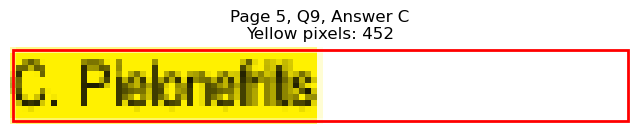

Page 5, Q9 - D: Detected box: x0=322.9, y0=627.5, x1=484.2, y1=639.6
Page 5, Q9, D: Yellow pixels: 0
Page 5, Q9, D: Total non-white pixels: 793
Page 5, Q9, D: Yellow percentage: 0.0%


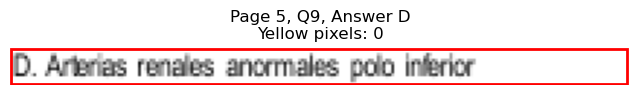

Page 5, Q9 - E: Detected box: x0=322.9, y0=639.5, x1=437.0, y1=651.6
Page 5, Q9, E: Yellow pixels: 0
Page 5, Q9, E: Total non-white pixels: 545
Page 5, Q9, E: Yellow percentage: 0.0%


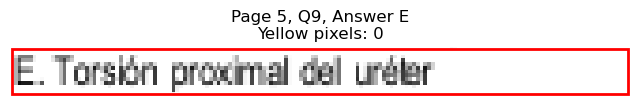


Page 5, Q9 - Selected Answer: C (based on yellow pixel count)




Page 5, Q10 - A: Detected box: x0=82.6, y0=700.3, x1=142.0, y1=712.3
Page 5, Q10, A: Yellow pixels: 0
Page 5, Q10, A: Total non-white pixels: 319
Page 5, Q10, A: Yellow percentage: 0.0%


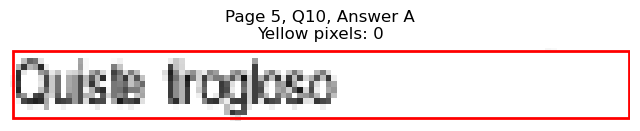

Page 5, Q10 - B: Detected box: x0=71.3, y0=712.3, x1=124.7, y1=724.4
Page 5, Q10, B: Yellow pixels: 0
Page 5, Q10, B: Total non-white pixels: 428
Page 5, Q10, B: Yellow percentage: 0.0%


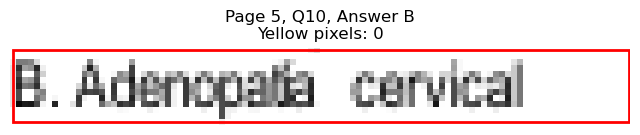

Page 5, Q10 - C: Detected box: x0=71.3, y0=724.3, x1=171.2, y1=736.4
Page 5, Q10, C: Yellow pixels: 0
Page 5, Q10, C: Total non-white pixels: 646
Page 5, Q10, C: Yellow percentage: 0.0%


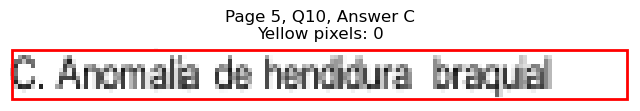

Page 5, Q10 - D: Detected box: x0=322.9, y0=700.3, x1=398.1, y1=712.3
Page 5, Q10, D: Yellow pixels: 580
Page 5, Q10, D: Total non-white pixels: 962
Page 5, Q10, D: Yellow percentage: 60.3%


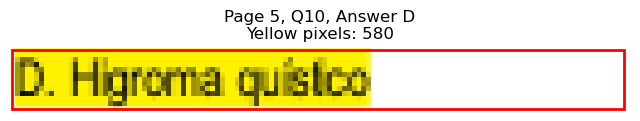

Page 5, Q10 - E: Detected box: x0=322.9, y0=712.3, x1=397.3, y1=724.4
Page 5, Q10, E: Yellow pixels: 3
Page 5, Q10, E: Total non-white pixels: 437
Page 5, Q10, E: Yellow percentage: 0.7%


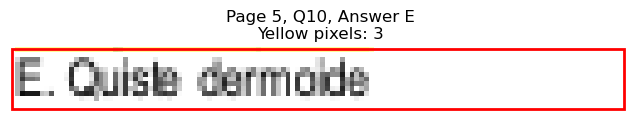


Page 5, Q10 - Selected Answer: D (based on yellow pixel count)





Page 6: Found 9 questions
Page 6, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=244.8, y1=121.6
Page 6, Q1, A: Yellow pixels: 0
Page 6, Q1, A: Total non-white pixels: 803
Page 6, Q1, A: Yellow percentage: 0.0%


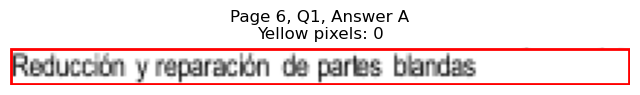

Page 6, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=268.7, y1=133.6
Page 6, Q1, B: Yellow pixels: 0
Page 6, Q1, B: Total non-white pixels: 998
Page 6, Q1, B: Yellow percentage: 0.0%


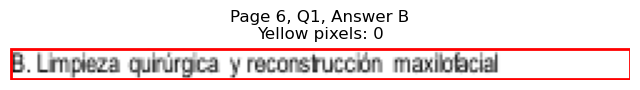

Page 6, Q1 - C: Detected box: x0=159.9, y0=133.5, x1=260.6, y1=145.6
Page 6, Q1, C: Yellow pixels: 0
Page 6, Q1, C: Total non-white pixels: 480
Page 6, Q1, C: Yellow percentage: 0.0%


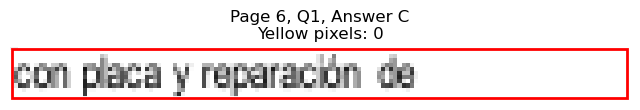

Page 6, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=502.5, y1=121.6
Page 6, Q1, D: Yellow pixels: 1617
Page 6, Q1, D: Total non-white pixels: 2327
Page 6, Q1, D: Yellow percentage: 69.5%


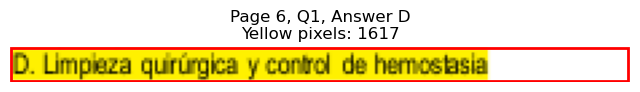

Page 6, Q1 - E: Detected box: x0=377.0, y0=121.5, x1=452.1, y1=133.6
Page 6, Q1, E: Yellow pixels: 124
Page 6, Q1, E: Total non-white pixels: 721
Page 6, Q1, E: Yellow percentage: 17.2%


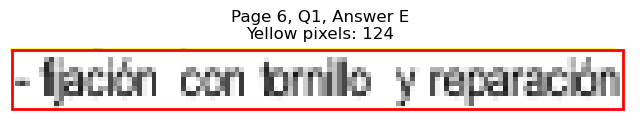


Page 6, Q1 - Selected Answer: D (based on yellow pixel count)




Page 6, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=133.7, y1=205.6
Page 6, Q2, A: Yellow pixels: 525
Page 6, Q2, A: Total non-white pixels: 897
Page 6, Q2, A: Yellow percentage: 58.5%


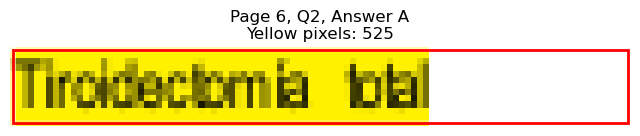

Page 6, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=133.0, y1=217.7
Page 6, Q2, B: Yellow pixels: 68
Page 6, Q2, B: Total non-white pixels: 539
Page 6, Q2, B: Yellow percentage: 12.6%


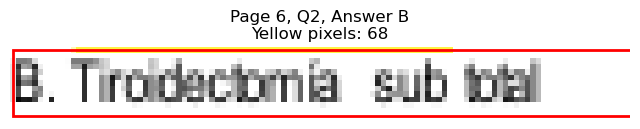

Page 6, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=127.0, y1=229.7
Page 6, Q2, C: Yellow pixels: 0
Page 6, Q2, C: Total non-white pixels: 339
Page 6, Q2, C: Yellow percentage: 0.0%


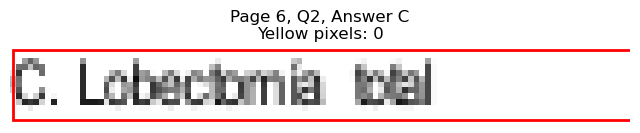

Page 6, Q2 - D: Detected box: x0=400.1, y0=193.6, x1=464.7, y1=205.6
Page 6, Q2, D: Yellow pixels: 0
Page 6, Q2, D: Total non-white pixels: 327
Page 6, Q2, D: Yellow percentage: 0.0%


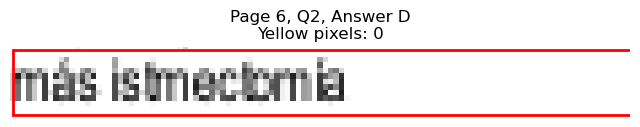

Page 6, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=380.0, y1=217.7
Page 6, Q2, E: Yellow pixels: 0
Page 6, Q2, E: Total non-white pixels: 280
Page 6, Q2, E: Yellow percentage: 0.0%


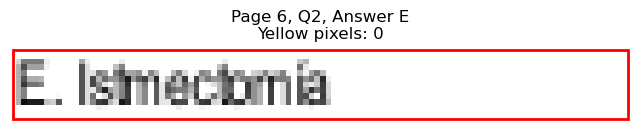


Page 6, Q2 - Selected Answer: A (based on yellow pixel count)




Page 6, Q3 - A: Detected box: x0=82.6, y0=253.6, x1=205.9, y1=265.7
Page 6, Q3, A: Yellow pixels: 986
Page 6, Q3, A: Total non-white pixels: 1588
Page 6, Q3, A: Yellow percentage: 62.1%


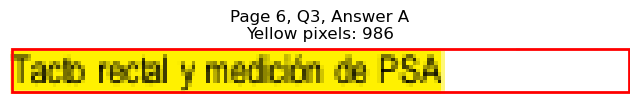

Page 6, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=171.2, y1=277.7
Page 6, Q3, B: Yellow pixels: 120
Page 6, Q3, B: Total non-white pixels: 791
Page 6, Q3, B: Yellow percentage: 15.2%


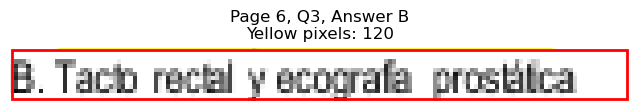

Page 6, Q3 - C: Detected box: x0=71.3, y0=277.7, x1=195.2, y1=289.7
Page 6, Q3, C: Yellow pixels: 0
Page 6, Q3, C: Total non-white pixels: 630
Page 6, Q3, C: Yellow percentage: 0.0%


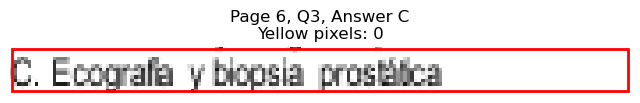

Page 6, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=444.5, y1=265.7
Page 6, Q3, D: Yellow pixels: 0
Page 6, Q3, D: Total non-white pixels: 806
Page 6, Q3, D: Yellow percentage: 0.0%


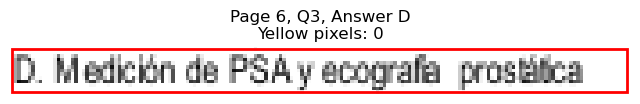

Page 6, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=475.2, y1=277.7
Page 6, Q3, E: Yellow pixels: 0
Page 6, Q3, E: Total non-white pixels: 771
Page 6, Q3, E: Yellow percentage: 0.0%


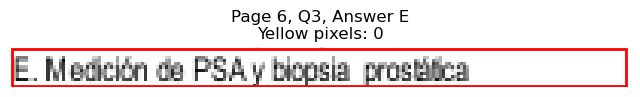


Page 6, Q3 - Selected Answer: A (based on yellow pixel count)




Page 6, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=204.3, y1=338.5
Page 6, Q4, A: Yellow pixels: 0
Page 6, Q4, A: Total non-white pixels: 608
Page 6, Q4, A: Yellow percentage: 0.0%


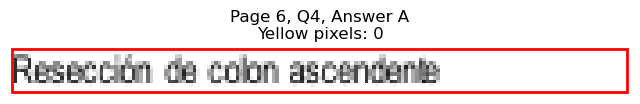

Page 6, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=127.7, y1=350.5
Page 6, Q4, B: Yellow pixels: 0
Page 6, Q4, B: Total non-white pixels: 273
Page 6, Q4, B: Yellow percentage: 0.0%


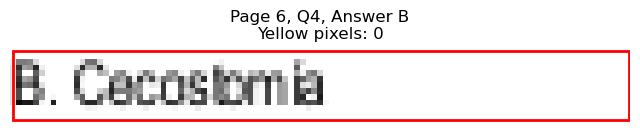

Page 6, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=121.7, y1=362.5
Page 6, Q4, C: Yellow pixels: 0
Page 6, Q4, C: Total non-white pixels: 237
Page 6, Q4, C: Yellow percentage: 0.0%


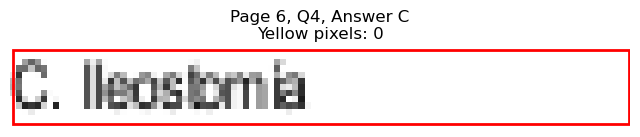

Page 6, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=395.0, y1=338.5
Page 6, Q4, D: Yellow pixels: 941
Page 6, Q4, D: Total non-white pixels: 1391
Page 6, Q4, D: Yellow percentage: 67.6%


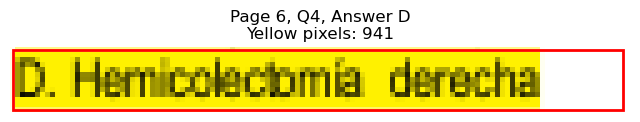

Page 6, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=444.5, y1=350.5
Page 6, Q4, E: Yellow pixels: 105
Page 6, Q4, E: Total non-white pixels: 689
Page 6, Q4, E: Yellow percentage: 15.2%


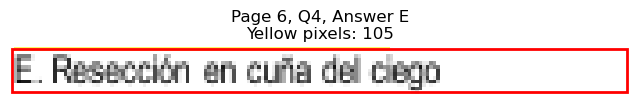


Page 6, Q4 - Selected Answer: D (based on yellow pixel count)




Page 6, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=115.7, y1=410.6
Page 6, Q5, A: Yellow pixels: 0
Page 6, Q5, A: Total non-white pixels: 175
Page 6, Q5, A: Yellow percentage: 0.0%


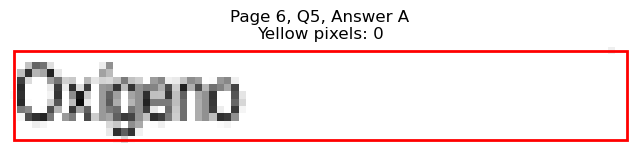

Page 6, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=124.8, y1=422.6
Page 6, Q5, B: Yellow pixels: 394
Page 6, Q5, B: Total non-white pixels: 676
Page 6, Q5, B: Yellow percentage: 58.3%


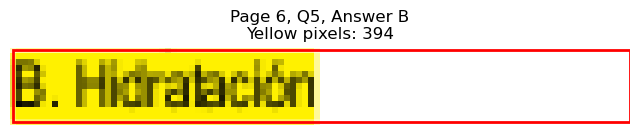

Page 6, Q5 - C: Detected box: x0=71.3, y0=422.5, x1=115.0, y1=434.6
Page 6, Q5, C: Yellow pixels: 51
Page 6, Q5, C: Total non-white pixels: 257
Page 6, Q5, C: Yellow percentage: 19.8%


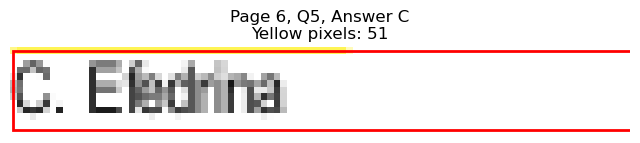

Page 6, Q5 - D: Detected box: x0=322.9, y0=398.5, x1=366.5, y1=410.6
Page 6, Q5, D: Yellow pixels: 0
Page 6, Q5, D: Total non-white pixels: 208
Page 6, Q5, D: Yellow percentage: 0.0%


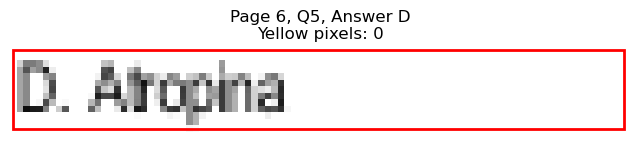

Page 6, Q5 - E: Detected box: x0=322.9, y0=410.5, x1=368.8, y1=422.6
Page 6, Q5, E: Yellow pixels: 0
Page 6, Q5, E: Total non-white pixels: 232
Page 6, Q5, E: Yellow percentage: 0.0%


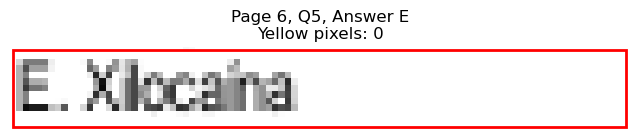


Page 6, Q5 - Selected Answer: B (based on yellow pixel count)




Page 6, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=216.2, y1=482.6
Page 6, Q6, A: Yellow pixels: 0
Page 6, Q6, A: Total non-white pixels: 688
Page 6, Q6, A: Yellow percentage: 0.0%


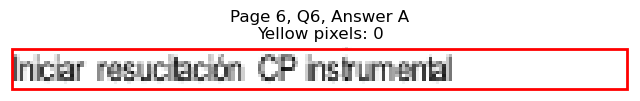

Page 6, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=196.7, y1=495.4
Page 6, Q6, B: Yellow pixels: 0
Page 6, Q6, B: Total non-white pixels: 606
Page 6, Q6, B: Yellow percentage: 0.0%


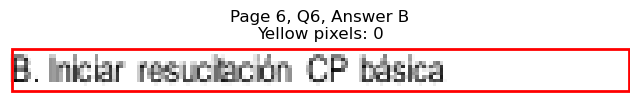

Page 6, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=208.9, y1=507.4
Page 6, Q6, C: Yellow pixels: 1225
Page 6, Q6, C: Total non-white pixels: 1768
Page 6, Q6, C: Yellow percentage: 69.3%


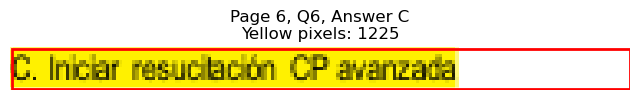

Page 6, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=434.7, y1=482.6
Page 6, Q6, D: Yellow pixels: 0
Page 6, Q6, D: Total non-white pixels: 538
Page 6, Q6, D: Yellow percentage: 0.0%


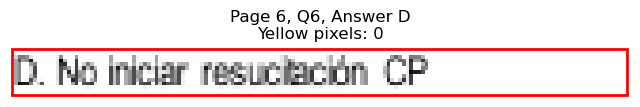

Page 6, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=410.8, y1=495.4
Page 6, Q6, E: Yellow pixels: 0
Page 6, Q6, E: Total non-white pixels: 584
Page 6, Q6, E: Yellow percentage: 0.0%


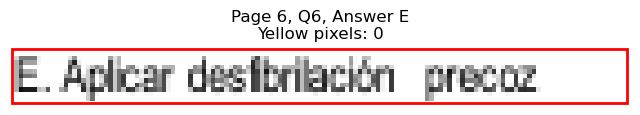


Page 6, Q6 - Selected Answer: C (based on yellow pixel count)




Page 6, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=110.5, y1=555.5
Page 6, Q7, A: Yellow pixels: 230
Page 6, Q7, A: Total non-white pixels: 351
Page 6, Q7, A: Yellow percentage: 65.5%


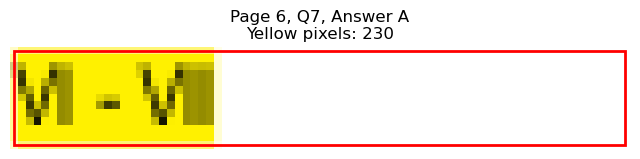

Page 6, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=112.7, y1=567.5
Page 6, Q7, B: Yellow pixels: 25
Page 6, Q7, B: Total non-white pixels: 209
Page 6, Q7, B: Yellow percentage: 12.0%


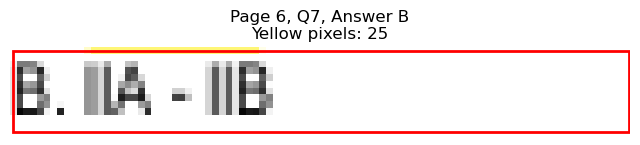

Page 6, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=106.8, y1=579.5
Page 6, Q7, C: Yellow pixels: 0
Page 6, Q7, C: Total non-white pixels: 128
Page 6, Q7, C: Yellow percentage: 0.0%


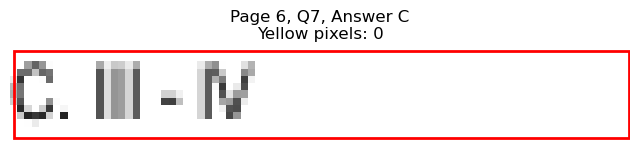

Page 6, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=356.8, y1=555.5
Page 6, Q7, D: Yellow pixels: 0
Page 6, Q7, D: Total non-white pixels: 108
Page 6, Q7, D: Yellow percentage: 0.0%


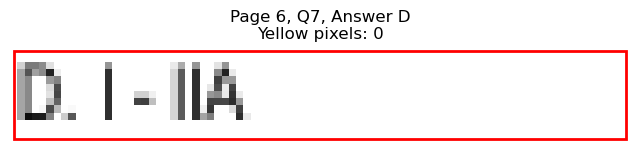

Page 6, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=356.8, y1=567.5
Page 6, Q7, E: Yellow pixels: 0
Page 6, Q7, E: Total non-white pixels: 113
Page 6, Q7, E: Yellow percentage: 0.0%


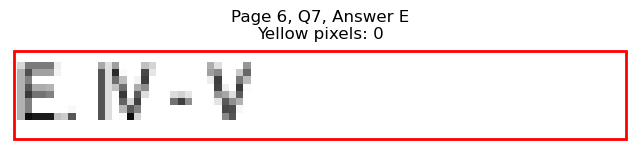


Page 6, Q7 - Selected Answer: A (based on yellow pixel count)




Page 6, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=125.5, y1=627.5
Page 6, Q8, A: Yellow pixels: 677
Page 6, Q8, A: Total non-white pixels: 1040
Page 6, Q8, A: Yellow percentage: 65.1%


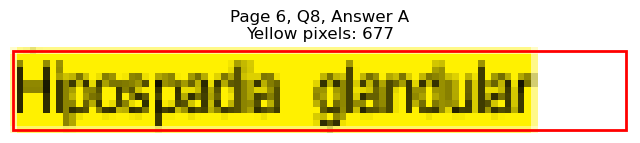

Page 6, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=157.7, y1=639.6
Page 6, Q8, B: Yellow pixels: 78
Page 6, Q8, B: Total non-white pixels: 547
Page 6, Q8, B: Yellow percentage: 14.3%


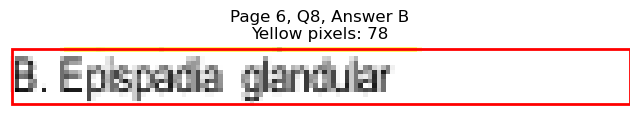

Page 6, Q8 - C: Detected box: x0=322.9, y0=603.5, x1=418.3, y1=615.5
Page 6, Q8, C: Yellow pixels: 0
Page 6, Q8, C: Total non-white pixels: 610
Page 6, Q8, C: Yellow percentage: 0.0%


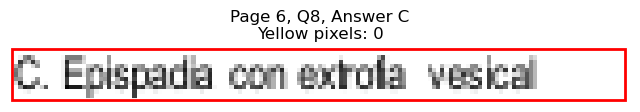

Page 6, Q8 - D: Detected box: x0=322.9, y0=615.5, x1=410.0, y1=627.5
Page 6, Q8, D: Yellow pixels: 0
Page 6, Q8, D: Total non-white pixels: 456
Page 6, Q8, D: Yellow percentage: 0.0%


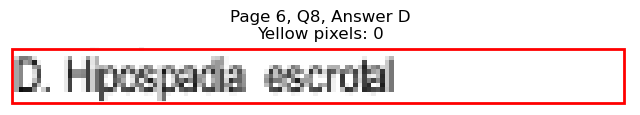

Page 6, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=376.3, y1=639.6
Page 6, Q8, E: Yellow pixels: 0
Page 6, Q8, E: Total non-white pixels: 405
Page 6, Q8, E: Yellow percentage: 0.0%


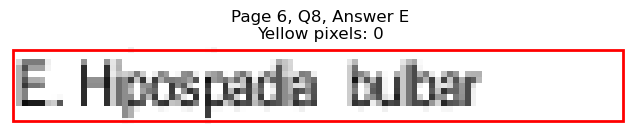


Page 6, Q8 - Selected Answer: A (based on yellow pixel count)




Page 6, Q9 - A: Detected box: x0=82.6, y0=663.5, x1=127.0, y1=675.6
Page 6, Q9, A: Yellow pixels: 0
Page 6, Q9, A: Total non-white pixels: 240
Page 6, Q9, A: Yellow percentage: 0.0%


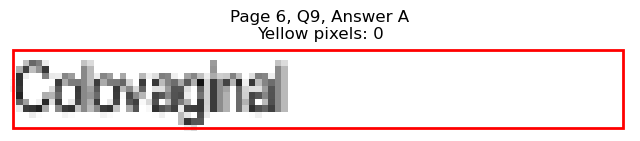

Page 6, Q9 - B: Detected box: x0=71.3, y0=676.3, x1=129.2, y1=688.3
Page 6, Q9, B: Yellow pixels: 0
Page 6, Q9, B: Total non-white pixels: 294
Page 6, Q9, B: Yellow percentage: 0.0%


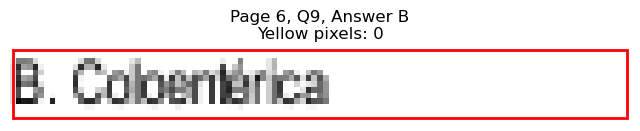

Page 6, Q9 - C: Detected box: x0=71.3, y0=688.3, x1=130.0, y1=700.3
Page 6, Q9, C: Yellow pixels: 0
Page 6, Q9, C: Total non-white pixels: 278
Page 6, Q9, C: Yellow percentage: 0.0%


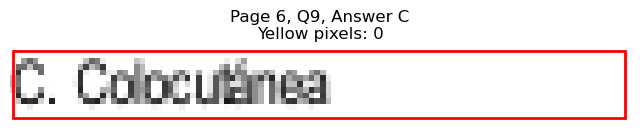

Page 6, Q9 - D: Detected box: x0=322.9, y0=663.5, x1=378.6, y1=675.6
Page 6, Q9, D: Yellow pixels: 415
Page 6, Q9, D: Total non-white pixels: 715
Page 6, Q9, D: Yellow percentage: 58.0%


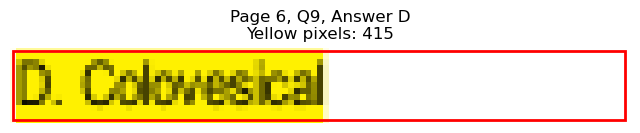

Page 6, Q9 - E: Detected box: x0=322.9, y0=676.3, x1=380.2, y1=688.3
Page 6, Q9, E: Yellow pixels: 0
Page 6, Q9, E: Total non-white pixels: 341
Page 6, Q9, E: Yellow percentage: 0.0%


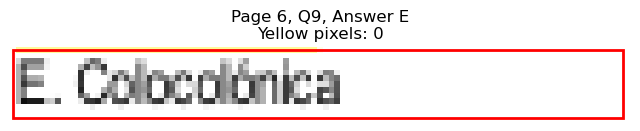


Page 6, Q9 - Selected Answer: D (based on yellow pixel count)





Page 7: Found 10 questions
Page 7, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=226.0, y1=121.6
Page 7, Q1, A: Yellow pixels: 0
Page 7, Q1, A: Total non-white pixels: 685
Page 7, Q1, A: Yellow percentage: 0.0%


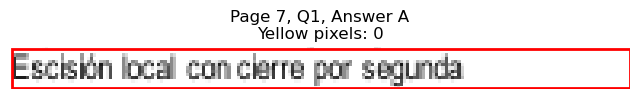

Page 7, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=130.0, y1=133.6
Page 7, Q1, B: Yellow pixels: 0
Page 7, Q1, B: Total non-white pixels: 427
Page 7, Q1, B: Yellow percentage: 0.0%


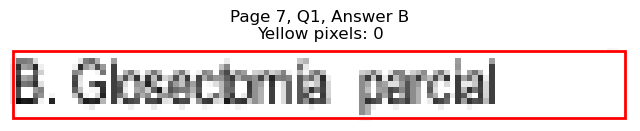

Page 7, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=246.4, y1=145.6
Page 7, Q1, C: Yellow pixels: 0
Page 7, Q1, C: Total non-white pixels: 862
Page 7, Q1, C: Yellow percentage: 0.0%


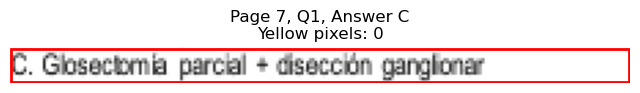

Page 7, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=396.5, y1=121.6
Page 7, Q1, D: Yellow pixels: 0
Page 7, Q1, D: Total non-white pixels: 384
Page 7, Q1, D: Yellow percentage: 0.0%


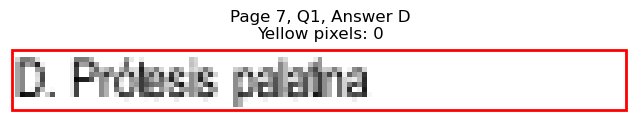

Page 7, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=488.3, y1=133.6
Page 7, Q1, E: Yellow pixels: 1471
Page 7, Q1, E: Total non-white pixels: 2132
Page 7, Q1, E: Yellow percentage: 69.0%


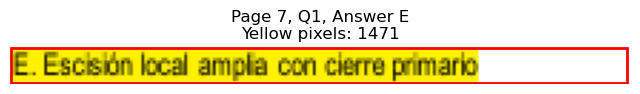


Page 7, Q1 - Selected Answer: E (based on yellow pixel count)




Page 7, Q2 - A: Detected box: x0=82.6, y0=181.6, x1=132.2, y1=193.6
Page 7, Q2, A: Yellow pixels: 0
Page 7, Q2, A: Total non-white pixels: 252
Page 7, Q2, A: Yellow percentage: 0.0%


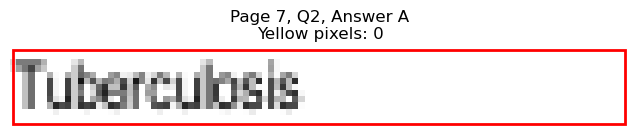

Page 7, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=152.5, y1=205.6
Page 7, Q2, B: Yellow pixels: 0
Page 7, Q2, B: Total non-white pixels: 386
Page 7, Q2, B: Yellow percentage: 0.0%


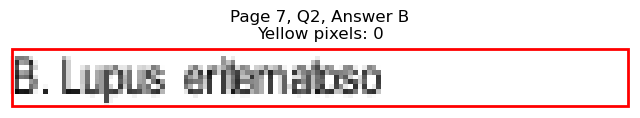

Page 7, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=128.5, y1=217.7
Page 7, Q2, C: Yellow pixels: 437
Page 7, Q2, C: Total non-white pixels: 728
Page 7, Q2, C: Yellow percentage: 60.0%


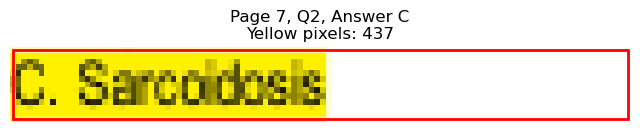

Page 7, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=419.8, y1=193.6
Page 7, Q2, D: Yellow pixels: 0
Page 7, Q2, D: Total non-white pixels: 461
Page 7, Q2, D: Yellow percentage: 0.0%


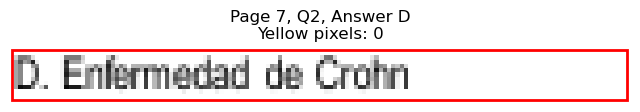

Page 7, Q2 - E: Detected box: x0=322.9, y0=193.6, x1=404.0, y1=205.6
Page 7, Q2, E: Yellow pixels: 0
Page 7, Q2, E: Total non-white pixels: 427
Page 7, Q2, E: Yellow percentage: 0.0%


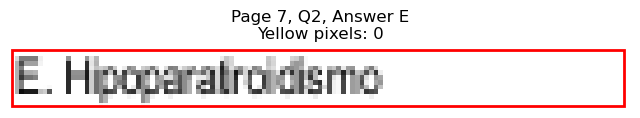


Page 7, Q2 - Selected Answer: C (based on yellow pixel count)




Page 7, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=168.3, y1=253.7
Page 7, Q3, A: Yellow pixels: 0
Page 7, Q3, A: Total non-white pixels: 644
Page 7, Q3, A: Yellow percentage: 0.0%


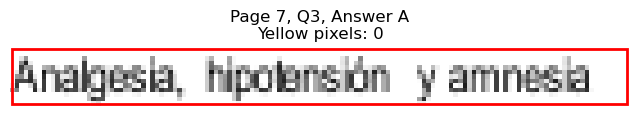

Page 7, Q3 - B: Detected box: x0=135.1, y0=253.6, x1=217.7, y1=265.7
Page 7, Q3, B: Yellow pixels: 0
Page 7, Q3, B: Total non-white pixels: 438
Page 7, Q3, B: Yellow percentage: 0.0%


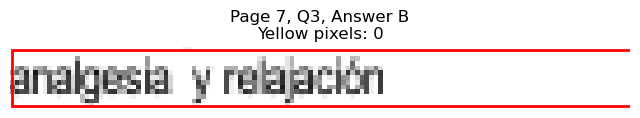

Page 7, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=202.7, y1=277.7
Page 7, Q3, C: Yellow pixels: 0
Page 7, Q3, C: Total non-white pixels: 633
Page 7, Q3, C: Yellow percentage: 0.0%


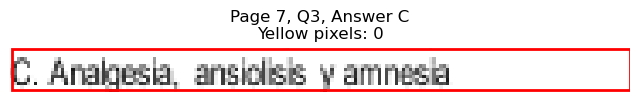

Page 7, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=465.7, y1=253.7
Page 7, Q3, D: Yellow pixels: 1089
Page 7, Q3, D: Total non-white pixels: 1846
Page 7, Q3, D: Yellow percentage: 59.0%


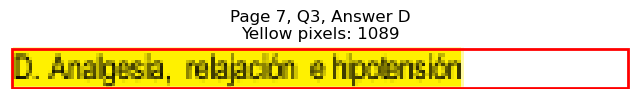

Page 7, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=493.2, y1=265.7
Page 7, Q3, E: Yellow pixels: 140
Page 7, Q3, E: Total non-white pixels: 974
Page 7, Q3, E: Yellow percentage: 14.4%


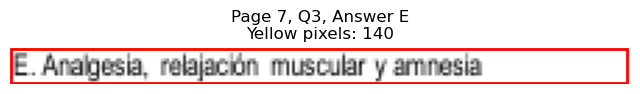


Page 7, Q3 - Selected Answer: D (based on yellow pixel count)




Page 7, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=106.0, y1=338.5
Page 7, Q4, A: Yellow pixels: 0
Page 7, Q4, A: Total non-white pixels: 111
Page 7, Q4, A: Yellow percentage: 0.0%


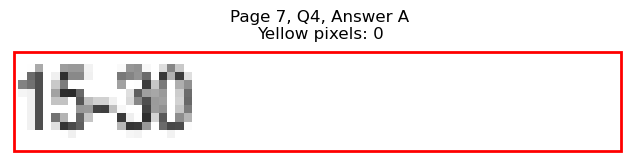

Page 7, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=105.3, y1=350.5
Page 7, Q4, B: Yellow pixels: 0
Page 7, Q4, B: Total non-white pixels: 162
Page 7, Q4, B: Yellow percentage: 0.0%


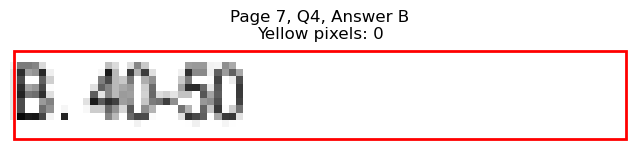

Page 7, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=101.5, y1=362.5
Page 7, Q4, C: Yellow pixels: 0
Page 7, Q4, C: Total non-white pixels: 113
Page 7, Q4, C: Yellow percentage: 0.0%


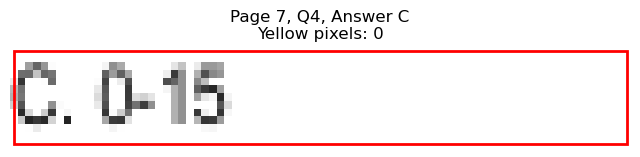

Page 7, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=357.6, y1=338.5
Page 7, Q4, D: Yellow pixels: 297
Page 7, Q4, D: Total non-white pixels: 442
Page 7, Q4, D: Yellow percentage: 67.2%


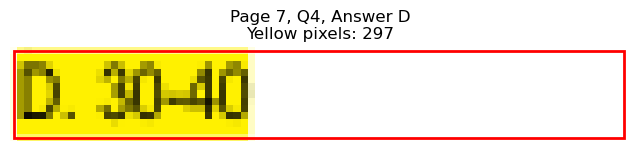

Page 7, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=350.0, y1=350.5
Page 7, Q4, E: Yellow pixels: 32
Page 7, Q4, E: Total non-white pixels: 148
Page 7, Q4, E: Yellow percentage: 21.6%


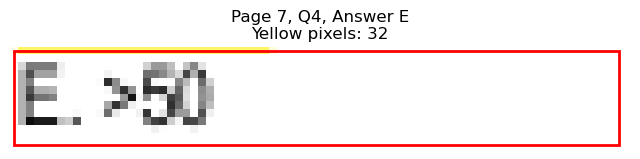


Page 7, Q4 - Selected Answer: D (based on yellow pixel count)




Page 7, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=187.7, y1=398.6
Page 7, Q5, A: Yellow pixels: 0
Page 7, Q5, A: Total non-white pixels: 758
Page 7, Q5, A: Yellow percentage: 0.0%


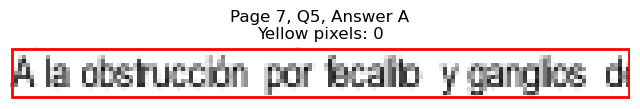

Page 7, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=270.2, y1=422.6
Page 7, Q5, B: Yellow pixels: 1596
Page 7, Q5, B: Total non-white pixels: 2605
Page 7, Q5, B: Yellow percentage: 61.3%


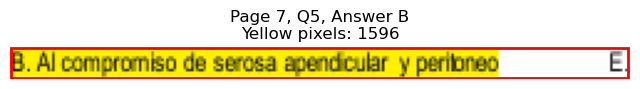

Page 7, Q5 - C: Detected box: x0=71.3, y0=434.6, x1=233.7, y1=446.6
Page 7, Q5, C: Yellow pixels: 26
Page 7, Q5, C: Total non-white pixels: 878
Page 7, Q5, C: Yellow percentage: 3.0%


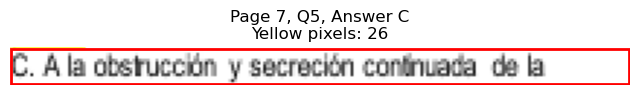

Page 7, Q5 - D: Detected box: x0=312.4, y0=398.5, x1=469.2, y1=410.6
Page 7, Q5, D: Yellow pixels: 0
Page 7, Q5, D: Total non-white pixels: 977
Page 7, Q5, D: Yellow percentage: 0.0%


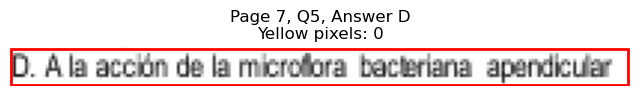

Page 7, Q5 - E: Detected box: x0=312.4, y0=410.5, x1=463.3, y1=422.6
Page 7, Q5, E: Yellow pixels: 0
Page 7, Q5, E: Total non-white pixels: 979
Page 7, Q5, E: Yellow percentage: 0.0%


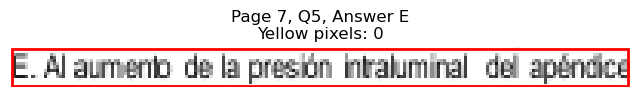


Page 7, Q5 - Selected Answer: B (based on yellow pixel count)




Page 7, Q6 - A: Detected box: x0=82.6, y0=483.4, x1=126.2, y1=495.4
Page 7, Q6, A: Yellow pixels: 0
Page 7, Q6, A: Total non-white pixels: 430
Page 7, Q6, A: Yellow percentage: 0.0%


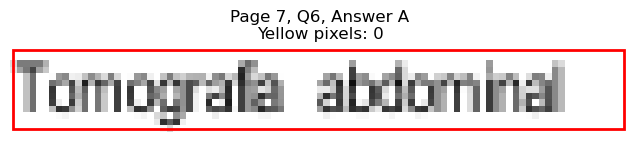

Page 7, Q6 - B: Detected box: x0=71.3, y0=495.4, x1=160.7, y1=507.4
Page 7, Q6, B: Yellow pixels: 0
Page 7, Q6, B: Total non-white pixels: 464
Page 7, Q6, B: Yellow percentage: 0.0%


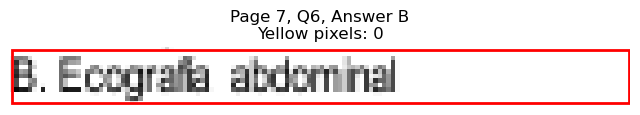

Page 7, Q6 - C: Detected box: x0=71.3, y0=507.4, x1=150.3, y1=519.4
Page 7, Q6, C: Yellow pixels: 0
Page 7, Q6, C: Total non-white pixels: 619
Page 7, Q6, C: Yellow percentage: 0.0%


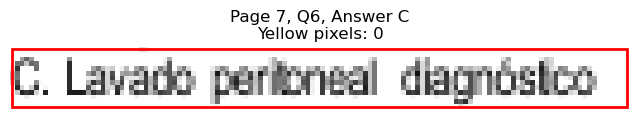

Page 7, Q6 - D: Detected box: x0=322.9, y0=483.4, x1=381.5, y1=495.4
Page 7, Q6, D: Yellow pixels: 933
Page 7, Q6, D: Total non-white pixels: 1365
Page 7, Q6, D: Yellow percentage: 68.4%


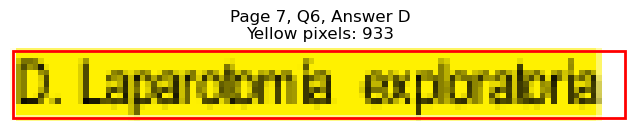

Page 7, Q6 - E: Detected box: x0=322.9, y0=495.4, x1=383.8, y1=507.4
Page 7, Q6, E: Yellow pixels: 103
Page 7, Q6, E: Total non-white pixels: 407
Page 7, Q6, E: Yellow percentage: 25.3%


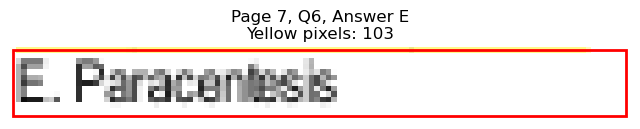


Page 7, Q6 - Selected Answer: D (based on yellow pixel count)




Page 7, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=184.8, y1=555.5
Page 7, Q7, A: Yellow pixels: 0
Page 7, Q7, A: Total non-white pixels: 771
Page 7, Q7, A: Yellow percentage: 0.0%


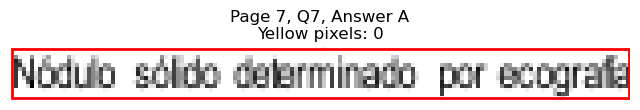

Page 7, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=177.2, y1=567.5
Page 7, Q7, B: Yellow pixels: 0
Page 7, Q7, B: Total non-white pixels: 696
Page 7, Q7, B: Yellow percentage: 0.0%


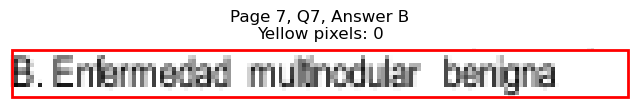

Page 7, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=240.2, y1=579.5
Page 7, Q7, C: Yellow pixels: 0
Page 7, Q7, C: Total non-white pixels: 764
Page 7, Q7, C: Yellow percentage: 0.0%


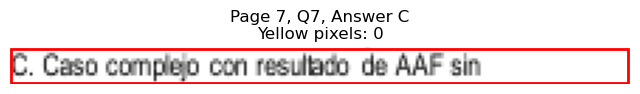

Page 7, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=434.0, y1=555.5
Page 7, Q7, D: Yellow pixels: 1462
Page 7, Q7, D: Total non-white pixels: 2119
Page 7, Q7, D: Yellow percentage: 69.0%


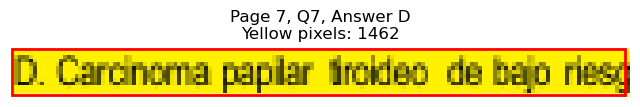

Page 7, Q7 - E: Detected box: x0=322.9, y0=567.5, x1=428.9, y1=579.5
Page 7, Q7, E: Yellow pixels: 73
Page 7, Q7, E: Total non-white pixels: 759
Page 7, Q7, E: Yellow percentage: 9.6%


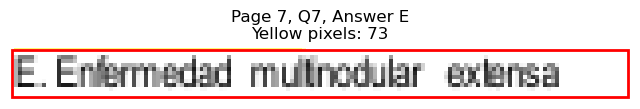


Page 7, Q7 - Selected Answer: D (based on yellow pixel count)




Page 7, Q8 - A: Detected box: x0=82.6, y0=615.5, x1=194.4, y1=627.5
Page 7, Q8, A: Yellow pixels: 0
Page 7, Q8, A: Total non-white pixels: 551
Page 7, Q8, A: Yellow percentage: 0.0%


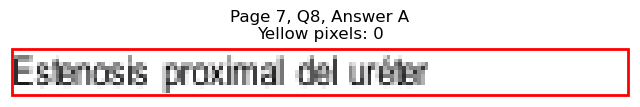

Page 7, Q8 - B: Detected box: x0=71.3, y0=627.5, x1=186.2, y1=639.6
Page 7, Q8, B: Yellow pixels: 0
Page 7, Q8, B: Total non-white pixels: 554
Page 7, Q8, B: Yellow percentage: 0.0%


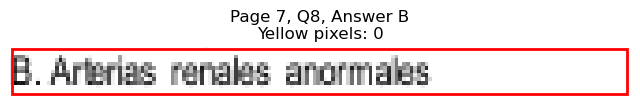

Page 7, Q8 - C: Detected box: x0=71.3, y0=639.5, x1=219.4, y1=651.6
Page 7, Q8, C: Yellow pixels: 1311
Page 7, Q8, C: Total non-white pixels: 1911
Page 7, Q8, C: Yellow percentage: 68.6%


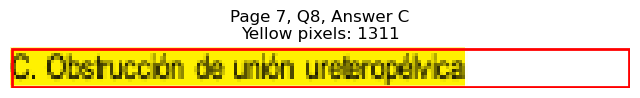

Page 7, Q8 - D: Detected box: x0=363.4, y0=615.5, x1=416.9, y1=627.5
Page 7, Q8, D: Yellow pixels: 0
Page 7, Q8, D: Total non-white pixels: 283
Page 7, Q8, D: Yellow percentage: 0.0%


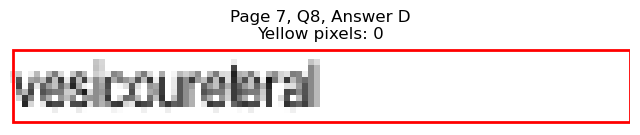

Page 7, Q8 - E: Detected box: x0=322.9, y0=627.5, x1=377.8, y1=639.6
Page 7, Q8, E: Yellow pixels: 0
Page 7, Q8, E: Total non-white pixels: 263
Page 7, Q8, E: Yellow percentage: 0.0%


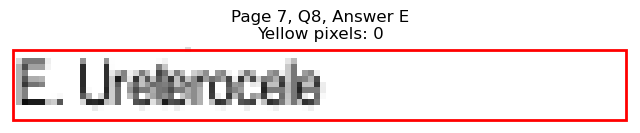


Page 7, Q8 - Selected Answer: C (based on yellow pixel count)




Page 7, Q9 - A: Detected box: x0=82.6, y0=676.3, x1=236.5, y1=688.3
Page 7, Q9, A: Yellow pixels: 0
Page 7, Q9, A: Total non-white pixels: 754
Page 7, Q9, A: Yellow percentage: 0.0%


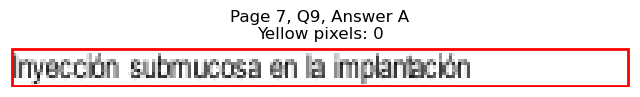

Page 7, Q9 - B: Detected box: x0=71.3, y0=688.3, x1=157.0, y1=700.3
Page 7, Q9, B: Yellow pixels: 0
Page 7, Q9, B: Total non-white pixels: 441
Page 7, Q9, B: Yellow percentage: 0.0%


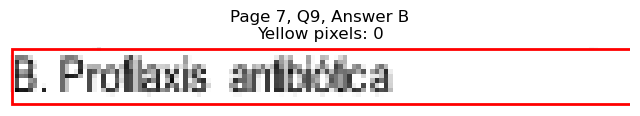

Page 7, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=132.2, y1=712.3
Page 7, Q9, C: Yellow pixels: 0
Page 7, Q9, C: Total non-white pixels: 288
Page 7, Q9, C: Yellow percentage: 0.0%


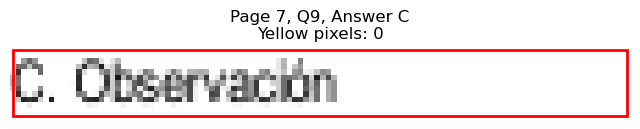

Page 7, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=392.0, y1=688.3
Page 7, Q9, D: Yellow pixels: 769
Page 7, Q9, D: Total non-white pixels: 1313
Page 7, Q9, D: Yellow percentage: 58.6%


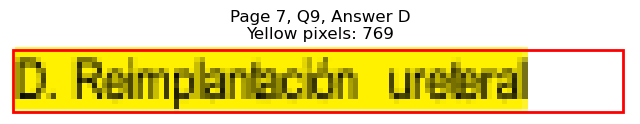

Page 7, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=423.5, y1=700.3
Page 7, Q9, E: Yellow pixels: 1
Page 7, Q9, E: Total non-white pixels: 585
Page 7, Q9, E: Yellow percentage: 0.2%


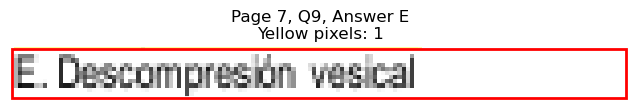


Page 7, Q9 - Selected Answer: D (based on yellow pixel count)




Page 7, Q10 - A: Detected box: x0=141.1, y0=736.4, x1=232.2, y1=748.4
Page 7, Q10, A: Yellow pixels: 773
Page 7, Q10, A: Total non-white pixels: 1157
Page 7, Q10, A: Yellow percentage: 66.8%


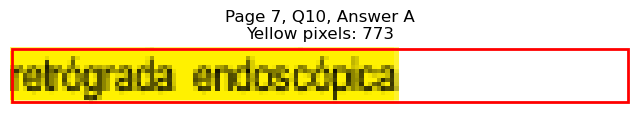

Page 7, Q10 - B: Detected box: x0=71.3, y0=748.4, x1=169.7, y1=760.4
Page 7, Q10, B: Yellow pixels: 137
Page 7, Q10, B: Total non-white pixels: 636
Page 7, Q10, B: Yellow percentage: 21.5%


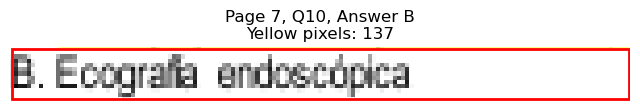

Page 7, Q10 - C: Detected box: x0=71.3, y0=760.4, x1=139.0, y1=772.4
Page 7, Q10, C: Yellow pixels: 0
Page 7, Q10, C: Total non-white pixels: 324
Page 7, Q10, C: Yellow percentage: 0.0%


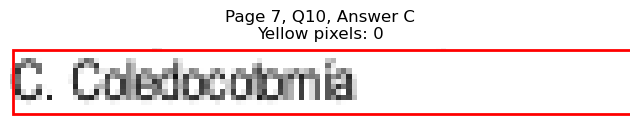

Page 7, Q10 - D: Detected box: x0=322.9, y0=736.4, x1=393.5, y1=748.4
Page 7, Q10, D: Yellow pixels: 0
Page 7, Q10, D: Total non-white pixels: 363
Page 7, Q10, D: Yellow percentage: 0.0%


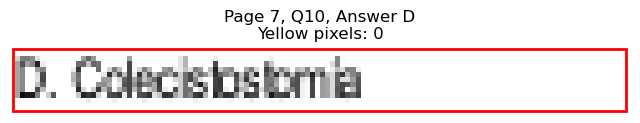

Page 7, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=402.6, y1=760.4
Page 7, Q10, E: Yellow pixels: 0
Page 7, Q10, E: Total non-white pixels: 390
Page 7, Q10, E: Yellow percentage: 0.0%


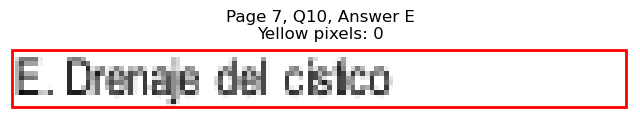


Page 7, Q10 - Selected Answer: A (based on yellow pixel count)





Page 8: Found 8 questions
Page 8, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=180.4, y1=121.6
Page 8, Q1, A: Yellow pixels: 803
Page 8, Q1, A: Total non-white pixels: 1248
Page 8, Q1, A: Yellow percentage: 64.3%


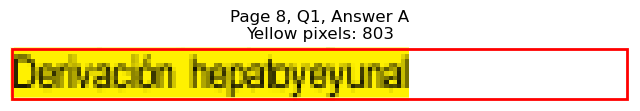

Page 8, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=196.9, y1=133.6
Page 8, Q1, B: Yellow pixels: 95
Page 8, Q1, B: Total non-white pixels: 729
Page 8, Q1, B: Yellow percentage: 13.0%


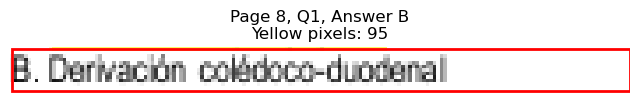

Page 8, Q1 - C: Detected box: x0=141.1, y0=133.5, x1=231.2, y1=145.6
Page 8, Q1, C: Yellow pixels: 0
Page 8, Q1, C: Total non-white pixels: 482
Page 8, Q1, C: Yellow percentage: 0.0%


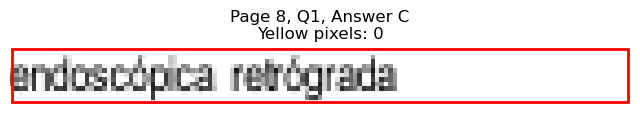

Page 8, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=411.5, y1=121.6
Page 8, Q1, D: Yellow pixels: 0
Page 8, Q1, D: Total non-white pixels: 731
Page 8, Q1, D: Yellow percentage: 0.0%


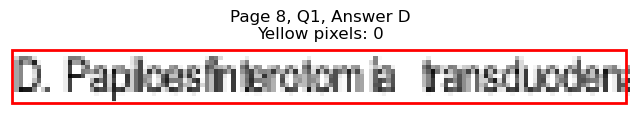

Page 8, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=429.5, y1=133.6
Page 8, Q1, E: Yellow pixels: 0
Page 8, Q1, E: Total non-white pixels: 526
Page 8, Q1, E: Yellow percentage: 0.0%


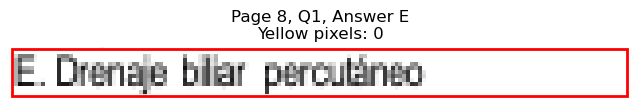


Page 8, Q1 - Selected Answer: A (based on yellow pixel count)




Page 8, Q2 - A: Detected box: x0=82.6, y0=193.6, x1=119.5, y1=205.6
Page 8, Q2, A: Yellow pixels: 0
Page 8, Q2, A: Total non-white pixels: 211
Page 8, Q2, A: Yellow percentage: 0.0%


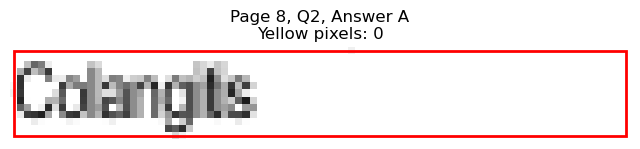

Page 8, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=121.7, y1=217.7
Page 8, Q2, B: Yellow pixels: 0
Page 8, Q2, B: Total non-white pixels: 265
Page 8, Q2, B: Yellow percentage: 0.0%


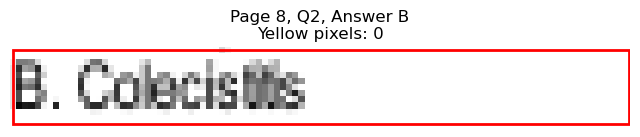

Page 8, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=167.5, y1=229.7
Page 8, Q2, C: Yellow pixels: 0
Page 8, Q2, C: Total non-white pixels: 669
Page 8, Q2, C: Yellow percentage: 0.0%


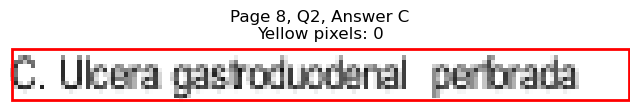

Page 8, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=378.5, y1=205.6
Page 8, Q2, D: Yellow pixels: 638
Page 8, Q2, D: Total non-white pixels: 1066
Page 8, Q2, D: Yellow percentage: 59.8%


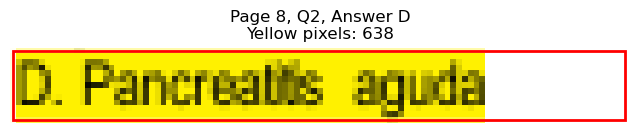

Page 8, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=434.9, y1=217.7
Page 8, Q2, E: Yellow pixels: 81
Page 8, Q2, E: Total non-white pixels: 654
Page 8, Q2, E: Yellow percentage: 12.4%


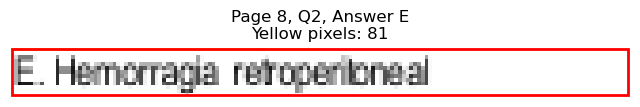


Page 8, Q2 - Selected Answer: D (based on yellow pixel count)




Page 8, Q3 - A: Detected box: x0=82.6, y0=265.7, x1=183.2, y1=277.7
Page 8, Q3, A: Yellow pixels: 0
Page 8, Q3, A: Total non-white pixels: 630
Page 8, Q3, A: Yellow percentage: 0.0%


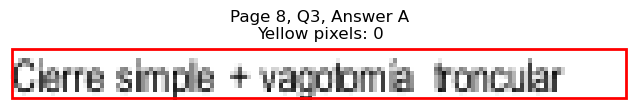

Page 8, Q3 - B: Detected box: x0=71.3, y0=277.7, x1=182.4, y1=289.7
Page 8, Q3, B: Yellow pixels: 0
Page 8, Q3, B: Total non-white pixels: 794
Page 8, Q3, B: Yellow percentage: 0.0%


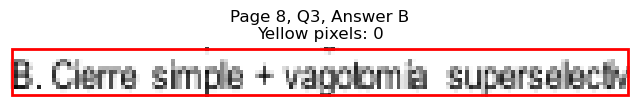

Page 8, Q3 - C: Detected box: x0=71.3, y0=289.7, x1=133.7, y1=301.8
Page 8, Q3, C: Yellow pixels: 0
Page 8, Q3, C: Total non-white pixels: 569
Page 8, Q3, C: Yellow percentage: 0.0%


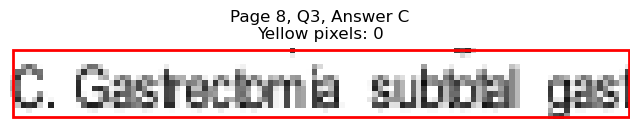

Page 8, Q3 - D: Detected box: x0=322.9, y0=265.7, x1=472.5, y1=277.7
Page 8, Q3, D: Yellow pixels: 1151
Page 8, Q3, D: Total non-white pixels: 1937
Page 8, Q3, D: Yellow percentage: 59.4%


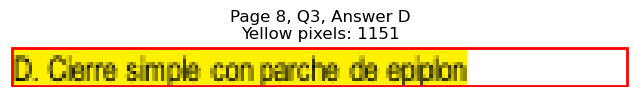

Page 8, Q3 - E: Detected box: x0=322.9, y0=277.7, x1=379.3, y1=289.7
Page 8, Q3, E: Yellow pixels: 103
Page 8, Q3, E: Total non-white pixels: 383
Page 8, Q3, E: Yellow percentage: 26.9%


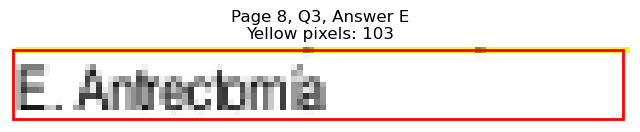


Page 8, Q3 - Selected Answer: D (based on yellow pixel count)




Page 8, Q4 - A: Detected box: x0=82.6, y0=326.5, x1=235.0, y1=338.5
Page 8, Q4, A: Yellow pixels: 0
Page 8, Q4, A: Total non-white pixels: 722
Page 8, Q4, A: Yellow percentage: 0.0%


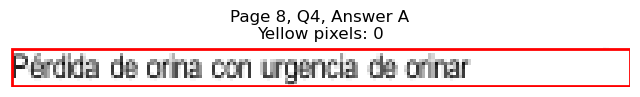

Page 8, Q4 - B: Detected box: x0=150.1, y0=338.5, x1=281.7, y1=350.5
Page 8, Q4, B: Yellow pixels: 1191
Page 8, Q4, B: Total non-white pixels: 1727
Page 8, Q4, B: Yellow percentage: 69.0%


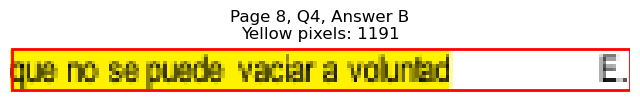

Page 8, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=198.2, y1=362.5
Page 8, Q4, C: Yellow pixels: 178
Page 8, Q4, C: Total non-white pixels: 750
Page 8, Q4, C: Yellow percentage: 23.7%


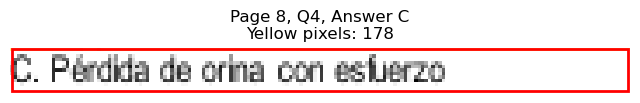

Page 8, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=449.8, y1=338.5
Page 8, Q4, D: Yellow pixels: 0
Page 8, Q4, D: Total non-white pixels: 631
Page 8, Q4, D: Yellow percentage: 0.0%


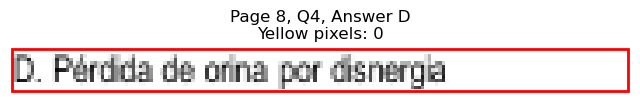

Page 8, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=360.5, y1=350.5
Page 8, Q4, E: Yellow pixels: 0
Page 8, Q4, E: Total non-white pixels: 166
Page 8, Q4, E: Yellow percentage: 0.0%


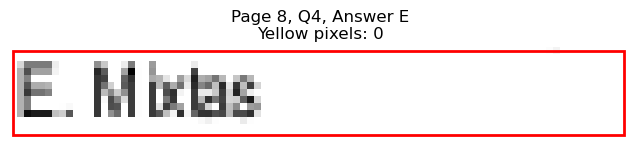


Page 8, Q4 - Selected Answer: B (based on yellow pixel count)




Page 8, Q5 - A: Detected box: x0=82.6, y0=434.6, x1=142.7, y1=446.6
Page 8, Q5, A: Yellow pixels: 0
Page 8, Q5, A: Total non-white pixels: 585
Page 8, Q5, A: Yellow percentage: 0.0%


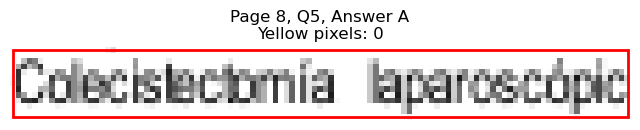

Page 8, Q5 - B: Detected box: x0=128.3, y0=446.6, x1=217.2, y1=458.6
Page 8, Q5, B: Yellow pixels: 680
Page 8, Q5, B: Total non-white pixels: 1131
Page 8, Q5, B: Yellow percentage: 60.1%


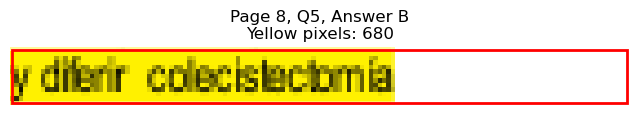

Page 8, Q5 - C: Detected box: x0=71.3, y0=458.6, x1=142.0, y1=470.6
Page 8, Q5, C: Yellow pixels: 121
Page 8, Q5, C: Total non-white pixels: 607
Page 8, Q5, C: Yellow percentage: 19.9%


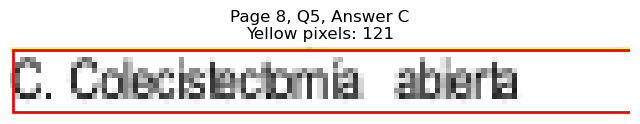

Page 8, Q5 - D: Detected box: x0=322.9, y0=434.6, x1=393.6, y1=446.6
Page 8, Q5, D: Yellow pixels: 0
Page 8, Q5, D: Total non-white pixels: 621
Page 8, Q5, D: Yellow percentage: 0.0%


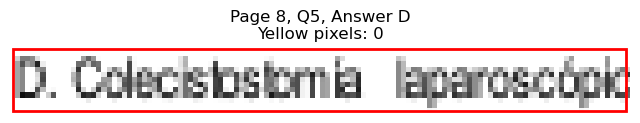

Page 8, Q5 - E: Detected box: x0=322.9, y0=446.6, x1=393.5, y1=458.6
Page 8, Q5, E: Yellow pixels: 0
Page 8, Q5, E: Total non-white pixels: 586
Page 8, Q5, E: Yellow percentage: 0.0%


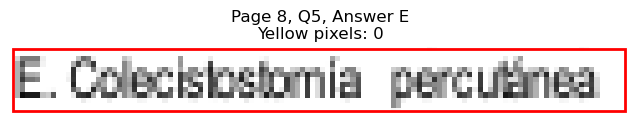


Page 8, Q5 - Selected Answer: B (based on yellow pixel count)




Page 8, Q6 - A: Detected box: x0=82.6, y0=531.4, x1=244.9, y1=543.5
Page 8, Q6, A: Yellow pixels: 0
Page 8, Q6, A: Total non-white pixels: 770
Page 8, Q6, A: Yellow percentage: 0.0%


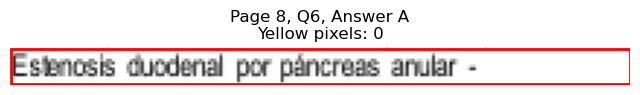

Page 8, Q6 - B: Detected box: x0=162.8, y0=555.4, x1=259.9, y1=567.5
Page 8, Q6, B: Yellow pixels: 0
Page 8, Q6, B: Total non-white pixels: 484
Page 8, Q6, B: Yellow percentage: 0.0%


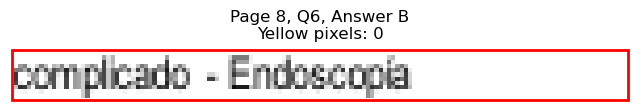

Page 8, Q6 - C: Detected box: x0=71.3, y0=579.4, x1=268.2, y1=591.5
Page 8, Q6, C: Yellow pixels: 1742
Page 8, Q6, C: Total non-white pixels: 2535
Page 8, Q6, C: Yellow percentage: 68.7%


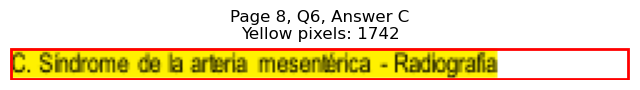

Page 8, Q6 - D: Detected box: x0=322.9, y0=531.4, x1=515.2, y1=543.5
Page 8, Q6, D: Yellow pixels: 0
Page 8, Q6, D: Total non-white pixels: 880
Page 8, Q6, D: Yellow percentage: 0.0%


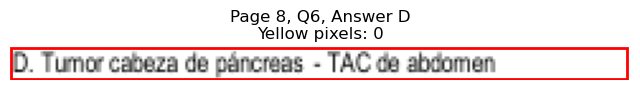

Page 8, Q6 - E: Detected box: x0=322.9, y0=543.4, x1=401.0, y1=555.5
Page 8, Q6, E: Yellow pixels: 0
Page 8, Q6, E: Total non-white pixels: 628
Page 8, Q6, E: Yellow percentage: 0.0%


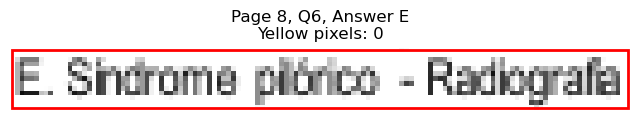


Page 8, Q6 - Selected Answer: C (based on yellow pixel count)




Page 8, Q7 - A: Detected box: x0=82.6, y0=627.5, x1=195.3, y1=639.6
Page 8, Q7, A: Yellow pixels: 0
Page 8, Q7, A: Total non-white pixels: 828
Page 8, Q7, A: Yellow percentage: 0.0%


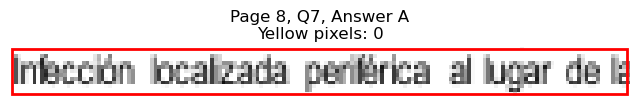

Page 8, Q7 - B: Detected box: x0=71.3, y0=639.5, x1=129.2, y1=651.6
Page 8, Q7, B: Yellow pixels: 0
Page 8, Q7, B: Total non-white pixels: 294
Page 8, Q7, B: Yellow percentage: 0.0%


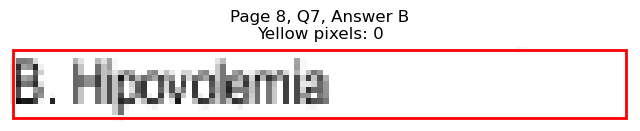

Page 8, Q7 - C: Detected box: x0=71.3, y0=651.5, x1=163.7, y1=663.6
Page 8, Q7, C: Yellow pixels: 0
Page 8, Q7, C: Total non-white pixels: 402
Page 8, Q7, C: Yellow percentage: 0.0%


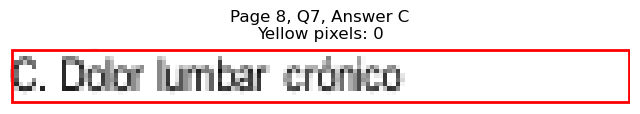

Page 8, Q7 - D: Detected box: x0=322.9, y0=627.5, x1=424.3, y1=639.6
Page 8, Q7, D: Yellow pixels: 1379
Page 8, Q7, D: Total non-white pixels: 1989
Page 8, Q7, D: Yellow percentage: 69.3%


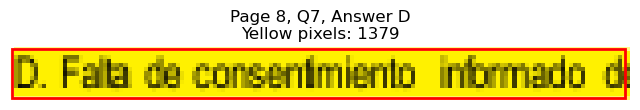

Page 8, Q7 - E: Detected box: x0=322.9, y0=639.5, x1=490.2, y1=651.6
Page 8, Q7, E: Yellow pixels: 190
Page 8, Q7, E: Total non-white pixels: 997
Page 8, Q7, E: Yellow percentage: 19.1%


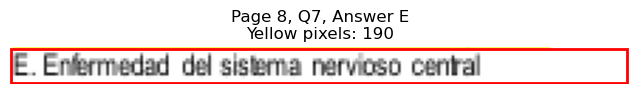


Page 8, Q7 - Selected Answer: D (based on yellow pixel count)




Page 8, Q8 - A: Detected box: x0=82.6, y0=688.3, x1=116.5, y1=700.3
Page 8, Q8, A: Yellow pixels: 0
Page 8, Q8, A: Total non-white pixels: 304
Page 8, Q8, A: Yellow percentage: 0.0%


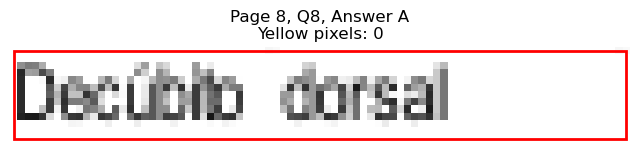

Page 8, Q8 - B: Detected box: x0=118.6, y0=700.3, x1=220.8, y1=712.3
Page 8, Q8, B: Yellow pixels: 0
Page 8, Q8, B: Total non-white pixels: 519
Page 8, Q8, B: Yellow percentage: 0.0%


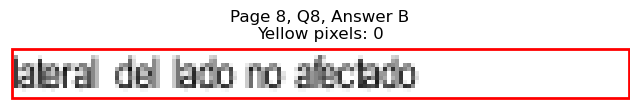

Page 8, Q8 - C: Detected box: x0=71.3, y0=712.3, x1=142.1, y1=724.4
Page 8, Q8, C: Yellow pixels: 579
Page 8, Q8, C: Total non-white pixels: 897
Page 8, Q8, C: Yellow percentage: 64.5%


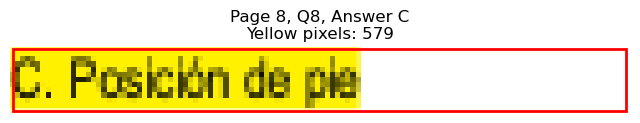

Page 8, Q8 - D: Detected box: x0=322.9, y0=688.3, x1=393.5, y1=700.3
Page 8, Q8, D: Yellow pixels: 0
Page 8, Q8, D: Total non-white pixels: 606
Page 8, Q8, D: Yellow percentage: 0.0%


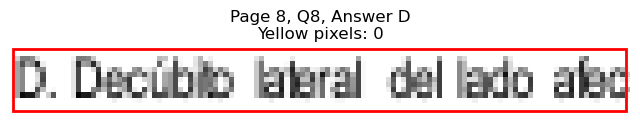

Page 8, Q8 - E: Detected box: x0=322.9, y0=700.3, x1=367.3, y1=712.3
Page 8, Q8, E: Yellow pixels: 0
Page 8, Q8, E: Total non-white pixels: 324
Page 8, Q8, E: Yellow percentage: 0.0%


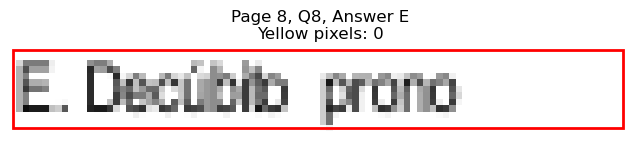


Page 8, Q8 - Selected Answer: C (based on yellow pixel count)





Page 9: Found 9 questions
Page 9, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=134.6, y1=145.6
Page 9, Q1, A: Yellow pixels: 368
Page 9, Q1, A: Total non-white pixels: 665
Page 9, Q1, A: Yellow percentage: 55.3%


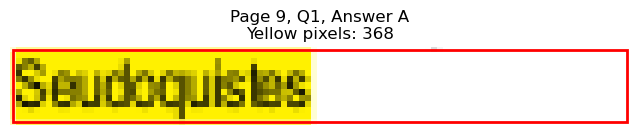

Page 9, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=153.2, y1=157.6
Page 9, Q1, B: Yellow pixels: 49
Page 9, Q1, B: Total non-white pixels: 469
Page 9, Q1, B: Yellow percentage: 10.4%


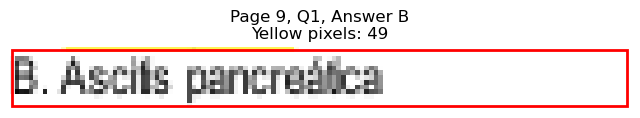

Page 9, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=178.0, y1=169.6
Page 9, Q1, C: Yellow pixels: 0
Page 9, Q1, C: Total non-white pixels: 542
Page 9, Q1, C: Yellow percentage: 0.0%


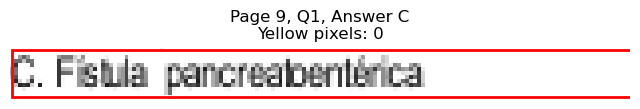

Page 9, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=434.8, y1=145.6
Page 9, Q1, D: Yellow pixels: 0
Page 9, Q1, D: Total non-white pixels: 538
Page 9, Q1, D: Yellow percentage: 0.0%


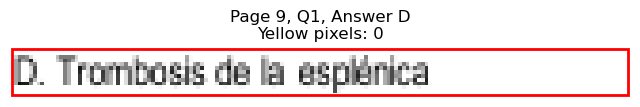

Page 9, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=422.0, y1=157.6
Page 9, Q1, E: Yellow pixels: 0
Page 9, Q1, E: Total non-white pixels: 486
Page 9, Q1, E: Yellow percentage: 0.0%


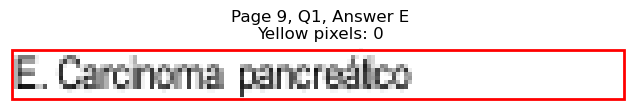


Page 9, Q1 - Selected Answer: A (based on yellow pixel count)




Page 9, Q2 - A: Detected box: x0=71.3, y0=193.6, x1=79.7, y1=205.6
Page 9, Q2, A: Yellow pixels: 0
Page 9, Q2, A: Total non-white pixels: 54
Page 9, Q2, A: Yellow percentage: 0.0%


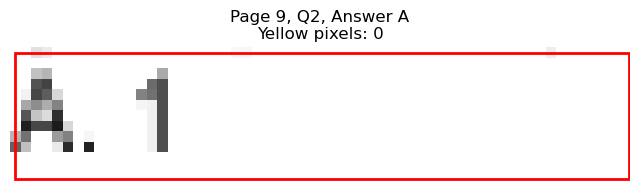

Page 9, Q2 - B: Detected box: x0=71.3, y0=205.6, x1=88.7, y1=217.7
Page 9, Q2, B: Yellow pixels: 132
Page 9, Q2, B: Total non-white pixels: 208
Page 9, Q2, B: Yellow percentage: 63.5%


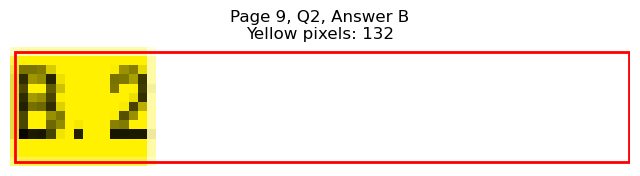

Page 9, Q2 - C: Detected box: x0=71.3, y0=217.6, x1=89.5, y1=229.7
Page 9, Q2, C: Yellow pixels: 15
Page 9, Q2, C: Total non-white pixels: 73
Page 9, Q2, C: Yellow percentage: 20.5%


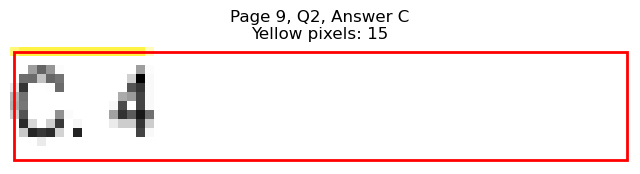

Page 9, Q2 - D: Detected box: x0=322.9, y0=193.6, x1=341.0, y1=205.6
Page 9, Q2, D: Yellow pixels: 0
Page 9, Q2, D: Total non-white pixels: 75
Page 9, Q2, D: Yellow percentage: 0.0%


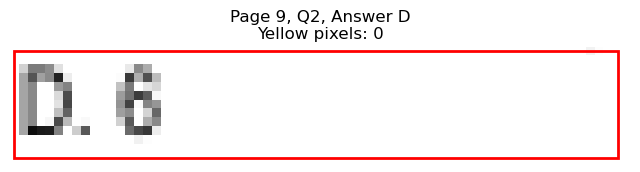

Page 9, Q2 - E: Detected box: x0=322.9, y0=205.6, x1=344.8, y1=217.7
Page 9, Q2, E: Yellow pixels: 0
Page 9, Q2, E: Total non-white pixels: 86
Page 9, Q2, E: Yellow percentage: 0.0%


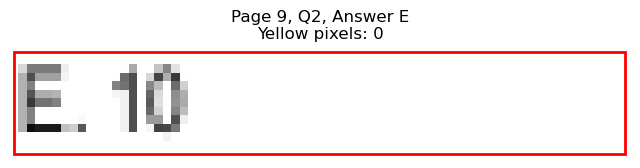


Page 9, Q2 - Selected Answer: B (based on yellow pixel count)




Page 9, Q3 - A: Detected box: x0=145.6, y0=253.6, x1=230.5, y1=265.7
Page 9, Q3, A: Yellow pixels: 0
Page 9, Q3, A: Total non-white pixels: 619
Page 9, Q3, A: Yellow percentage: 0.0%


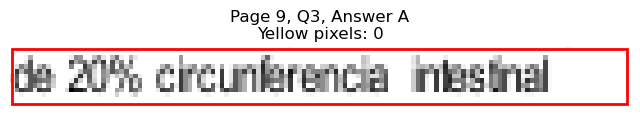

Page 9, Q3 - B: Detected box: x0=71.3, y0=265.7, x1=162.2, y1=277.7
Page 9, Q3, B: Yellow pixels: 0
Page 9, Q3, B: Total non-white pixels: 626
Page 9, Q3, B: Yellow percentage: 0.0%


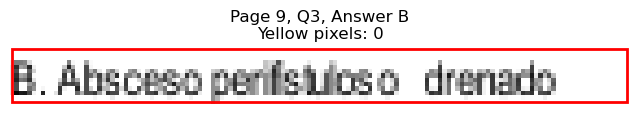

Page 9, Q3 - C: Detected box: x0=117.9, y0=277.7, x1=162.2, y1=289.7
Page 9, Q3, C: Yellow pixels: 0
Page 9, Q3, C: Total non-white pixels: 454
Page 9, Q3, C: Yellow percentage: 0.0%


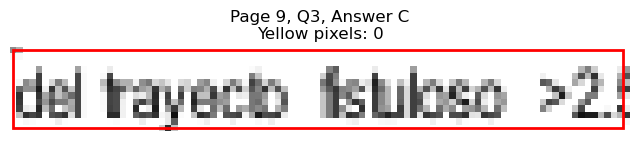

Page 9, Q3 - D: Detected box: x0=322.9, y0=253.6, x1=465.5, y1=265.7
Page 9, Q3, D: Yellow pixels: 0
Page 9, Q3, D: Total non-white pixels: 675
Page 9, Q3, D: Yellow percentage: 0.0%


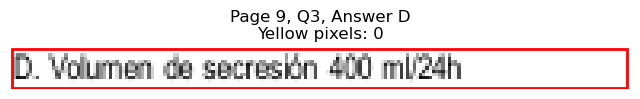

Page 9, Q3 - E: Detected box: x0=322.9, y0=265.7, x1=442.4, y1=277.7
Page 9, Q3, E: Yellow pixels: 934
Page 9, Q3, E: Total non-white pixels: 1546
Page 9, Q3, E: Yellow percentage: 60.4%


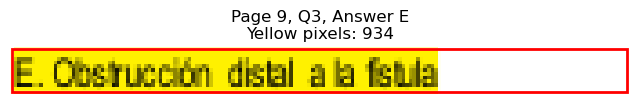


Page 9, Q3 - Selected Answer: E (based on yellow pixel count)




Page 9, Q4 - A: Detected box: x0=82.6, y0=350.5, x1=147.2, y1=362.5
Page 9, Q4, A: Yellow pixels: 0
Page 9, Q4, A: Total non-white pixels: 337
Page 9, Q4, A: Yellow percentage: 0.0%


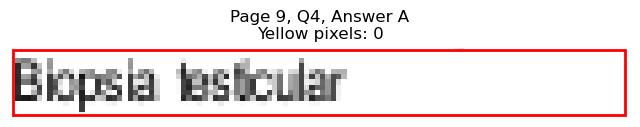

Page 9, Q4 - B: Detected box: x0=71.3, y0=362.5, x1=134.5, y1=374.6
Page 9, Q4, B: Yellow pixels: 0
Page 9, Q4, B: Total non-white pixels: 330
Page 9, Q4, B: Yellow percentage: 0.0%


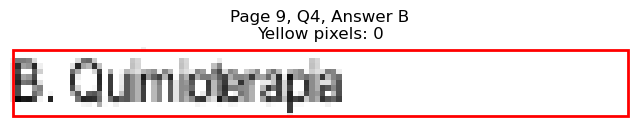

Page 9, Q4 - C: Detected box: x0=71.3, y0=374.5, x1=130.0, y1=386.6
Page 9, Q4, C: Yellow pixels: 0
Page 9, Q4, C: Total non-white pixels: 561
Page 9, Q4, C: Yellow percentage: 0.0%


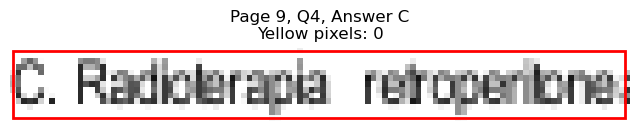

Page 9, Q4 - D: Detected box: x0=322.9, y0=350.5, x1=386.8, y1=362.5
Page 9, Q4, D: Yellow pixels: 1012
Page 9, Q4, D: Total non-white pixels: 1495
Page 9, Q4, D: Yellow percentage: 67.7%


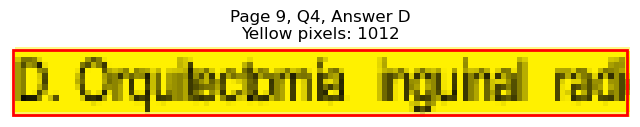

Page 9, Q4 - E: Detected box: x0=322.9, y0=362.5, x1=386.1, y1=374.6
Page 9, Q4, E: Yellow pixels: 114
Page 9, Q4, E: Total non-white pixels: 681
Page 9, Q4, E: Yellow percentage: 16.7%


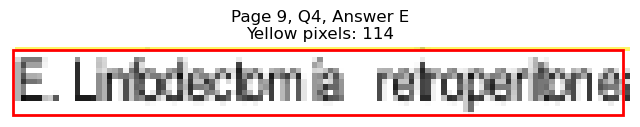


Page 9, Q4 - Selected Answer: D (based on yellow pixel count)




Page 9, Q5 - A: Detected box: x0=82.6, y0=422.5, x1=193.9, y1=434.6
Page 9, Q5, A: Yellow pixels: 868
Page 9, Q5, A: Total non-white pixels: 1431
Page 9, Q5, A: Yellow percentage: 60.7%


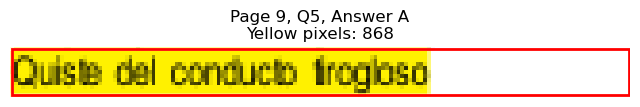

Page 9, Q5 - B: Detected box: x0=128.3, y0=434.6, x1=204.2, y1=446.6
Page 9, Q5, B: Yellow pixels: 63
Page 9, Q5, B: Total non-white pixels: 453
Page 9, Q5, B: Yellow percentage: 13.9%


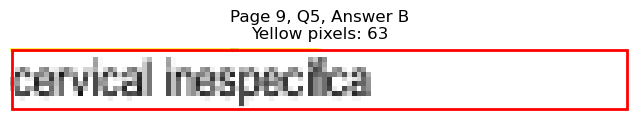

Page 9, Q5 - C: Detected box: x0=71.3, y0=446.6, x1=134.5, y1=458.6
Page 9, Q5, C: Yellow pixels: 0
Page 9, Q5, C: Total non-white pixels: 305
Page 9, Q5, C: Yellow percentage: 0.0%


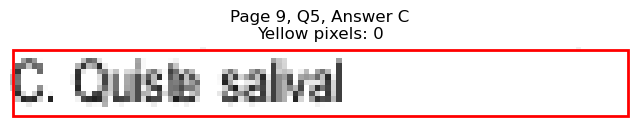

Page 9, Q5 - D: Detected box: x0=322.9, y0=422.5, x1=394.3, y1=434.6
Page 9, Q5, D: Yellow pixels: 0
Page 9, Q5, D: Total non-white pixels: 367
Page 9, Q5, D: Yellow percentage: 0.0%


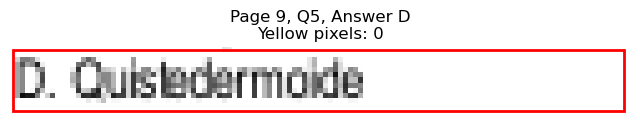

Page 9, Q5 - E: Detected box: x0=322.9, y0=434.6, x1=398.1, y1=446.6
Page 9, Q5, E: Yellow pixels: 0
Page 9, Q5, E: Total non-white pixels: 370
Page 9, Q5, E: Yellow percentage: 0.0%


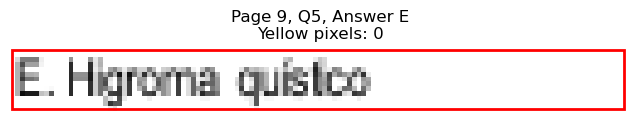


Page 9, Q5 - Selected Answer: A (based on yellow pixel count)




Page 9, Q6 - A: Detected box: x0=82.6, y0=507.4, x1=140.5, y1=519.4
Page 9, Q6, A: Yellow pixels: 0
Page 9, Q6, A: Total non-white pixels: 286
Page 9, Q6, A: Yellow percentage: 0.0%


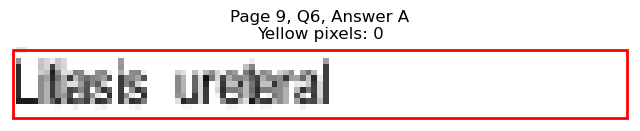

Page 9, Q6 - B: Detected box: x0=71.3, y0=519.4, x1=126.3, y1=531.4
Page 9, Q6, B: Yellow pixels: 467
Page 9, Q6, B: Total non-white pixels: 689
Page 9, Q6, B: Yellow percentage: 67.8%


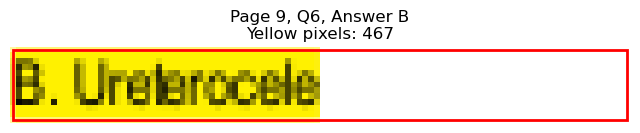

Page 9, Q6 - C: Detected box: x0=111.8, y0=531.4, x1=167.5, y1=543.5
Page 9, Q6, C: Yellow pixels: 13
Page 9, Q6, C: Total non-white pixels: 290
Page 9, Q6, C: Yellow percentage: 4.5%


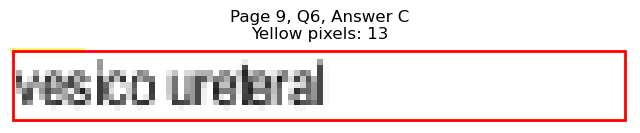

Page 9, Q6 - D: Detected box: x0=322.9, y0=507.4, x1=425.0, y1=519.4
Page 9, Q6, D: Yellow pixels: 0
Page 9, Q6, D: Total non-white pixels: 507
Page 9, Q6, D: Yellow percentage: 0.0%


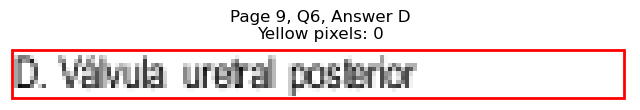

Page 9, Q6 - E: Detected box: x0=322.9, y0=519.4, x1=435.5, y1=531.4
Page 9, Q6, E: Yellow pixels: 0
Page 9, Q6, E: Total non-white pixels: 558
Page 9, Q6, E: Yellow percentage: 0.0%


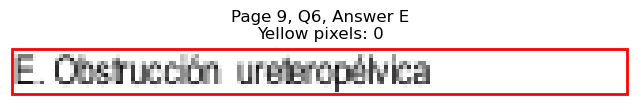


Page 9, Q6 - Selected Answer: B (based on yellow pixel count)




Page 9, Q7 - A: Detected box: x0=82.6, y0=567.5, x1=130.0, y1=579.5
Page 9, Q7, A: Yellow pixels: 0
Page 9, Q7, A: Total non-white pixels: 467
Page 9, Q7, A: Yellow percentage: 0.0%


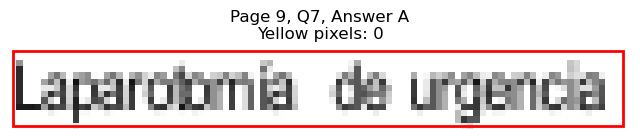

Page 9, Q7 - B: Detected box: x0=71.3, y0=579.4, x1=178.0, y1=591.5
Page 9, Q7, B: Yellow pixels: 0
Page 9, Q7, B: Total non-white pixels: 536
Page 9, Q7, B: Yellow percentage: 0.0%


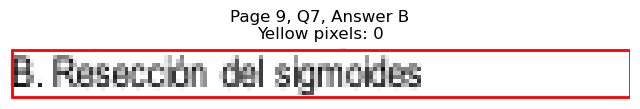

Page 9, Q7 - C: Detected box: x0=71.3, y0=591.5, x1=125.5, y1=603.5
Page 9, Q7, C: Yellow pixels: 0
Page 9, Q7, C: Total non-white pixels: 251
Page 9, Q7, C: Yellow percentage: 0.0%


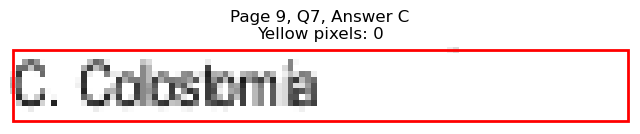

Page 9, Q7 - D: Detected box: x0=322.9, y0=567.5, x1=401.8, y1=579.5
Page 9, Q7, D: Yellow pixels: 0
Page 9, Q7, D: Total non-white pixels: 392
Page 9, Q7, D: Yellow percentage: 0.0%


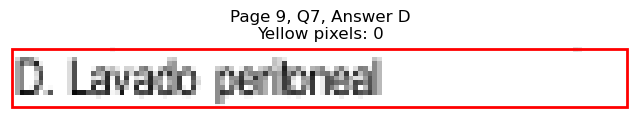

Page 9, Q7 - E: Detected box: x0=322.9, y0=579.4, x1=408.5, y1=591.5
Page 9, Q7, E: Yellow pixels: 1235
Page 9, Q7, E: Total non-white pixels: 1781
Page 9, Q7, E: Yellow percentage: 69.3%


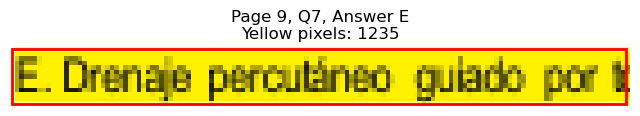


Page 9, Q7 - Selected Answer: E (based on yellow pixel count)




Page 9, Q8 - A: Detected box: x0=140.3, y0=627.5, x1=251.0, y1=639.6
Page 9, Q8, A: Yellow pixels: 979
Page 9, Q8, A: Total non-white pixels: 1417
Page 9, Q8, A: Yellow percentage: 69.1%


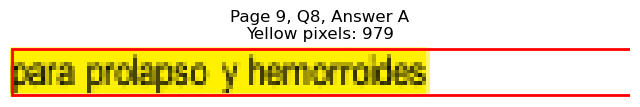

Page 9, Q8 - B: Detected box: x0=139.6, y0=639.5, x1=221.4, y1=651.6
Page 9, Q8, B: Yellow pixels: 109
Page 9, Q8, B: Total non-white pixels: 519
Page 9, Q8, B: Yellow percentage: 21.0%


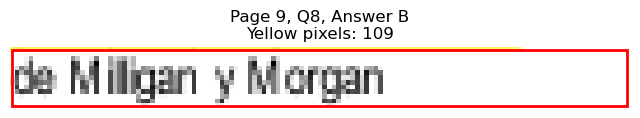

Page 9, Q8 - C: Detected box: x0=71.3, y0=651.5, x1=189.2, y1=663.6
Page 9, Q8, C: Yellow pixels: 0
Page 9, Q8, C: Total non-white pixels: 548
Page 9, Q8, C: Yellow percentage: 0.0%


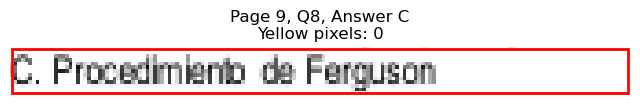

Page 9, Q8 - D: Detected box: x0=322.9, y0=627.5, x1=428.0, y1=639.6
Page 9, Q8, D: Yellow pixels: 0
Page 9, Q8, D: Total non-white pixels: 504
Page 9, Q8, D: Yellow percentage: 0.0%


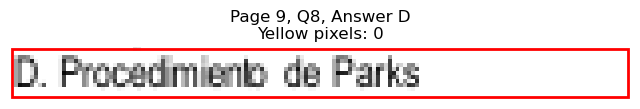

Page 9, Q8 - E: Detected box: x0=322.9, y0=639.5, x1=388.3, y1=651.6
Page 9, Q8, E: Yellow pixels: 0
Page 9, Q8, E: Total non-white pixels: 595
Page 9, Q8, E: Yellow percentage: 0.0%


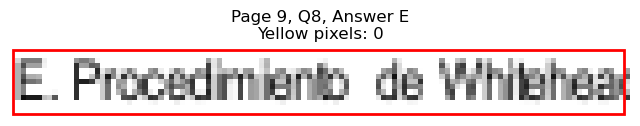


Page 9, Q8 - Selected Answer: A (based on yellow pixel count)




Page 9, Q9 - A: Detected box: x0=82.6, y0=688.3, x1=129.3, y1=700.3
Page 9, Q9, A: Yellow pixels: 666
Page 9, Q9, A: Total non-white pixels: 1131
Page 9, Q9, A: Yellow percentage: 58.9%


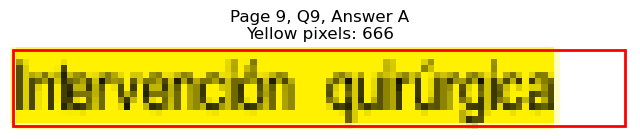

Page 9, Q9 - B: Detected box: x0=71.3, y0=700.3, x1=127.7, y1=712.3
Page 9, Q9, B: Yellow pixels: 3
Page 9, Q9, B: Total non-white pixels: 604
Page 9, Q9, B: Yellow percentage: 0.5%


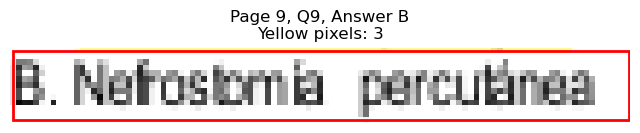

Page 9, Q9 - C: Detected box: x0=71.3, y0=712.3, x1=133.0, y1=724.4
Page 9, Q9, C: Yellow pixels: 0
Page 9, Q9, C: Total non-white pixels: 291
Page 9, Q9, C: Yellow percentage: 0.0%


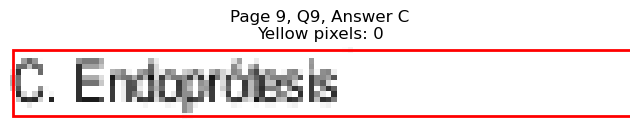

Page 9, Q9 - D: Detected box: x0=373.1, y0=688.3, x1=426.5, y1=700.3
Page 9, Q9, D: Yellow pixels: 0
Page 9, Q9, D: Total non-white pixels: 281
Page 9, Q9, D: Yellow percentage: 0.0%


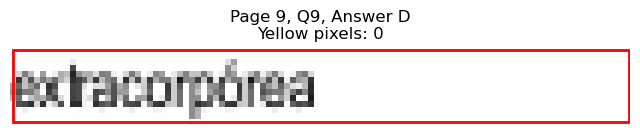

Page 9, Q9 - E: Detected box: x0=322.9, y0=700.3, x1=385.3, y1=712.3
Page 9, Q9, E: Yellow pixels: 0
Page 9, Q9, E: Total non-white pixels: 510
Page 9, Q9, E: Yellow percentage: 0.0%


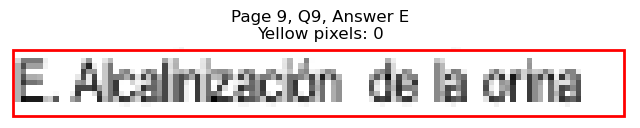


Page 9, Q9 - Selected Answer: A (based on yellow pixel count)





Page 10: Found 10 questions
Page 10, Q1 - A: Detected box: x0=82.6, y0=133.5, x1=124.0, y1=145.6
Page 10, Q1, A: Yellow pixels: 0
Page 10, Q1, A: Total non-white pixels: 371
Page 10, Q1, A: Yellow percentage: 0.0%


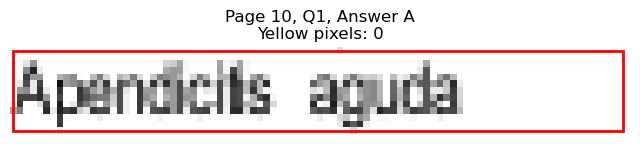

Page 10, Q1 - B: Detected box: x0=71.3, y0=145.6, x1=166.0, y1=157.6
Page 10, Q1, B: Yellow pixels: 0
Page 10, Q1, B: Total non-white pixels: 484
Page 10, Q1, B: Yellow percentage: 0.0%


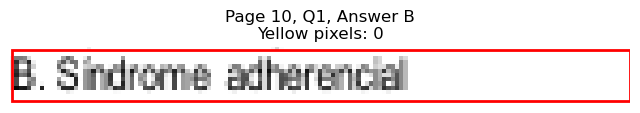

Page 10, Q1 - C: Detected box: x0=71.3, y0=157.6, x1=136.7, y1=169.6
Page 10, Q1, C: Yellow pixels: 0
Page 10, Q1, C: Total non-white pixels: 325
Page 10, Q1, C: Yellow percentage: 0.0%


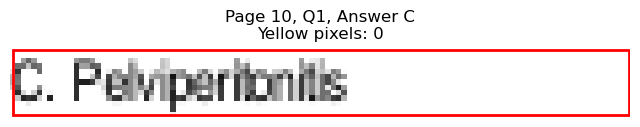

Page 10, Q1 - D: Detected box: x0=322.9, y0=133.5, x1=389.9, y1=145.6
Page 10, Q1, D: Yellow pixels: 510
Page 10, Q1, D: Total non-white pixels: 860
Page 10, Q1, D: Yellow percentage: 59.3%


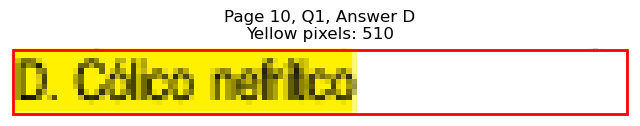

Page 10, Q1 - E: Detected box: x0=322.9, y0=145.6, x1=417.5, y1=157.6
Page 10, Q1, E: Yellow pixels: 64
Page 10, Q1, E: Total non-white pixels: 520
Page 10, Q1, E: Yellow percentage: 12.3%


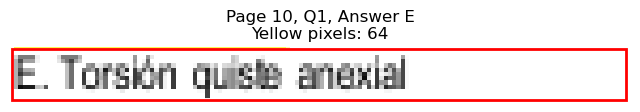


Page 10, Q1 - Selected Answer: D (based on yellow pixel count)




Page 10, Q2 - A: Detected box: x0=82.6, y0=205.6, x1=159.2, y1=217.7
Page 10, Q2, A: Yellow pixels: 0
Page 10, Q2, A: Total non-white pixels: 356
Page 10, Q2, A: Yellow percentage: 0.0%


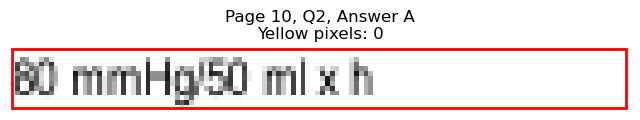

Page 10, Q2 - B: Detected box: x0=71.3, y0=217.6, x1=158.4, y1=229.7
Page 10, Q2, B: Yellow pixels: 0
Page 10, Q2, B: Total non-white pixels: 402
Page 10, Q2, B: Yellow percentage: 0.0%


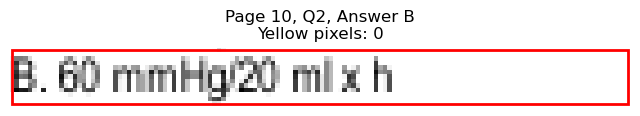

Page 10, Q2 - C: Detected box: x0=71.3, y0=229.6, x1=159.3, y1=241.7
Page 10, Q2, C: Yellow pixels: 716
Page 10, Q2, C: Total non-white pixels: 1118
Page 10, Q2, C: Yellow percentage: 64.0%


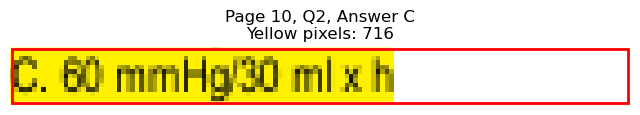

Page 10, Q2 - D: Detected box: x0=322.9, y0=205.6, x1=410.7, y1=217.7
Page 10, Q2, D: Yellow pixels: 0
Page 10, Q2, D: Total non-white pixels: 402
Page 10, Q2, D: Yellow percentage: 0.0%


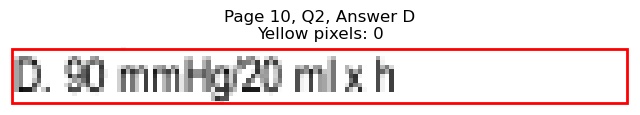

Page 10, Q2 - E: Detected box: x0=322.9, y0=217.6, x1=415.2, y1=229.7
Page 10, Q2, E: Yellow pixels: 0
Page 10, Q2, E: Total non-white pixels: 418
Page 10, Q2, E: Yellow percentage: 0.0%


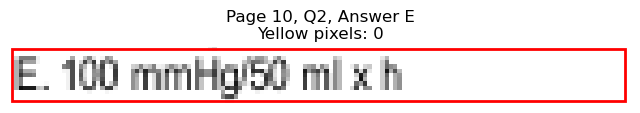


Page 10, Q2 - Selected Answer: C (based on yellow pixel count)




Page 10, Q3 - A: Detected box: x0=82.6, y0=277.7, x1=99.3, y1=289.7
Page 10, Q3, A: Yellow pixels: 0
Page 10, Q3, A: Total non-white pixels: 47
Page 10, Q3, A: Yellow percentage: 0.0%


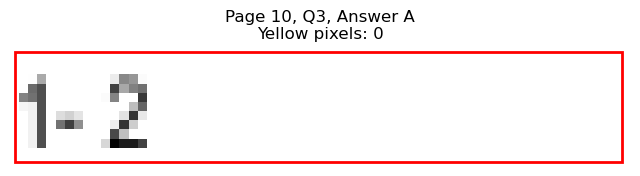

Page 10, Q3 - B: Detected box: x0=71.3, y0=289.7, x1=101.5, y1=301.8
Page 10, Q3, B: Yellow pixels: 0
Page 10, Q3, B: Total non-white pixels: 102
Page 10, Q3, B: Yellow percentage: 0.0%


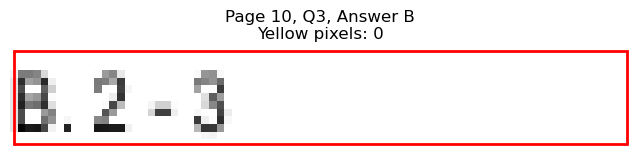

Page 10, Q3 - C: Detected box: x0=71.3, y0=302.5, x1=106.0, y1=314.5
Page 10, Q3, C: Yellow pixels: 0
Page 10, Q3, C: Total non-white pixels: 111
Page 10, Q3, C: Yellow percentage: 0.0%


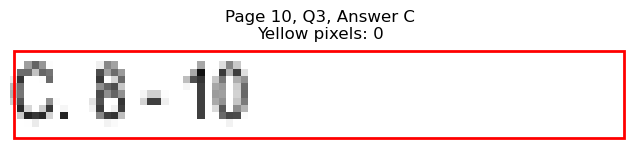

Page 10, Q3 - D: Detected box: x0=322.9, y0=277.7, x1=353.1, y1=289.7
Page 10, Q3, D: Yellow pixels: 252
Page 10, Q3, D: Total non-white pixels: 377
Page 10, Q3, D: Yellow percentage: 66.8%


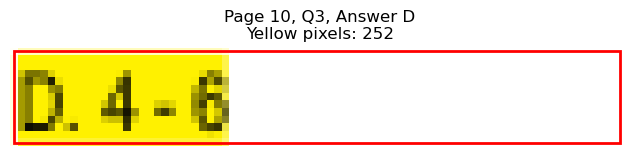

Page 10, Q3 - E: Detected box: x0=322.9, y0=289.7, x1=375.5, y1=301.8
Page 10, Q3, E: Yellow pixels: 28
Page 10, Q3, E: Total non-white pixels: 261
Page 10, Q3, E: Yellow percentage: 10.7%


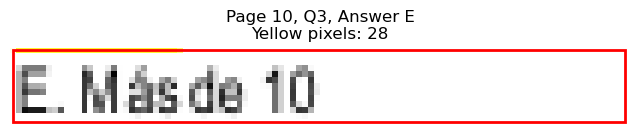


Page 10, Q3 - Selected Answer: D (based on yellow pixel count)




Page 10, Q4 - A: Detected box: x0=82.6, y0=338.5, x1=136.0, y1=350.5
Page 10, Q4, A: Yellow pixels: 0
Page 10, Q4, A: Total non-white pixels: 275
Page 10, Q4, A: Yellow percentage: 0.0%


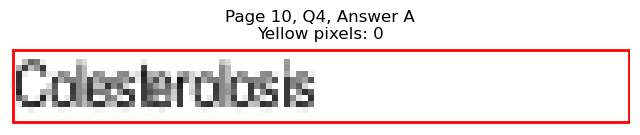

Page 10, Q4 - B: Detected box: x0=71.3, y0=350.5, x1=143.5, y1=362.5
Page 10, Q4, B: Yellow pixels: 0
Page 10, Q4, B: Total non-white pixels: 345
Page 10, Q4, B: Yellow percentage: 0.0%


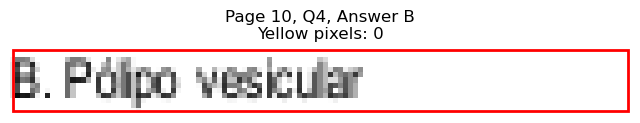

Page 10, Q4 - C: Detected box: x0=124.6, y0=362.5, x1=192.2, y1=374.6
Page 10, Q4, C: Yellow pixels: 0
Page 10, Q4, C: Total non-white pixels: 335
Page 10, Q4, C: Yellow percentage: 0.0%


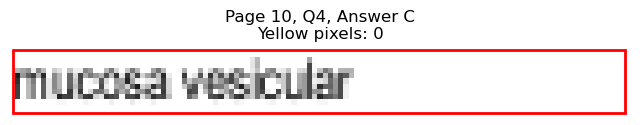

Page 10, Q4 - D: Detected box: x0=322.9, y0=338.5, x1=400.3, y1=350.5
Page 10, Q4, D: Yellow pixels: 0
Page 10, Q4, D: Total non-white pixels: 362
Page 10, Q4, D: Yellow percentage: 0.0%


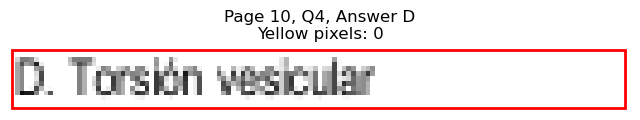

Page 10, Q4 - E: Detected box: x0=322.9, y0=350.5, x1=404.9, y1=362.5
Page 10, Q4, E: Yellow pixels: 719
Page 10, Q4, E: Total non-white pixels: 1053
Page 10, Q4, E: Yellow percentage: 68.3%


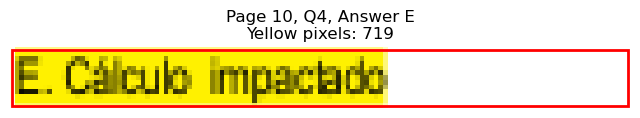


Page 10, Q4 - Selected Answer: E (based on yellow pixel count)




Page 10, Q5 - A: Detected box: x0=82.6, y0=398.5, x1=167.6, y1=410.6
Page 10, Q5, A: Yellow pixels: 727
Page 10, Q5, A: Total non-white pixels: 1094
Page 10, Q5, A: Yellow percentage: 66.5%


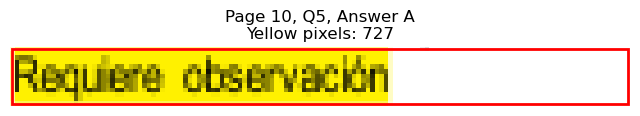

Page 10, Q5 - B: Detected box: x0=71.3, y0=410.5, x1=188.5, y1=422.6
Page 10, Q5, B: Yellow pixels: 82
Page 10, Q5, B: Total non-white pixels: 857
Page 10, Q5, B: Yellow percentage: 9.6%


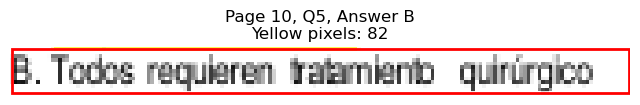

Page 10, Q5 - C: Detected box: x0=158.3, y0=422.5, x1=260.5, y1=434.6
Page 10, Q5, C: Yellow pixels: 0
Page 10, Q5, C: Total non-white pixels: 482
Page 10, Q5, C: Yellow percentage: 0.0%


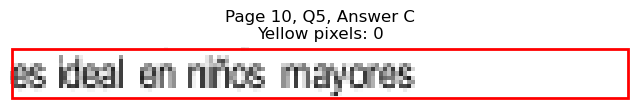

Page 10, Q5 - D: Detected box: x0=396.4, y0=398.5, x1=514.5, y1=410.6
Page 10, Q5, D: Yellow pixels: 0
Page 10, Q5, D: Total non-white pixels: 558
Page 10, Q5, D: Yellow percentage: 0.0%


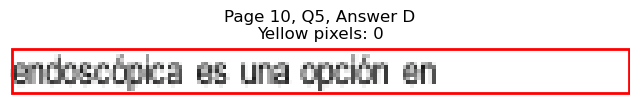

Page 10, Q5 - E: Detected box: x0=322.9, y0=422.5, x1=432.5, y1=434.6
Page 10, Q5, E: Yellow pixels: 0
Page 10, Q5, E: Total non-white pixels: 750
Page 10, Q5, E: Yellow percentage: 0.0%


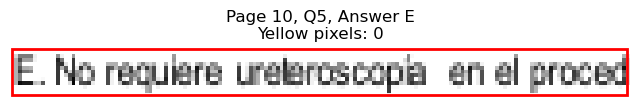


Page 10, Q5 - Selected Answer: A (based on yellow pixel count)




Page 10, Q6 - A: Detected box: x0=82.6, y0=470.6, x1=130.0, y1=482.6
Page 10, Q6, A: Yellow pixels: 0
Page 10, Q6, A: Total non-white pixels: 505
Page 10, Q6, A: Yellow percentage: 0.0%


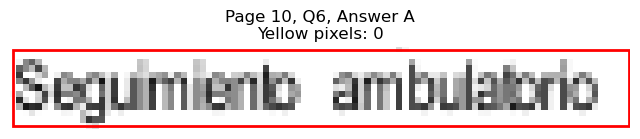

Page 10, Q6 - B: Detected box: x0=71.3, y0=483.4, x1=160.7, y1=495.4
Page 10, Q6, B: Yellow pixels: 0
Page 10, Q6, B: Total non-white pixels: 462
Page 10, Q6, B: Yellow percentage: 0.0%


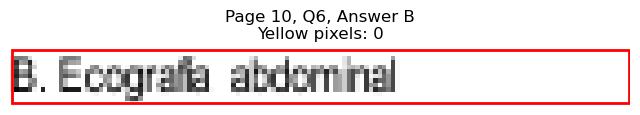

Page 10, Q6 - C: Detected box: x0=71.3, y0=495.4, x1=179.5, y1=507.4
Page 10, Q6, C: Yellow pixels: 0
Page 10, Q6, C: Total non-white pixels: 537
Page 10, Q6, C: Yellow percentage: 0.0%


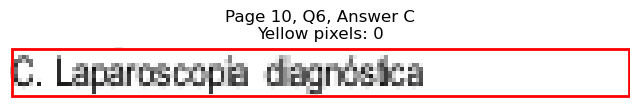

Page 10, Q6 - D: Detected box: x0=322.9, y0=470.6, x1=395.1, y1=482.6
Page 10, Q6, D: Yellow pixels: 534
Page 10, Q6, D: Total non-white pixels: 923
Page 10, Q6, D: Yellow percentage: 57.9%


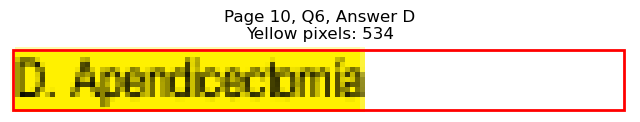

Page 10, Q6 - E: Detected box: x0=322.9, y0=483.4, x1=377.0, y1=495.4
Page 10, Q6, E: Yellow pixels: 69
Page 10, Q6, E: Total non-white pixels: 539
Page 10, Q6, E: Yellow percentage: 12.8%


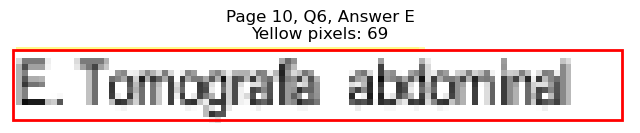


Page 10, Q6 - Selected Answer: D (based on yellow pixel count)




Page 10, Q7 - A: Detected box: x0=82.6, y0=543.4, x1=132.2, y1=555.5
Page 10, Q7, A: Yellow pixels: 0
Page 10, Q7, A: Total non-white pixels: 252
Page 10, Q7, A: Yellow percentage: 0.0%


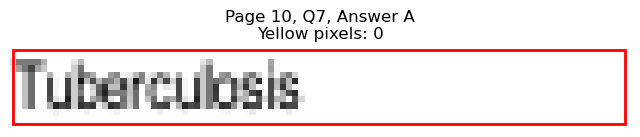

Page 10, Q7 - B: Detected box: x0=71.3, y0=555.4, x1=115.8, y1=567.5
Page 10, Q7, B: Yellow pixels: 355
Page 10, Q7, B: Total non-white pixels: 559
Page 10, Q7, B: Yellow percentage: 63.5%


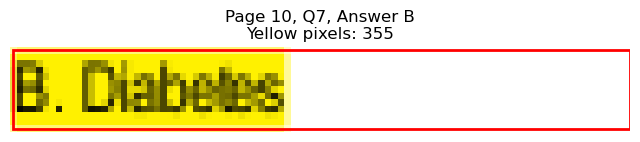

Page 10, Q7 - C: Detected box: x0=71.3, y0=567.5, x1=128.5, y1=579.5
Page 10, Q7, C: Yellow pixels: 41
Page 10, Q7, C: Total non-white pixels: 316
Page 10, Q7, C: Yellow percentage: 13.0%


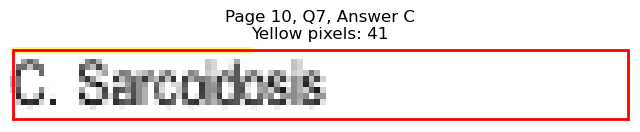

Page 10, Q7 - D: Detected box: x0=322.9, y0=543.4, x1=378.5, y1=555.5
Page 10, Q7, D: Yellow pixels: 0
Page 10, Q7, D: Total non-white pixels: 275
Page 10, Q7, D: Yellow percentage: 0.0%


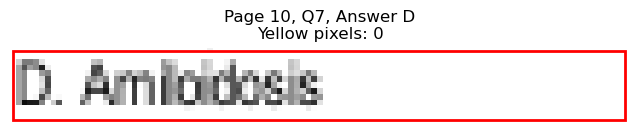

Page 10, Q7 - E: Detected box: x0=322.9, y0=555.4, x1=389.8, y1=567.5
Page 10, Q7, E: Yellow pixels: 0
Page 10, Q7, E: Total non-white pixels: 315
Page 10, Q7, E: Yellow percentage: 0.0%


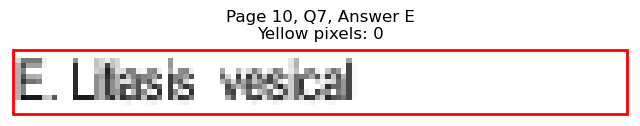


Page 10, Q7 - Selected Answer: B (based on yellow pixel count)




Page 10, Q8 - A: Detected box: x0=82.6, y0=603.5, x1=166.8, y1=615.5
Page 10, Q8, A: Yellow pixels: 0
Page 10, Q8, A: Total non-white pixels: 427
Page 10, Q8, A: Yellow percentage: 0.0%


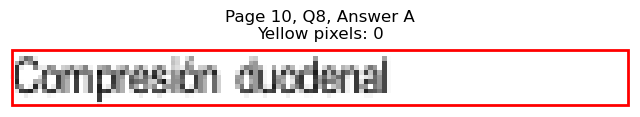

Page 10, Q8 - B: Detected box: x0=71.3, y0=615.5, x1=184.8, y1=627.5
Page 10, Q8, B: Yellow pixels: 0
Page 10, Q8, B: Total non-white pixels: 580
Page 10, Q8, B: Yellow percentage: 0.0%


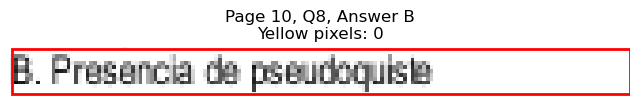

Page 10, Q8 - C: Detected box: x0=129.1, y0=627.5, x1=206.5, y1=639.6
Page 10, Q8, C: Yellow pixels: 0
Page 10, Q8, C: Total non-white pixels: 394
Page 10, Q8, C: Yellow percentage: 0.0%


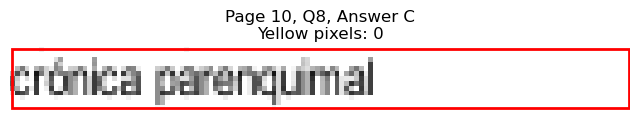

Page 10, Q8 - D: Detected box: x0=322.9, y0=603.5, x1=381.5, y1=615.5
Page 10, Q8, D: Yellow pixels: 737
Page 10, Q8, D: Total non-white pixels: 1092
Page 10, Q8, D: Yellow percentage: 67.5%


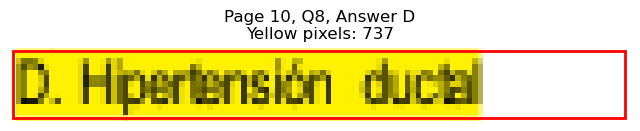

Page 10, Q8 - E: Detected box: x0=322.9, y0=615.5, x1=405.5, y1=627.5
Page 10, Q8, E: Yellow pixels: 82
Page 10, Q8, E: Total non-white pixels: 460
Page 10, Q8, E: Yellow percentage: 17.8%


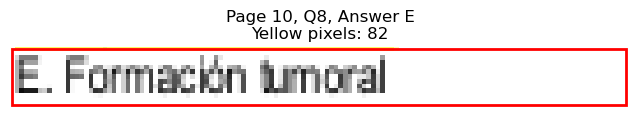


Page 10, Q8 - Selected Answer: D (based on yellow pixel count)




Page 10, Q9 - A: Detected box: x0=82.6, y0=676.3, x1=108.3, y1=688.3
Page 10, Q9, A: Yellow pixels: 161
Page 10, Q9, A: Total non-white pixels: 312
Page 10, Q9, A: Yellow percentage: 51.6%


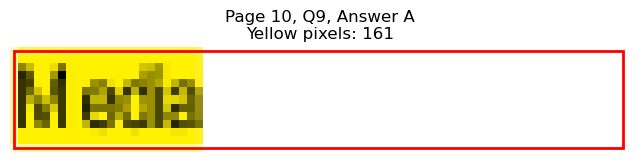

Page 10, Q9 - B: Detected box: x0=71.3, y0=688.3, x1=115.7, y1=700.3
Page 10, Q9, B: Yellow pixels: 0
Page 10, Q9, B: Total non-white pixels: 239
Page 10, Q9, B: Yellow percentage: 0.0%


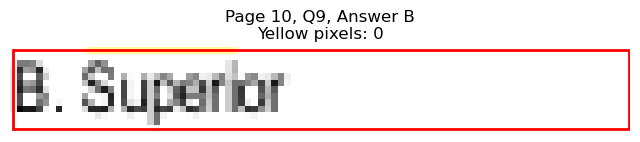

Page 10, Q9 - C: Detected box: x0=71.3, y0=700.3, x1=109.7, y1=712.3
Page 10, Q9, C: Yellow pixels: 0
Page 10, Q9, C: Total non-white pixels: 168
Page 10, Q9, C: Yellow percentage: 0.0%


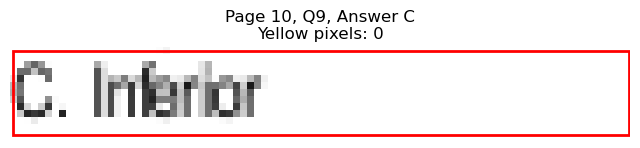

Page 10, Q9 - D: Detected box: x0=322.9, y0=676.3, x1=390.5, y1=688.3
Page 10, Q9, D: Yellow pixels: 0
Page 10, Q9, D: Total non-white pixels: 334
Page 10, Q9, D: Yellow percentage: 0.0%


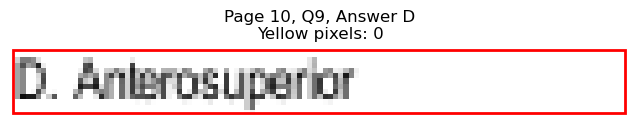

Page 10, Q9 - E: Detected box: x0=322.9, y0=688.3, x1=389.0, y1=700.3
Page 10, Q9, E: Yellow pixels: 0
Page 10, Q9, E: Total non-white pixels: 338
Page 10, Q9, E: Yellow percentage: 0.0%


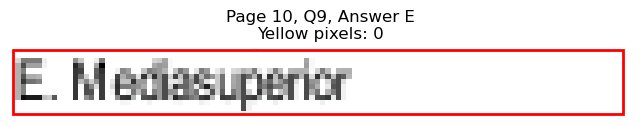


Page 10, Q9 - Selected Answer: A (based on yellow pixel count)




Page 10, Q10 - A: Detected box: x0=82.6, y0=736.4, x1=196.0, y1=748.4
Page 10, Q10, A: Yellow pixels: 0
Page 10, Q10, A: Total non-white pixels: 577
Page 10, Q10, A: Yellow percentage: 0.0%


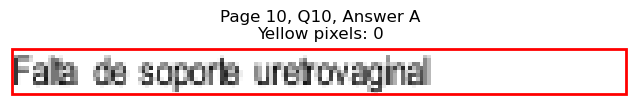

Page 10, Q10 - B: Detected box: x0=211.0, y0=748.4, x1=282.4, y1=760.4
Page 10, Q10, B: Yellow pixels: 0
Page 10, Q10, B: Total non-white pixels: 402
Page 10, Q10, B: Yellow percentage: 0.0%


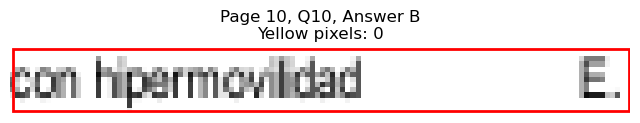

Page 10, Q10 - C: Detected box: x0=132.8, y0=760.4, x1=214.2, y1=772.4
Page 10, Q10, C: Yellow pixels: 734
Page 10, Q10, C: Total non-white pixels: 1041
Page 10, Q10, C: Yellow percentage: 70.5%


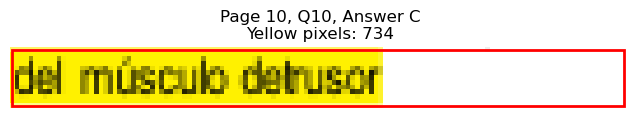

Page 10, Q10 - D: Detected box: x0=460.1, y0=736.4, x1=528.5, y1=748.4
Page 10, Q10, D: Yellow pixels: 0
Page 10, Q10, D: Total non-white pixels: 354
Page 10, Q10, D: Yellow percentage: 0.0%


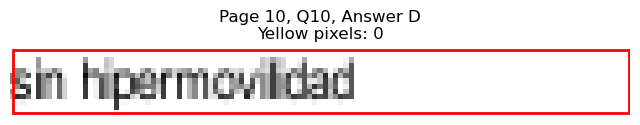

Page 10, Q10 - E: Detected box: x0=322.9, y0=748.4, x1=463.3, y1=760.4
Page 10, Q10, E: Yellow pixels: 0
Page 10, Q10, E: Total non-white pixels: 832
Page 10, Q10, E: Yellow percentage: 0.0%


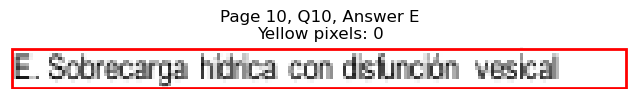


Page 10, Q10 - Selected Answer: C (based on yellow pixel count)





Page 11: Found 6 questions
Page 11, Q1 - A: Detected box: x0=82.6, y0=109.5, x1=191.5, y1=121.6
Page 11, Q1, A: Yellow pixels: 0
Page 11, Q1, A: Total non-white pixels: 545
Page 11, Q1, A: Yellow percentage: 0.0%


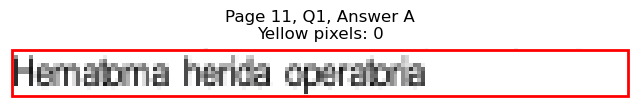

Page 11, Q1 - B: Detected box: x0=71.3, y0=121.5, x1=142.8, y1=133.6
Page 11, Q1, B: Yellow pixels: 627
Page 11, Q1, B: Total non-white pixels: 911
Page 11, Q1, B: Yellow percentage: 68.8%


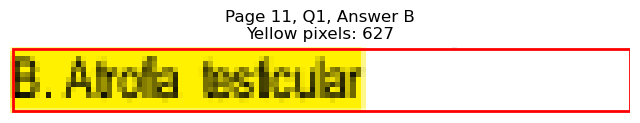

Page 11, Q1 - C: Detected box: x0=71.3, y0=133.5, x1=119.5, y1=145.6
Page 11, Q1, C: Yellow pixels: 69
Page 11, Q1, C: Total non-white pixels: 280
Page 11, Q1, C: Yellow percentage: 24.6%


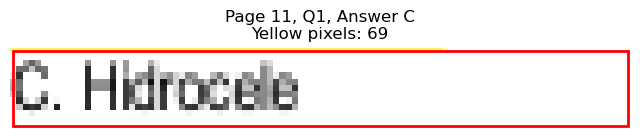

Page 11, Q1 - D: Detected box: x0=322.9, y0=109.5, x1=376.3, y1=121.6
Page 11, Q1, D: Yellow pixels: 0
Page 11, Q1, D: Total non-white pixels: 285
Page 11, Q1, D: Yellow percentage: 0.0%


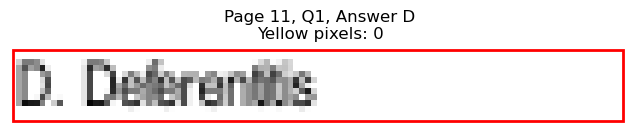

Page 11, Q1 - E: Detected box: x0=322.9, y0=121.5, x1=376.3, y1=133.6
Page 11, Q1, E: Yellow pixels: 0
Page 11, Q1, E: Total non-white pixels: 290
Page 11, Q1, E: Yellow percentage: 0.0%


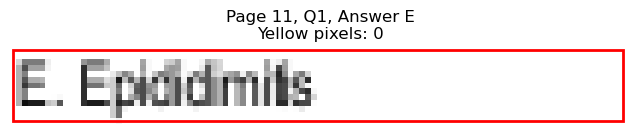


Page 11, Q1 - Selected Answer: B (based on yellow pixel count)




Page 11, Q2 - A: Detected box: x0=181.6, y0=181.6, x1=263.0, y1=193.6
Page 11, Q2, A: Yellow pixels: 635
Page 11, Q2, A: Total non-white pixels: 1040
Page 11, Q2, A: Yellow percentage: 61.1%


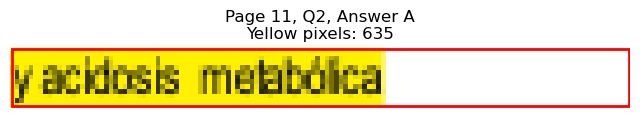

Page 11, Q2 - B: Detected box: x0=71.3, y0=193.6, x1=125.5, y1=205.6
Page 11, Q2, B: Yellow pixels: 93
Page 11, Q2, B: Total non-white pixels: 609
Page 11, Q2, B: Yellow percentage: 15.3%


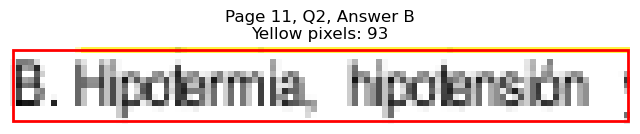

Page 11, Q2 - C: Detected box: x0=71.3, y0=205.6, x1=164.5, y1=217.7
Page 11, Q2, C: Yellow pixels: 0
Page 11, Q2, C: Total non-white pixels: 702
Page 11, Q2, C: Yellow percentage: 0.0%


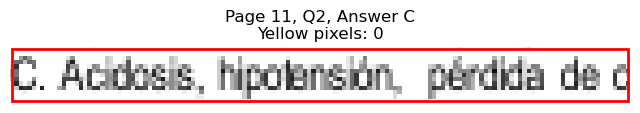

Page 11, Q2 - D: Detected box: x0=322.9, y0=181.6, x1=386.1, y1=193.6
Page 11, Q2, D: Yellow pixels: 0
Page 11, Q2, D: Total non-white pixels: 568
Page 11, Q2, D: Yellow percentage: 0.0%


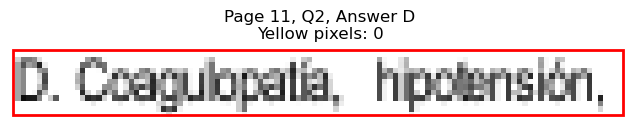

Page 11, Q2 - E: Detected box: x0=431.0, y0=205.6, x1=506.9, y1=217.7
Page 11, Q2, E: Yellow pixels: 0
Page 11, Q2, E: Total non-white pixels: 392
Page 11, Q2, E: Yellow percentage: 0.0%


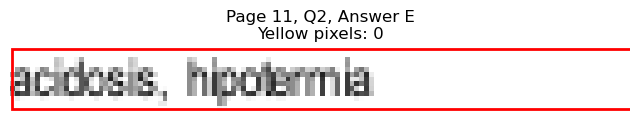


Page 11, Q2 - Selected Answer: A (based on yellow pixel count)




Page 11, Q3 - A: Detected box: x0=82.6, y0=241.6, x1=206.6, y1=253.7
Page 11, Q3, A: Yellow pixels: 0
Page 11, Q3, A: Total non-white pixels: 655
Page 11, Q3, A: Yellow percentage: 0.0%


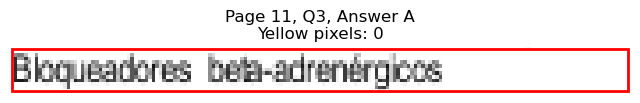

Page 11, Q3 - B: Detected box: x0=71.3, y0=253.6, x1=144.2, y1=265.7
Page 11, Q3, B: Yellow pixels: 0
Page 11, Q3, B: Total non-white pixels: 615
Page 11, Q3, B: Yellow percentage: 0.0%


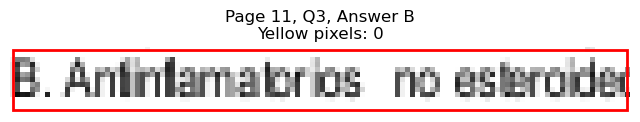

Page 11, Q3 - C: Detected box: x0=71.3, y0=265.7, x1=144.9, y1=277.7
Page 11, Q3, C: Yellow pixels: 0
Page 11, Q3, C: Total non-white pixels: 595
Page 11, Q3, C: Yellow percentage: 0.0%


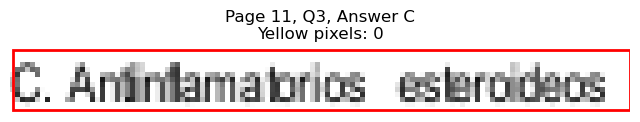

Page 11, Q3 - D: Detected box: x0=322.9, y0=241.6, x1=455.2, y1=253.7
Page 11, Q3, D: Yellow pixels: 984
Page 11, Q3, D: Total non-white pixels: 1703
Page 11, Q3, D: Yellow percentage: 57.8%


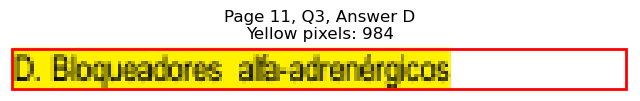

Page 11, Q3 - E: Detected box: x0=322.9, y0=253.6, x1=474.0, y1=265.7
Page 11, Q3, E: Yellow pixels: 130
Page 11, Q3, E: Total non-white pixels: 868
Page 11, Q3, E: Yellow percentage: 15.0%


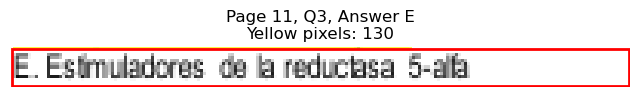


Page 11, Q3 - Selected Answer: D (based on yellow pixel count)




Page 11, Q4 - A: Detected box: x0=71.3, y0=326.5, x1=79.7, y1=338.5
Page 11, Q4, A: Yellow pixels: 0
Page 11, Q4, A: Total non-white pixels: 64
Page 11, Q4, A: Yellow percentage: 0.0%


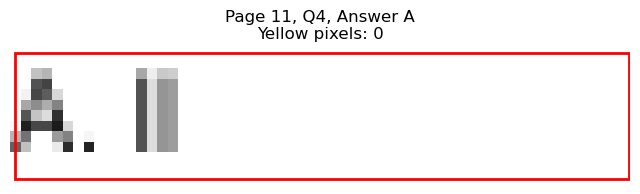

Page 11, Q4 - B: Detected box: x0=71.3, y0=338.5, x1=86.5, y1=350.5
Page 11, Q4, B: Yellow pixels: 0
Page 11, Q4, B: Total non-white pixels: 58
Page 11, Q4, B: Yellow percentage: 0.0%


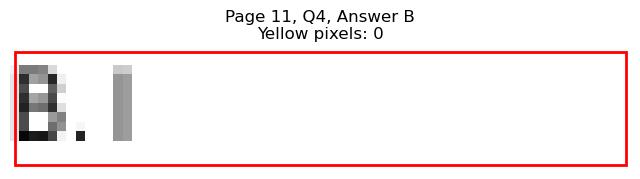

Page 11, Q4 - C: Detected box: x0=71.3, y0=350.5, x1=92.5, y1=362.5
Page 11, Q4, C: Yellow pixels: 0
Page 11, Q4, C: Total non-white pixels: 73
Page 11, Q4, C: Yellow percentage: 0.0%


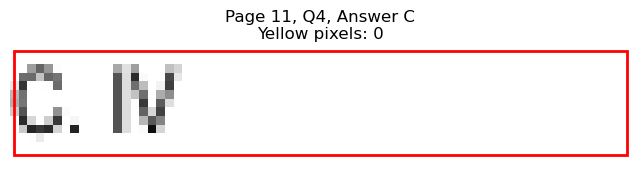

Page 11, Q4 - D: Detected box: x0=322.9, y0=326.5, x1=343.3, y1=338.5
Page 11, Q4, D: Yellow pixels: 168
Page 11, Q4, D: Total non-white pixels: 247
Page 11, Q4, D: Yellow percentage: 68.0%


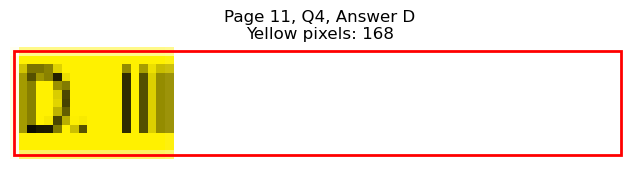

Page 11, Q4 - E: Detected box: x0=322.9, y0=338.5, x1=345.5, y1=350.5
Page 11, Q4, E: Yellow pixels: 18
Page 11, Q4, E: Total non-white pixels: 116
Page 11, Q4, E: Yellow percentage: 15.5%


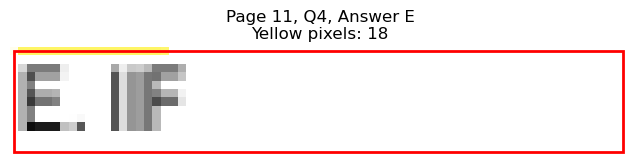


Page 11, Q4 - Selected Answer: D (based on yellow pixel count)




Page 11, Q5 - A: Detected box: x0=82.6, y0=386.5, x1=115.0, y1=398.6
Page 11, Q5, A: Yellow pixels: 231
Page 11, Q5, A: Total non-white pixels: 404
Page 11, Q5, A: Yellow percentage: 57.2%


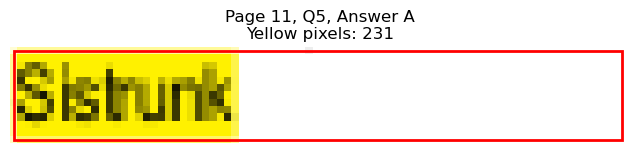

Page 11, Q5 - B: Detected box: x0=71.3, y0=398.5, x1=130.7, y1=410.6
Page 11, Q5, B: Yellow pixels: 30
Page 11, Q5, B: Total non-white pixels: 334
Page 11, Q5, B: Yellow percentage: 9.0%


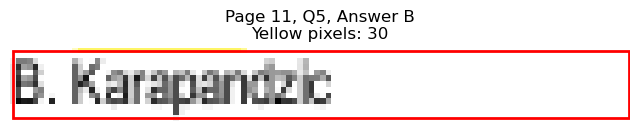

Page 11, Q5 - C: Detected box: x0=71.3, y0=410.5, x1=110.5, y1=422.6
Page 11, Q5, C: Yellow pixels: 0
Page 11, Q5, C: Total non-white pixels: 163
Page 11, Q5, C: Yellow percentage: 0.0%


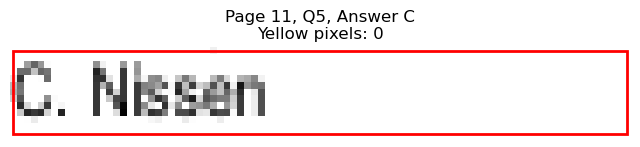

Page 11, Q5 - D: Detected box: x0=322.9, y0=386.5, x1=361.3, y1=398.6
Page 11, Q5, D: Yellow pixels: 0
Page 11, Q5, D: Total non-white pixels: 181
Page 11, Q5, D: Yellow percentage: 0.0%


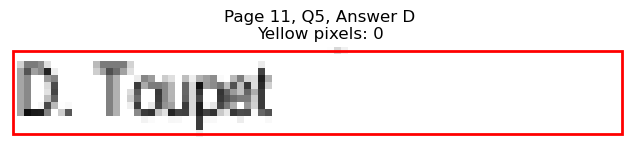

Page 11, Q5 - E: Detected box: x0=322.9, y0=398.5, x1=356.8, y1=410.6
Page 11, Q5, E: Yellow pixels: 0
Page 11, Q5, E: Total non-white pixels: 149
Page 11, Q5, E: Yellow percentage: 0.0%


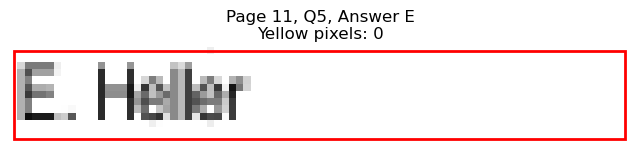


Page 11, Q5 - Selected Answer: A (based on yellow pixel count)




Page 11, Q6 - A: Detected box: x0=82.6, y0=446.6, x1=143.6, y1=458.6
Page 11, Q6, A: Yellow pixels: 424
Page 11, Q6, A: Total non-white pixels: 780
Page 11, Q6, A: Yellow percentage: 54.4%


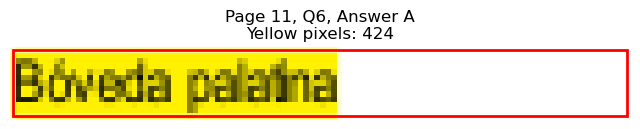

Page 11, Q6 - B: Detected box: x0=71.3, y0=458.6, x1=140.5, y1=470.6
Page 11, Q6, B: Yellow pixels: 58
Page 11, Q6, B: Total non-white pixels: 398
Page 11, Q6, B: Yellow percentage: 14.6%


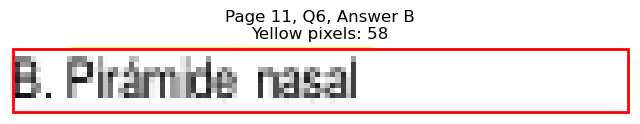

Page 11, Q6 - C: Detected box: x0=71.3, y0=470.6, x1=157.7, y1=482.6
Page 11, Q6, C: Yellow pixels: 0
Page 11, Q6, C: Total non-white pixels: 424
Page 11, Q6, C: Yellow percentage: 0.0%


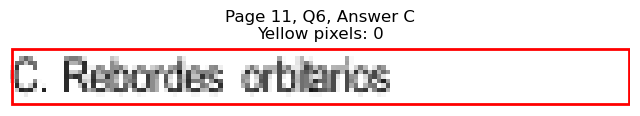

Page 11, Q6 - D: Detected box: x0=322.9, y0=446.6, x1=358.3, y1=458.6
Page 11, Q6, D: Yellow pixels: 0
Page 11, Q6, D: Total non-white pixels: 164
Page 11, Q6, D: Yellow percentage: 0.0%


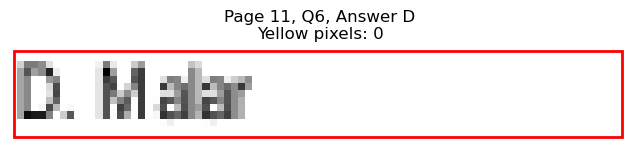

Page 11, Q6 - E: Detected box: x0=322.9, y0=458.6, x1=389.8, y1=470.6
Page 11, Q6, E: Yellow pixels: 0
Page 11, Q6, E: Total non-white pixels: 316
Page 11, Q6, E: Yellow percentage: 0.0%


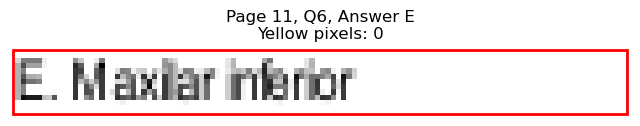


Page 11, Q6 - Selected Answer: A (based on yellow pixel count)






In [6]:
questions_df = extract_questions(pdf_path = pdf_file)
answers_df = extract_answers(pdf_path = pdf_file)
correct_answers_df = extract_correct_answers(pdf_path = pdf_file)

In [7]:
questions_df

question
0   Mujer de 72 años, multipara que refiere "cólic...
1   ¿Cuál es la causa que incrementa la incidencia...
2   ¿En qué grado(s) de la hemorroides está indica...
3   ¿Cuál es la causa más frecuente de obstrucción...
4   Neonato prematuro. Examen: bolsas escrotales h...
..                                                ...
95  ¿Cuáles son las manifestaciones del llamado "c...
96  ¿Cuál es el tratamiento médico de inicio para ...
97  ¿A qué categoría corresponde en la clasificaci...
98  ¿Cuál es la operación indicada para el tratami...
99  ¿Cuál es la estructura móvil en la fractura de...

[100 rows x 1 columns]

In [8]:
answers_df

option_A  \
0                              Sindrome de Mirizzi   
1                   Uso de agujas de mayor calibre   
2                           Segundo y tercer grado   
3                                          Hernias   
4                          Criptorquidia bilateral   
..                                             ...   
95  Coagulopatía, hipotermia y acidosis metabólica   
96                  Bloqueadores beta-adrenérgicos   
97                                              II   
98                                        Sistrunk   
99                                 Bóveda palatina   

                              option_B  \
0                 Sindrome de Bouveret   
1       Uso de agujas de menor calibre   
2               Solamente tercer grado   
3                    Cálculos biliares   
4         Testículo ectópico bilateral   
..                                 ...   
95  Hipotermia, hipotensión y oliguria   
96    Antiinflamatorios no esteroideos   
97                                   I   
98                         Karapandzic   
99                      Pirámide nasal   

                                         option_C  \
0                                     Ileo biliar   
1                                   Edad avanzada   
2                          Solamente cuarto grado   
3                                Cuerpos extraños   
4   Agenesia testicular izquierda - criptorquidia   
..                                            ...   
95   Acidosis, hipotensión, pérdida de conciencia   
96                  Antiinflamatorios esteroideos   
97                                             IV   
98                                         Nissen   
99                            Rebordes orbitarios   

                                        option_D  \
0                    Fístula colecisto- duodenal   
1                                 Sexo masculino   
2                         Primer y segundo grado   
3                                        Tumores   
4   Criptorquidia izquierda - testículo ectópico   
..                                           ...   
95      Coagulopatía, hipotensión, insuficiencia   
96                Bloqueadores alfa-adrenérgicos   
97                                           III   
98                                        Toupet   
99                                         Malar   

                                             option_E  
0                         Fístula colecisto- colonica  
1              Malformaciones en la columna vertebral  
2                                    Todos los grados  
3                                Bridas y adherencias  
4   Agenesia testicular izquierda - testículo ectó...  
..                                                ...  
95   Insuficiencia respiratoria, acidosis, hipotermia  
96               Estimuladores de la reductasa 5-alfa  
97                                                IIF  
98                                             Heller  
99                                   Maxilar inferior  

[100 rows x 5 columns]

In [9]:
correct_answers_df

correct_answer
0               C
1               A
2               D
3               E
4               D
..            ...
95              A
96              D
97              D
98              A
99              A

[100 rows x 1 columns]

In [10]:
total_df = pd.concat([questions_df, answers_df, correct_answers_df], ignore_index = True, axis = 1)
total_df.columns = ["questions", "option_A", "option_B", "option_C", "option_D", "option_E", "correct_answer"]
total_df

questions  \
0   Mujer de 72 años, multipara que refiere "cólic...   
1   ¿Cuál es la causa que incrementa la incidencia...   
2   ¿En qué grado(s) de la hemorroides está indica...   
3   ¿Cuál es la causa más frecuente de obstrucción...   
4   Neonato prematuro. Examen: bolsas escrotales h...   
..                                                ...   
95  ¿Cuáles son las manifestaciones del llamado "c...   
96  ¿Cuál es el tratamiento médico de inicio para ...   
97  ¿A qué categoría corresponde en la clasificaci...   
98  ¿Cuál es la operación indicada para el tratami...   
99  ¿Cuál es la estructura móvil en la fractura de...   

                                          option_A  \
0                              Sindrome de Mirizzi   
1                   Uso de agujas de mayor calibre   
2                           Segundo y tercer grado   
3                                          Hernias   
4                          Criptorquidia bilateral   
..                                             ...   
95  Coagulopatía, hipotermia y acidosis metabólica   
96                  Bloqueadores beta-adrenérgicos   
97                                              II   
98                                        Sistrunk   
99                                 Bóveda palatina   

                              option_B  \
0                 Sindrome de Bouveret   
1       Uso de agujas de menor calibre   
2               Solamente tercer grado   
3                    Cálculos biliares   
4         Testículo ectópico bilateral   
..                                 ...   
95  Hipotermia, hipotensión y oliguria   
96    Antiinflamatorios no esteroideos   
97                                   I   
98                         Karapandzic   
99                      Pirámide nasal   

                                         option_C  \
0                                     Ileo biliar   
1                                   Edad avanzada   
2                          Solamente cuarto grado   
3                                Cuerpos extraños   
4   Agenesia testicular izquierda - criptorquidia   
..                                            ...   
95   Acidosis, hipotensión, pérdida de conciencia   
96                  Antiinflamatorios esteroideos   
97                                             IV   
98                                         Nissen   
99                            Rebordes orbitarios   

                                        option_D  \
0                    Fístula colecisto- duodenal   
1                                 Sexo masculino   
2                         Primer y segundo grado   
3                                        Tumores   
4   Criptorquidia izquierda - testículo ectópico   
..                                           ...   
95      Coagulopatía, hipotensión, insuficiencia   
96                Bloqueadores alfa-adrenérgicos   
97                                           III   
98                                        Toupet   
99                                         Malar   

                                             option_E correct_answer  
0                         Fístula colecisto- colonica              C  
1              Malformaciones en la columna vertebral              A  
2                                    Todos los grados              D  
3                                Bridas y adherencias              E  
4   Agenesia testicular izquierda - testículo ectó...              D  
..                                                ...            ...  
95   Insuficiencia respiratoria, acidosis, hipotermia              A  
96               Estimuladores de la reductasa 5-alfa              D  
97                                                IIF              D  
98                                             Heller              A  
99                                   Maxilar inferior              A  

[100 rows x 7 columns]

In [11]:
# Extract folder path
folder_path = os.path.dirname(pdf_file)  # Gets the directory path

# Extract filename without extension
file_name = os.path.splitext(os.path.basename(pdf_file))[0]  # Removes the .pdf extension

# Create CSV file path
csv_file = os.path.join(folder_path, f"{file_name}.csv")

# Save a sample DataFrame
total_df.to_csv(csv_file, index=False, encoding="utf-8-sig")
print(f"CSV saved at: {csv_file}")


CSV saved at: /Users/rodrigocarrillo/Library/CloudStorage/OneDrive-EmoryUniversity/Natural Language Processing Projects/Examen Residentado Peru/CONAREME/Year2018/CIRUGIA.csv
